In [343]:
import sys
print(sys.version)

3.6.9 |Anaconda custom (64-bit)| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [345]:
"""
Created on Mar 3 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [346]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [347]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [348]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [349]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)

1.17.4
0.15.0
1.3.1


## unit test 

In [23]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1,npix=1536)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28d
npix_value:1536
Science image shape is: (50, 50)
Top left pixel value of the science image is: 1.0
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (50, 50)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [   24.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hs

In [24]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

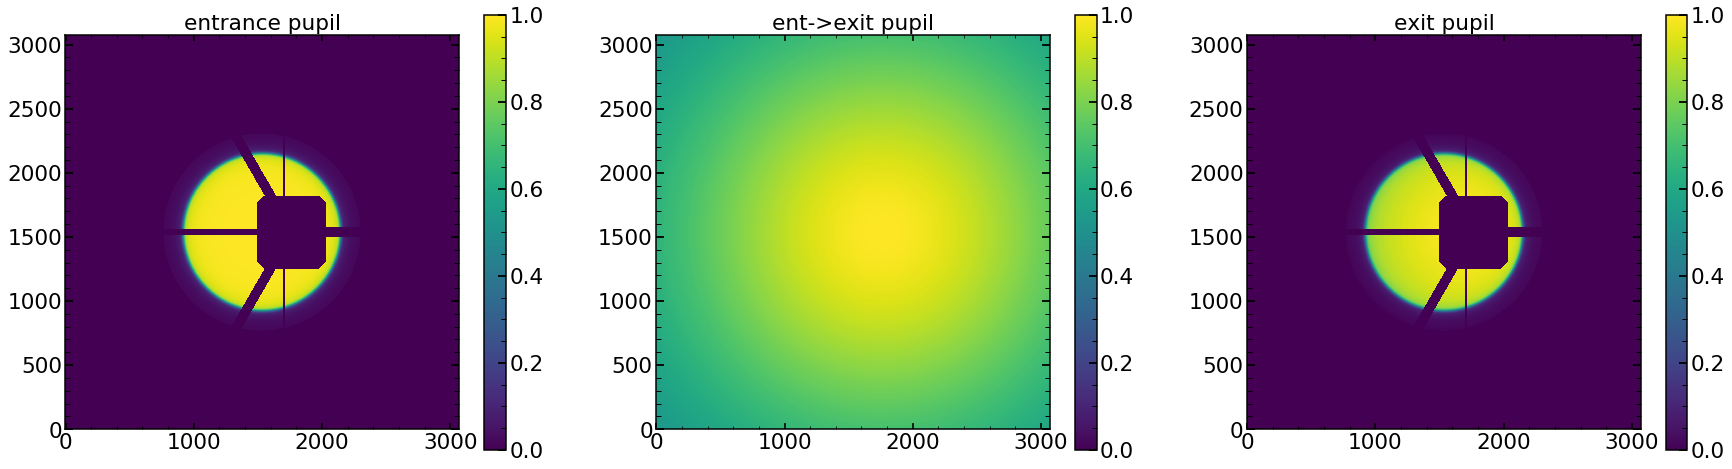

In [25]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

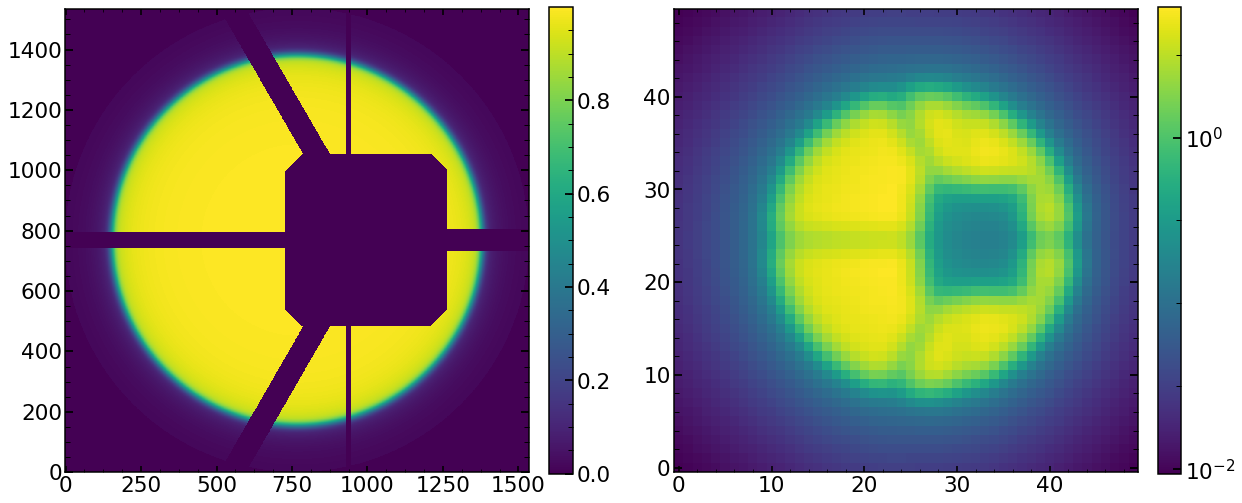

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10**-2,1,10,10**2,10**3,10**4,10**5])

# Custom size of ilum_radiometric 

## simulations

In [25]:
sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1,simulation_00=1)   
res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.28
npix_value:512
Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hscF

In [ ]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

In [ ]:
plt.imshow(optPsf_cut_fiber_convolved_downsampled)

In [32]:
# compare results from 50x50 image and 20x20 image - both on real data and when sim00=1

28.95

In [56]:
sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,npix=1536,verbosity=1,sim)   
res=model(allparameters_proposal,return_Image=True)
optPsf_cut_fiber_convolved_downsampled_1536=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1)   
res=model(allparameters_proposal,return_Image=True)
optPsf_cut_fiber_convolved_downsampled_20=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
['hscFrac', 'strutFrac', 'dxFocal', 'dyFocal', 'sl

Time for cutting out the square is 0.14879894256591797
Finished with getPupil
Finished with _get_Pupil
 
Time for single pupil calculation is 0.4267399311065674
Supplied pupil size is (pupil.size) [m]: 0.1395327
One pixel has size of (pupil.scale) [m]: 0.00013626240234375
Supplied pupil has so many pixels (pupil_plane_im): (1024, 1024)
Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 0.0, 0.09, 0.02, -0.1, 0.0, 0.1, 0.02, 0.2]
aberrations 0 [0.0, 0.0, 0.0, 0.0, 0, 0.09, 0.02, -0.1, 0.0, 0.1, 0.02, 0]
aberrations extra: None
self.wavelength: 794
lower_limit_of_ilum: 512
higher_limit_of_ilum: 1536
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (2048, 2048)
size_of_ilum_in_units_of_radius: 2.0
Time for FFT is 0.1808640956878662
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (2048, 2048)
oversampling_original: 35.374287997579025
size_of_central_cut: 990
optPsf_cut.shape(991, 

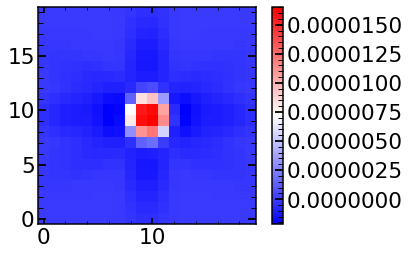

In [64]:
optPsf_cut_fiber_convolved_downsampled_1536=optPsf_cut_fiber_convolved_downsampled_1536*np.sum(1)/np.sum(optPsf_cut_fiber_convolved_downsampled_1536)
optPsf_cut_fiber_convolved_downsampled_20=optPsf_cut_fiber_convolved_downsampled_20/np.sum(optPsf_cut_fiber_convolved_downsampled_20)

plt.imshow(optPsf_cut_fiber_convolved_downsampled_20-optPsf_cut_fiber_convolved_downsampled_1536,cmap='bwr')
plt.colorbar()

## checking with the real data 

### ``old'' version

In [26]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [27]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [30]:

date='Feb1420'
obs=21346+54
obs_int=int(obs)
single_number='57'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]
double_sources=0
double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
double_sources_positions_ratios

0d


array([0, 0], dtype=object)

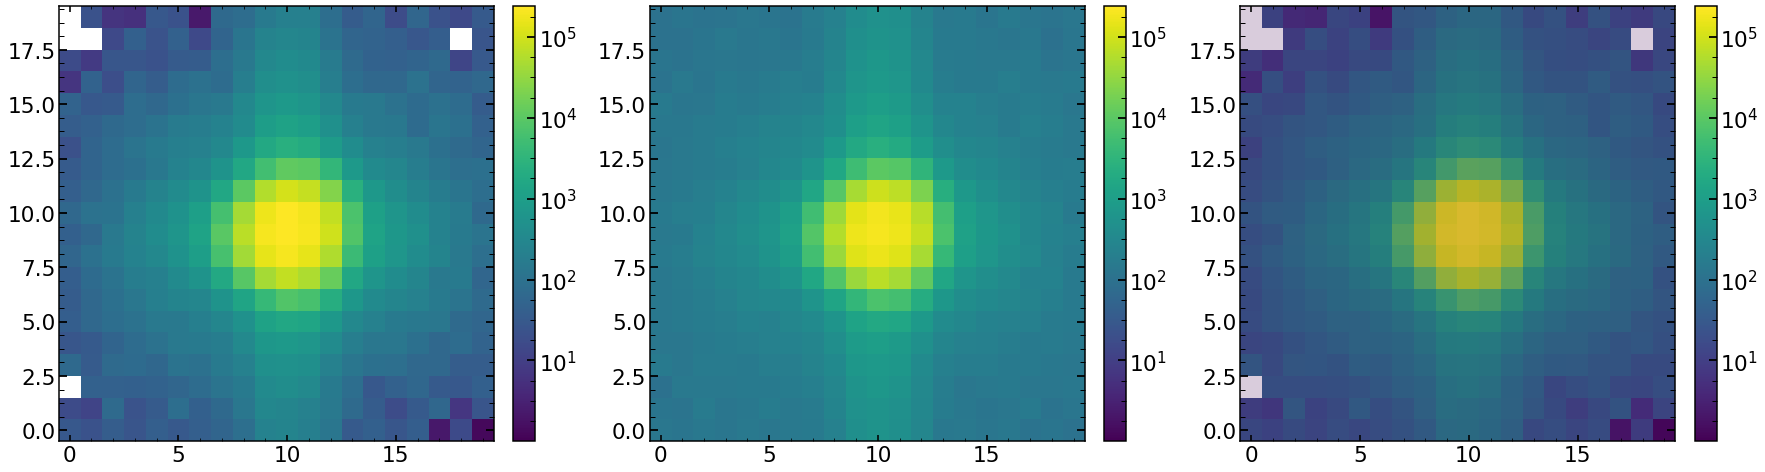

In [31]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [32]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 5380.929438215129
minimal chi2 reduced is: 19.06665524771627


In [409]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (60, 60)
Top left pixel value of the science image is: 338.15002
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 381.6772
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [   30.31229776    -0.42182597    -0.43528261     0.47914274
     0.13289489    -0.07654536    -0.35385487    -0.35668121
    -0.10561782    -0.05251076    -0.0393296     -0.01454286
    -0.0162427      0.02052808     0.0084521      0.01574609
    -0.02253111     0.03012259     0.04264008     0.67491073
     0.08982254    -0.11321028    -0.02234861     0.05591473
     0.03427195     0.00001378     0.00001378     0.97544756
     0.94834567     0.00664462    -0.05191504     0.91502452
     0.05903107     0.68305317     1.00839089  

-1138770.6292106241

In [410]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')

chi**2 reduced is: 621.7611801272317
Abs of residual divided by total flux is: 0.054733871698216446
Abs of residual divided by largest value of a flux in the image is: 0.1384532868513637


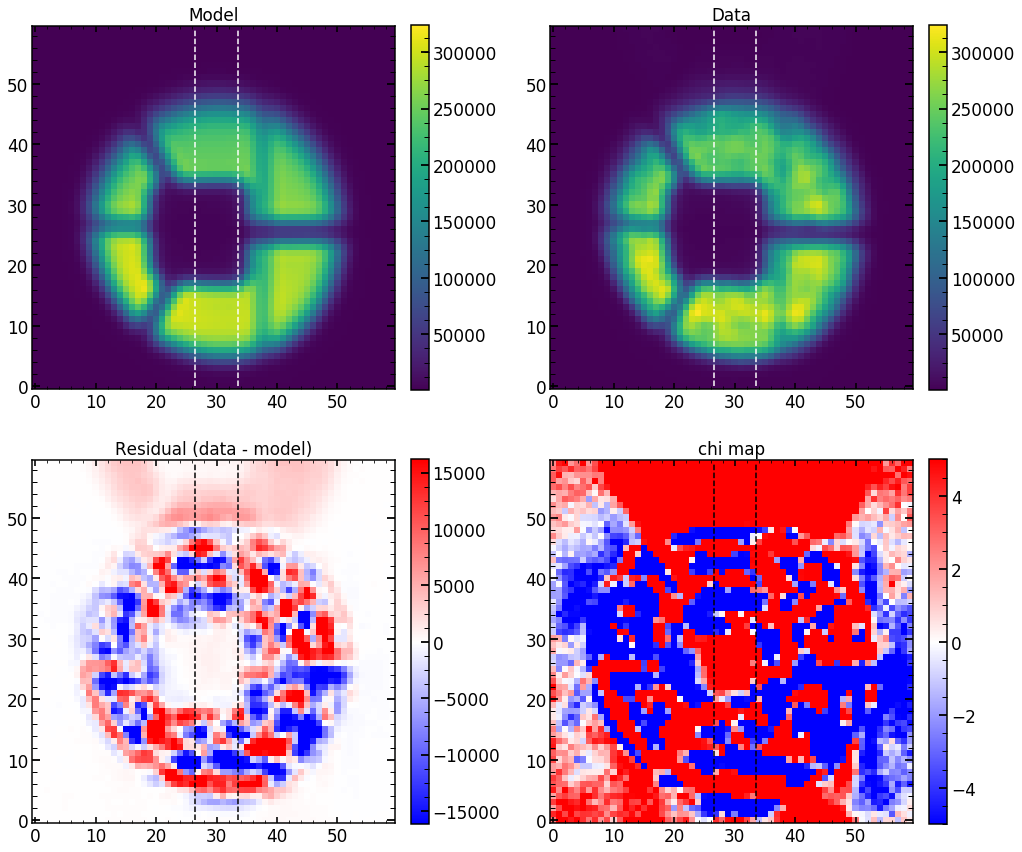

In [411]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

### ``new'' version

In [39]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (20, 20)
Top left pixel value of the science image is: 30.257544
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 135.49706
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.19806336    -0.24694844    -0.13653308     0.39085092
    -0.01095516     0.05506952    -0.50631035    -0.26016694
     0.02678486     0.11240715    -0.04227812     0.13926078
    -0.06559608     0.01425848     0.03857009     0.11374348
    -0.07798599     0.10679211     0.23054775     0.7432363
     0.08906604    -0.29028661     0.1593336      0.05469169
     0.04195337     0.0000059      0.0000059      0.97421296
     0.94834465     0.09896747    -0.03767091     0.89762369
     0.0115111      0.74360877     1.04190588  

-5330.566668651544

In [40]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')

chi**2 reduced is: 18.814841178459943
Abs of residual divided by total flux is: 0.03605289630490884
Abs of residual divided by largest value of a flux in the image is: 0.07312789163912978


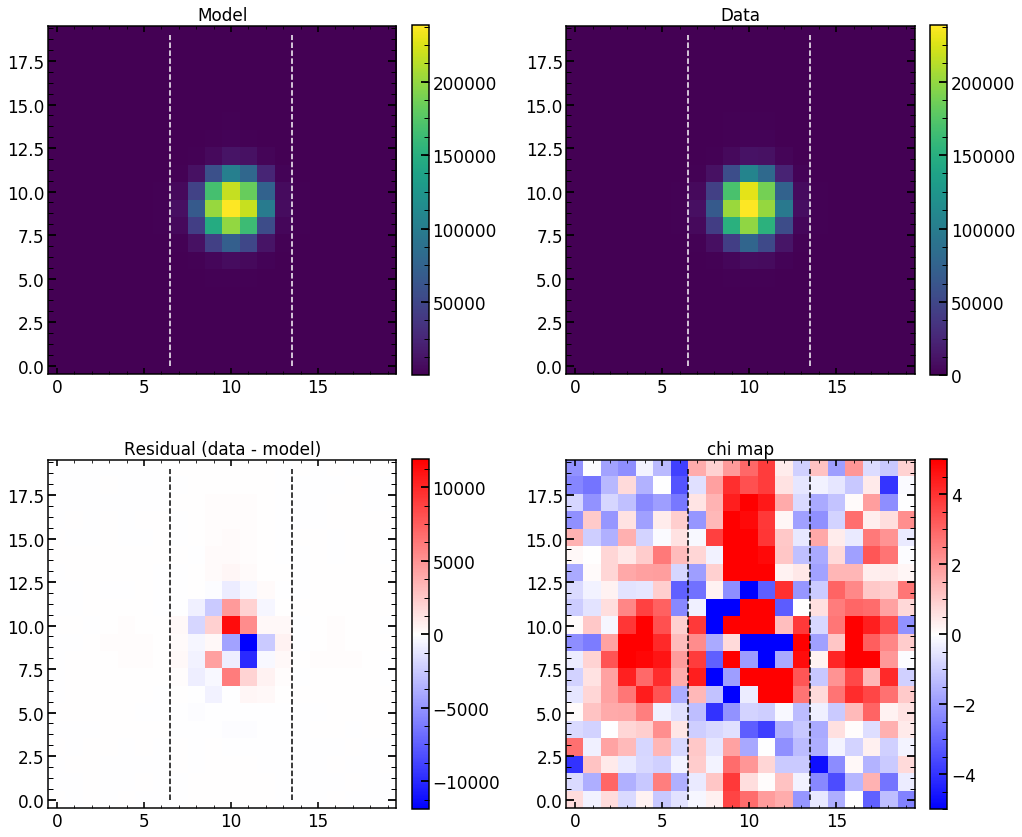

In [41]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

# Mar06

## First test few scripts 

In [27]:
def remove(string): 
    return string.replace(" ", "")

remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))

NameError: name 'finalHgAr_Feb2020_dataset' is not defined

In [66]:
#MPI

list_of_HgAr_to_analyze=[51,53,54,55,56]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48,21346+60,21346+18,21346+90,21346+36,21346+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger01'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T01S'+str(single_spot)+'Mar20.sh \n')

file.close()
##################
##################
##################


list_of_Ne_to_analyze=[26,29]

for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0        

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+6,21550+102,21550+54,21550+12,21550+96,21550+48,21550+60,21550+18,21550+90,21550+36,21550+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger02'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T02S'+str(single_spot)+'Mar20.sh \n')

file.close()
##################
##################
##################

list_of_Kr_to_analyze=[27,28]

for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0  
    
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 17:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+96,21754+48,21754+60,21754+18,21754+90,21754+36,21754+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger03'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T03S'+str(single_spot)+'Mar20.sh \n')

file.close()

## extend 

In [28]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [30]:
def remove(string): 
    return string.replace(" ", "")

In [31]:
list_of_HgAr_to_analyze=np.unique(arranged_by_spot_number_HgAr[:,1])
list_of_HgAr_to_analyze

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70])

In [39]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==str(1)].index

Int64Index([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,
             63,  66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119],
           dtype='int64')

In [355]:
#MPI

list_of_HgAr_to_analyze=[64,65,66,67,68,69,70]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger01'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T01S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # p05,m3,p3,m15,p15
    for obs in [21346+60,21346+18,21346+90,21346+36,21346+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger02'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T02S'+str(single_spot)+'Mar20.sh \n')

file.close()


##################
##################
##################


list_of_Ne_to_analyze=[ 0,  3,  8,  9, 12, 17, 18, 21, 27, 30, 36, 39, 44, 45, 48, 53, 54,
       57, 62, 63, 66, 71, 72, 75, 80, 81, 84, 89,2, 5,  6,  7, 11, 14, 15, 16, 20, 23, 24, 25, 29, 32, 33, 34, 38,
            41, 42, 43, 47, 50, 51, 52, 56, 59, 60, 61, 65, 68, 69, 70, 74, 77,
            78, 79, 83, 86, 87, 88]

for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0        

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+60,21550+18,21550+90,21550+36,21550+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()   
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger03'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T03S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0        

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T04S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21550+6,21550+102,21550+54,21550+12,21550+96,21550+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()   
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger04'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T04S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################
##################
##################

list_of_Kr_to_analyze=[15,16,17,18,19,20,21]

for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0  
    
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T05S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+96,21754+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger05'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T05S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0  
    
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, p35, m05, p05,m3,p3,m15,p15
    for obs in [21754+60,21754+18,21754+90,21754+36,21754+72]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger06'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T06S'+str(single_spot)+'Mar20.sh \n')

file.close()


## extended Mar 21 - HgAr

In [40]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [41]:
def remove(string): 
    return string.replace(" ", "")

In [42]:
list_of_HgAr_to_analyze=np.unique(arranged_by_spot_number_HgAr[:,1])
list_of_HgAr_to_analyze

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70])

In [43]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==str(1)].index

Int64Index([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,
             63,  66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119],
           dtype='int64')

In [44]:
#MPI

list_of_HgAr_to_analyze=[ 1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T10S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, m05
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger10'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T10S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T11S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # p05,m3,p3,m15
    for obs in [21346+60,21346+18,21346+90,21346+36]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger11'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T11S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T12S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # !repetition!
    #  m4, p4, p15, m25, p25
    for obs in [21346+6,21346+102,21346+72,21550+24,21550+84]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger12'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T12S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################
##################
##################

## extension - Krypton March 26

In [21]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [22]:
def remove(string): 
    return string.replace(" ", "")

In [105]:
already_Kr_analyzed=np.unique(arranged_by_spot_number_Kr[:,1])
already_Kr_analyzed

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [110]:
finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['close']==0].index

Int64Index([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 16, 17, 18, 20, 21,
            22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 36, 37, 38],
           dtype='int64')

In [113]:
list_of_Kr_to_analyze=np.setdiff1d(finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['close']==0].index,already_Kr_analyzed)
list_of_Kr_to_analyze

array([ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 29, 30, 32, 33, 34,
       36, 37, 38])

In [118]:
#MPI


for single_spot in list_of_Kr_to_analyze:
    if finalKr_Feb2020_dataset.loc[single_spot]['close']==0:
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T13S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, m05
    for obs in [21754+6,21754+102,21754+54,21754+12,21754+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger13'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T13S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Kr_to_analyze:
    if finalKr_Feb2020_dataset.loc[single_spot]['close']==0:
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T14S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # p05,m3,p3,m15
    for obs in [21754+60,21754+18,21754+90,21754+36]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger14'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T14S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_Kr_to_analyze:
    if finalKr_Feb2020_dataset.loc[single_spot]['close']==0:
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T15S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # !repetition!
    #  p15, p35, m25, p25
    for obs in [21754+72,21754+96,21754+24,21754+84]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger15'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T15S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################
##################
##################

In [117]:
finalKr_Feb2020_dataset.loc[17]['close']

0

## extension - which one am I still missing 

In [247]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='1'].index
# take unique_numbers_with_5_or_more_images_HgAr from next section


Int64Index([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,
             63,  66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119],
           dtype='int64')

In [ ]:
np.complement

In [249]:
np.setdiff1d(finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='0'].index,unique_numbers_with_5_or_more_images_HgAr)

array([  0,   2,   4,  10,  12,  14,  16,  22,  24,  26,  28,  34,  36,
        38,  40,  64,  72,  74,  76,  82,  84,  86,  88,  94,  96,  98,
       100, 106, 108, 110, 112, 118])

In [256]:
        x_HgAr_observed=finalHgAr.loc[unique_numbers_with_5_or_more_images_HgAr]['xc_effective'].values
        y_HgAr_observed=finalHgAr.loc[unique_numbers_with_5_or_more_images_HgAr]['yc'].values

In [274]:
        x_HgAr_0=finalHgAr_Feb2020_dataset.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='0'].index.astype(int)]['xc_effective'].values
        y_HgAr_0=finalHgAr_Feb2020_dataset.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='0'].index.astype(int)]['yc'].values
        len(x_HgAr_0)

40

In [286]:
        x_HgAr_05=finalHgAr_Feb2020_dataset.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==0.5].index.astype(int)]['xc_effective'].values
        y_HgAr_05=finalHgAr_Feb2020_dataset.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==0.5].index.astype(int)]['yc'].values
        len(x_HgAr_05)

30

In [289]:
finalHgAr_Feb2020_dataset.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==0.5].index.astype(int)]

fiber    xc    yc wavelength close  lamp xc_effective second_offset  \
5       2    73  1647  763.74286   0.5  HgAr           73             0   
7       2    72  2377   826.6699   0.5  HgAr           72             0   
8       2    72  2679   852.4029   0.5  HgAr           72             0   
17     63   463  1631  763.74286   0.5  HgAr          463             0   
19     63   463  2361   826.6699   0.5  HgAr          463             0   
20     63   462  2662   852.4029   0.5  HgAr          462             0   
29    192   846  1620  763.74286   0.5  HgAr          846             0   
31    192   846  2350   826.6699   0.5  HgAr          846             0   
32    192   846  2651   852.4029   0.5  HgAr          846             0   
41    255  1224  1612  763.74286   0.5  HgAr         1224             0   
43    255  1223  2340   826.6699   0.5  HgAr         1223             0   
44    255  1223  2641   852.4029   0.5  HgAr         1223             0   
53    339  1610  1606  763.74286   0.5  HgAr         1610             0   
55    339  1610  2334   826.6699   0.5  HgAr         1610             0   
56    339  1610  2635   852.4029   0.5  HgAr         1610             0   
65    401  1992  1603  763.74286   0.5  HgAr         1992             0   
67    401  1992  2332   826.6699   0.5  HgAr         1992             0   
68    401  1992  2631   852.4029   0.5  HgAr         1992             0   
77    464  2439  1606  763.74286   0.5  HgAr         2508             0   
79    464  2439  2334   826.6699   0.5  HgAr         2508             0   
80    464  2440  2634   852.4029   0.5  HgAr         2509             0   
89    525  2827  1611  763.74286   0.5  HgAr         2896             0   
91    525  2827  2339   826.6699   0.5  HgAr         2896             0   
92    525  2828  2639   852.4029   0.5  HgAr         2897             0   
101   587  3623  1632  763.74286   0.5  HgAr         3692             0   
103   587  3623  2361   826.6699   0.5  HgAr         3692             0   
104   587  3624  2662   852.4029   0.5  HgAr         3693             0   
113   650  4002  1647  763.74286   0.5  HgAr         4071             0   
115   650  4002  2379   826.6699   0.5  HgAr         4071             0   
116   650  4003  2681   852.4029   0.5  HgAr         4072             0   

    second_ratio second2_offset second2_ratio  
5              0              0             0  
7              0              0             0  
8              0              0             0  
17             0              0             0  
19             0              0             0  
20             0              0             0  
29             0              0             0  
31             0              0             0  
32             0              0             0  
41             0              0             0  
43             0              0             0  
44             0              0             0  
53             0              0             0  
55             0              0             0  
56             0              0             0  
65             0              0             0  
67             0              0             0  
68             0              0             0  
77             0              0             0  
79             0              0             0  
80             0              0             0  
89             0              0             0  
91             0              0             0  
92             0              0             0  
101            0              0             0  
103            0              0             0  
104            0              0             0  
113            0              0             0  
115            0              0             0  
116            0              0             0

In [284]:
finalHgAr_Feb2020_dataset['close']

0        0
1        1
2        0
3        1
4        0
      ... 
115    0.5
116    0.5
117      1
118      0
119      1
Name: close, Length: 120, dtype: object

In [276]:
        x_HgAr_1=finalHgAr_Feb2020_dataset.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='1'].index.astype(int)]['xc_effective'].values
        y_HgAr_1=finalHgAr_Feb2020_dataset.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='1'].index.astype(int)]['yc'].values
        len(x_HgAr_1)

50

In [277]:
len(finalHgAr_Feb2020_dataset)

120

Text(0,0.5,'y position on chip')

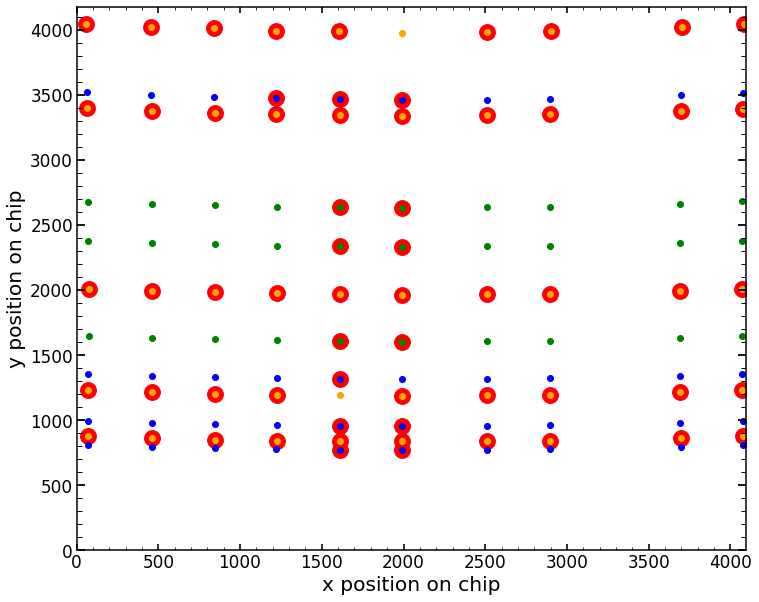

In [287]:
        plt.scatter(x_HgAr_observed, y_HgAr_observed,marker='o',color='red',s=250)
        plt.scatter(x_HgAr_0, y_HgAr_0,color='blue')
        plt.scatter(x_HgAr_1, y_HgAr_1,color='orange')
        plt.scatter(x_HgAr_05, y_HgAr_05,color='green')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')

## extension HgAr close=0.5, with correct secondary values 

In [36]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [38]:
finalHgAr_Feb2020_dataset.loc[7]

fiber                    2
xc                      72
yc                    2377
wavelength        826.6699
close                  0.5
lamp                  HgAr
xc_effective            72
second_offset        18.83
second_ratio        0.0043
second2_offset           0
second2_ratio            0
Name: 7, dtype: object

In [39]:
def remove(string): 
    return string.replace(" ", "")

In [40]:
list_of_HgAr_to_analyze=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']==0.5].index
list_of_HgAr_to_analyze

Int64Index([  5,   7,   8,  17,  19,  20,  29,  31,  32,  41,  43,  44,  53,
             55,  56,  65,  67,  68,  77,  79,  80,  89,  91,  92, 101, 103,
            104, 113, 115, 116],
           dtype='int64')

In [41]:
finalHgAr_Feb2020_dataset.loc[5][['second_offset','second_ratio']].values

array([-38.59, 0.008], dtype=object)

In [42]:
finalHgAr_Feb2020_dataset

fiber    xc    yc wavelength close  lamp xc_effective second_offset  \
0       2    69   808   690.9346     0  HgAr           69        -19.25   
1       2    69   875   696.7261     1  HgAr           69             0   
2       2    70   992   706.8989     0  HgAr           70         16.93   
3       2    71  1229  727.47876     1  HgAr           71             0   
4       2    72  1358   738.6248     0  HgAr           72        -13.14   
..    ...   ...   ...        ...   ...   ...          ...           ...   
115   650  4002  2379   826.6699   0.5  HgAr         4071         18.83   
116   650  4003  2681   852.4029   0.5  HgAr         4072        -14.26   
117   650  4008  3393   912.5693     1  HgAr         4077             0   
118   650  4009  3515   922.7301     0  HgAr         4078         22.44   
119   650  4016  4044   966.0642     1  HgAr         4085             0   

    second_ratio second2_offset second2_ratio  
0         0.0034          -40.7         0.006  
1              0              0             0  
2          0.268          28.33         0.088  
3              0              0             0  
4          0.011              0             0  
..           ...            ...           ...  
115       0.0043              0             0  
116        0.015              0             0  
117            0              0             0  
118        0.022         -13.14         0.011  
119            0              0             0  

[120 rows x 11 columns]

In [43]:
#MPI

list_of_HgAr_to_analyze=[  5,   7,   8,  17,  19,  20,  29,  31,  32,  41,  43,  44,  53,
             55,  56,  65,  67,  68,  77,  79,  80,  89,  91,  92, 101, 103,
            104, 113, 115, 116]

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T16S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, m05
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger16'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T16S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T17S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # p05,m3,p3,m15
    for obs in [21346+60,21346+18,21346+90,21346+36]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger17'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T17S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T18S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    #  p15, p35, m25, p25
    for obs in [21346+72,21346+96,21346+24,21346+84]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger18'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T18S'+str(single_spot)+'Mar20.sh \n')

file.close()

##################
##################
##################

## which images are avaliable - Mar06

In [132]:
date='Mar0620'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [133]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][94:len(Emcee3_Ne[i])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][94:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][94:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [134]:
if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_HgAr_images)>0:
    arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
    arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]
else:
    arranged_by_defocus_HgAr=[]
    arranged_by_spot_number_HgAr=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print(len(analyzed_HgAr_images),len(analyzed_Neon_images),len(analyzed_Kr_images))

875 654 374


In [135]:
analyzed_Kr_images

array([[21856,    18],
       [21844,     0],
       [21856,     5],
       [21850,    19],
       [21790,    16],
       [21802,    27],
       [21766,    26],
       [21760,    20],
       [21766,    21],
       [21766,     9],
       [21760,    27],
       [21838,    12],
       [21838,     9],
       [21844,    29],
       [21760,    32],
       [21826,    28],
       [21772,    16],
       [21808,    38],
       [21766,    34],
       [21766,    33],
       [21802,    32],
       [21826,     5],
       [21844,    18],
       [21826,     2],
       [21826,    19],
       [21772,    27],
       [21838,    36],
       [21772,    20],
       [21808,     5],
       [21790,    32],
       [21856,    29],
       [21850,     6],
       [21850,     1],
       [21850,    28],
       [21772,     8],
       [21778,     2],
       [21790,    27],
       [21778,    38],
       [21766,    10],
       [21778,     5],
       [21790,    20],
       [21760,    16],
       [21772,    32],
       [218

In [136]:
arranged_by_spot_number_Ne

array([[21604,     0],
       [21610,     0],
       [21598,     0],
       ...,
       [21640,    89],
       [21634,    89],
       [21562,    89]])

In [137]:
arranged_by_spot_number_HgAr

array([[21406,     1],
       [21436,     1],
       [21358,     1],
       ...,
       [21448,   119],
       [21364,   119],
       [21436,   119]])

In [138]:
unique_numbers_HgAr=np.unique(arranged_by_spot_number_HgAr[:,1])
unique_numbers_with_5_or_more_images_HgAr=[]
unique_numbers_with_4_or_less_images_HgAr=[]

unique_numbers_Ne=np.unique(arranged_by_spot_number_Ne[:,1])
unique_numbers_with_5_or_more_images_Ne=[]
unique_numbers_with_4_or_less_images_Ne=[]

unique_numbers_Kr=np.unique(arranged_by_spot_number_Kr[:,1])
unique_numbers_with_5_or_more_images_Kr=[]
unique_numbers_with_4_or_less_images_Kr=[]



for u in unique_numbers_HgAr:
    if np.sum(arranged_by_spot_number_HgAr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_HgAr.append(u)
    else:
        unique_numbers_with_4_or_less_images_HgAr.append(u)
        
        
for u in unique_numbers_Ne:
    if np.sum(arranged_by_spot_number_Ne[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Ne.append(u)
    else:
        unique_numbers_with_4_or_less_images_Ne.append(u)
        
    
for u in unique_numbers_Kr:
    if np.sum(arranged_by_spot_number_Kr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Kr.append(u)
    else:
        unique_numbers_with_4_or_less_images_Kr.append(u)

In [139]:
print(unique_numbers_with_5_or_more_images_HgAr)
print(unique_numbers_with_5_or_more_images_Ne) 
print(unique_numbers_with_5_or_more_images_Kr)
print('######')
print(unique_numbers_with_4_or_less_images_HgAr)
print(unique_numbers_with_4_or_less_images_Ne)
print(unique_numbers_with_4_or_less_images_Kr)

[1, 3, 5, 6, 7, 8, 9, 11, 13, 15, 17, 18, 19, 20, 21, 23, 25, 27, 29, 30, 31, 32, 33, 35, 37, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 73, 75, 77, 78, 79, 80, 81, 83, 85, 87, 89, 90, 91, 92, 93, 95, 97, 99, 101, 102, 103, 104, 105, 107, 109, 111, 113, 114, 115, 116, 117, 119]
[2, 3, 5, 6, 8, 11, 12, 14, 15, 17, 20, 21, 23, 24, 26, 29, 30, 31, 32, 33, 35, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 59, 60, 62, 63, 65, 66, 68, 69, 71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89]
[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38]
######
[44, 51, 64, 71]
[0, 7, 9, 16, 18, 25, 27, 28, 34, 36, 43, 52, 61, 70, 79, 88]
[]


## single image analysis 

In [140]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [141]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [142]:
date='Mar0620'
obs=21448
obs_int=int(obs)
single_number='54'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]


if str(finalArc.loc[int(single_number)]['close'])=='0' or str(finalArc.loc[int(single_number)]['close'])=='0.5':
    double_source=1
elif str(finalArc.loc[int(single_number)]['close'])=='-1':
    print('can not be analyzed!')
else:
    double_source=None    

double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
print([double_source,double_sources_positions_ratios])

p4
[None, array([0, 0], dtype=object)]


In [143]:
finalArc.loc[int(single_number)]

fiber                  339
xc                    1610
yc                    1968
wavelength        795.0522
close                    1
lamp                  HgAr
xc_effective          1610
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 54, dtype: object

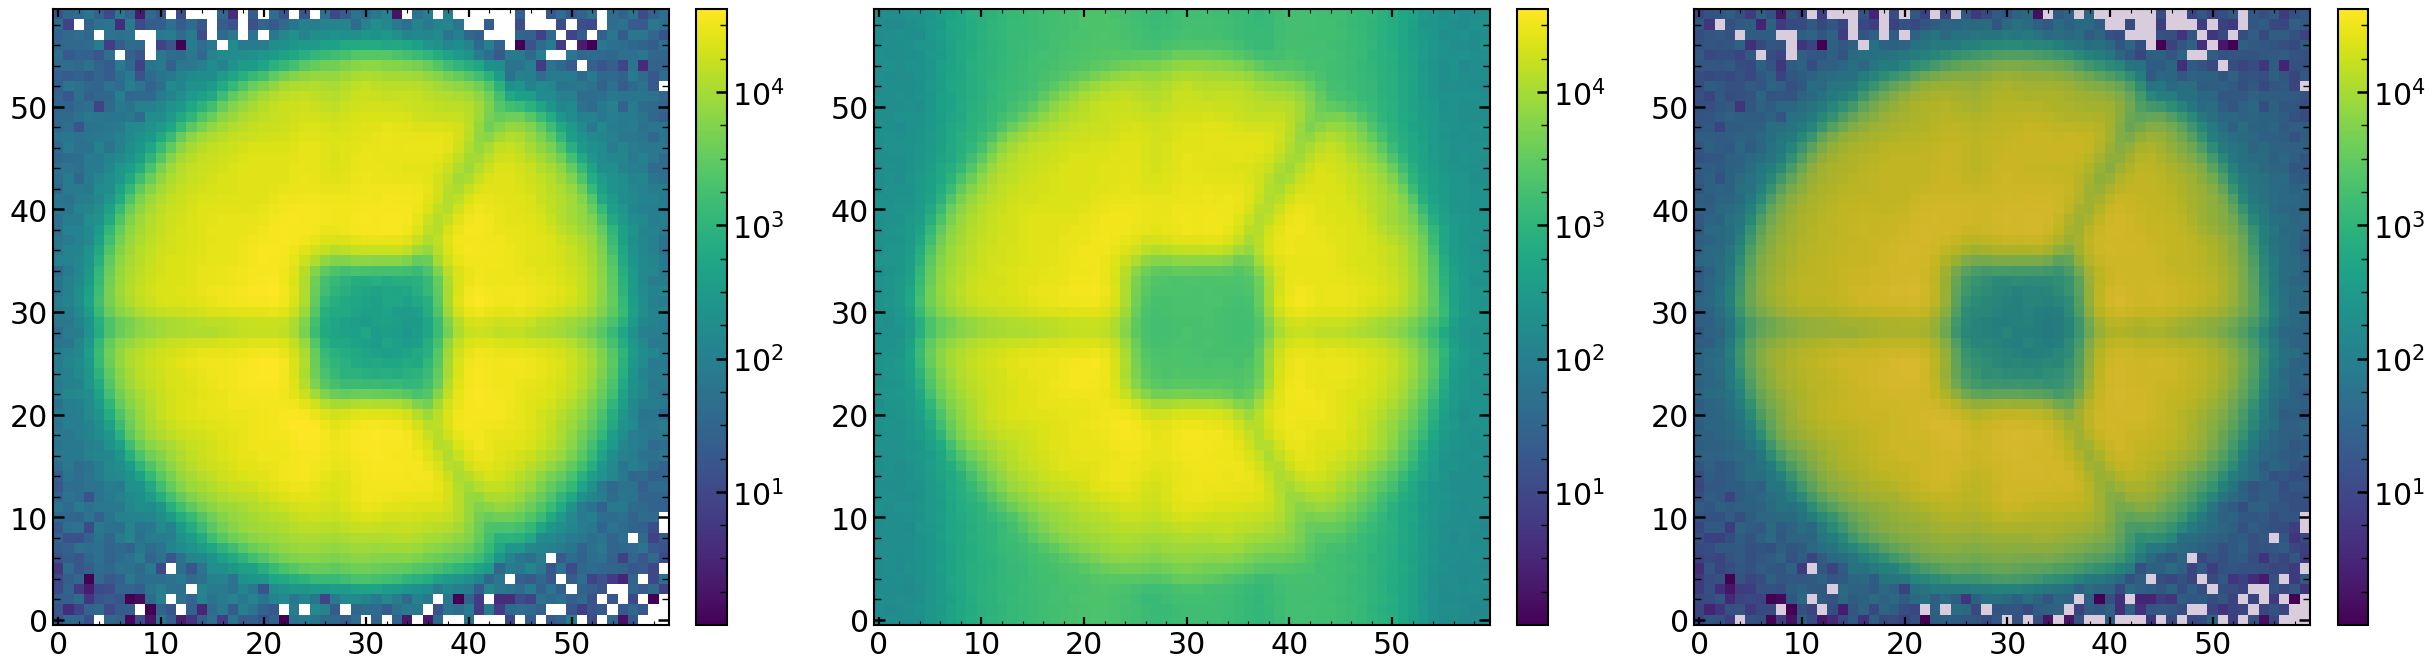

In [144]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [145]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain,like_min=single_analysis.create_likelihood()

(40, 400, 42) (252, 40, 42) (120, 400, 42) (252, 20, 42)
(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 95269.90270212169
minimal chi2 reduced is: 42.95211933972038


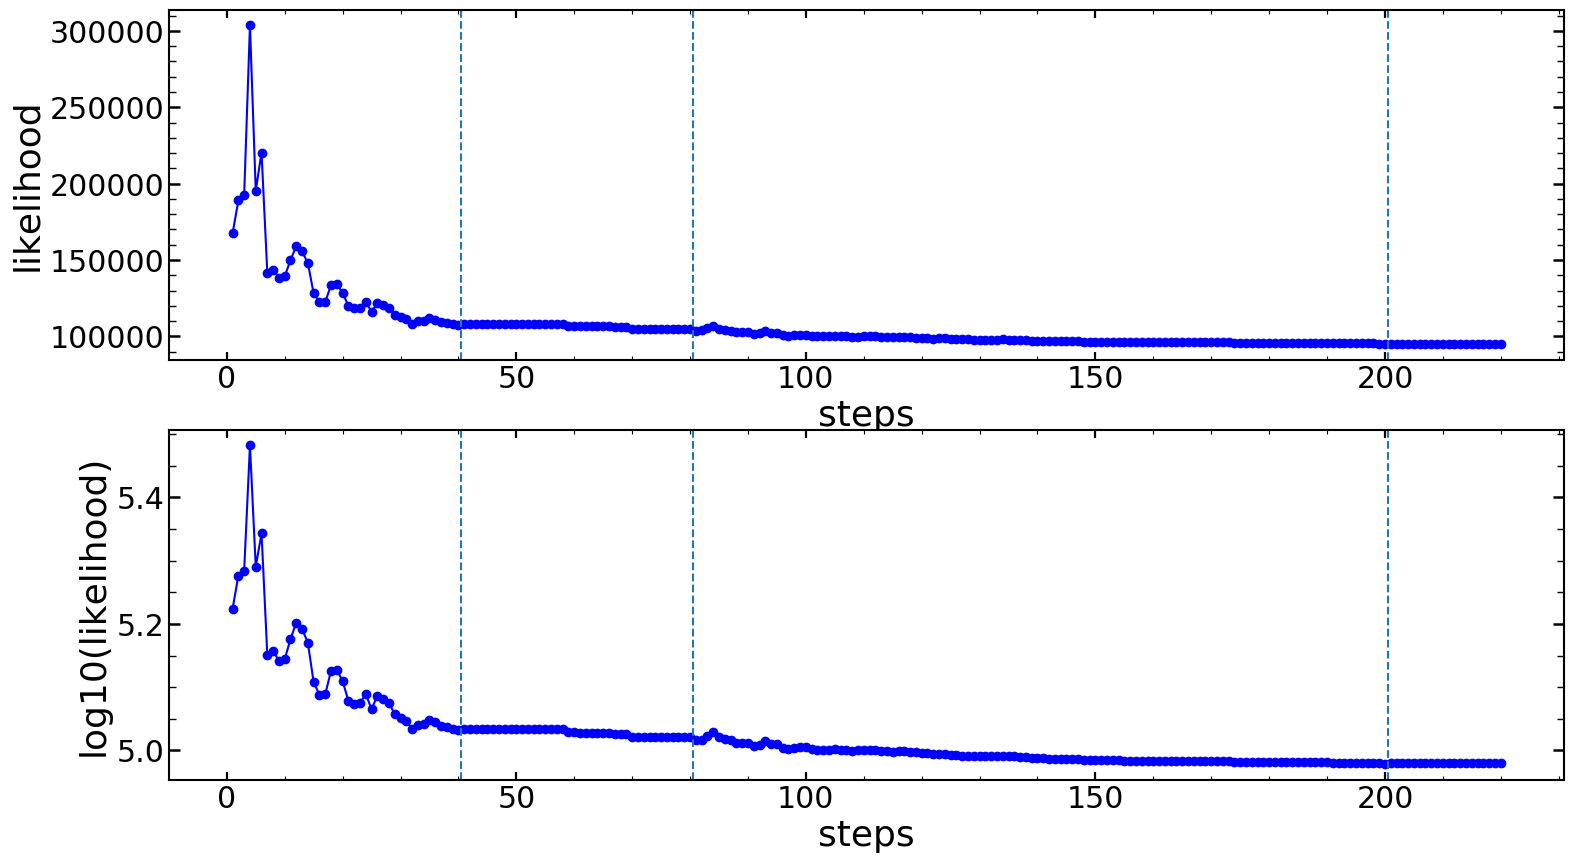

In [146]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(np.sum(len_of_chains[:1])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:2])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:3])+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(np.sum(len_of_chains[:1])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:2])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:3])+0.5,ls='--')

In [147]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=double_source,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,simulation_00=0)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (60, 60)
Top left pixel value of the science image is: 14.122875
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 176.80026
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [  -30.49164923     0.05951408     0.19973615     0.36054235
    -0.13497738    -0.07993521    -0.28362763    -0.44101458
    -0.0135619     -0.03381066     0.00122147     0.02909051
    -0.04314725    -0.02793242     0.01892038     0.00257491
    -0.03158388     0.01941581     0.0188642      0.66515231
     0.07712937    -0.03154815     0.01254935     0.05787224
     0.01586839     0.00000141     0.00000141     0.97418918
     0.94833902     0.02676724    -0.0461068      0.93733415
     0.06918683     0.87797709     1.01805882 

-96005.6324689141

In [148]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')


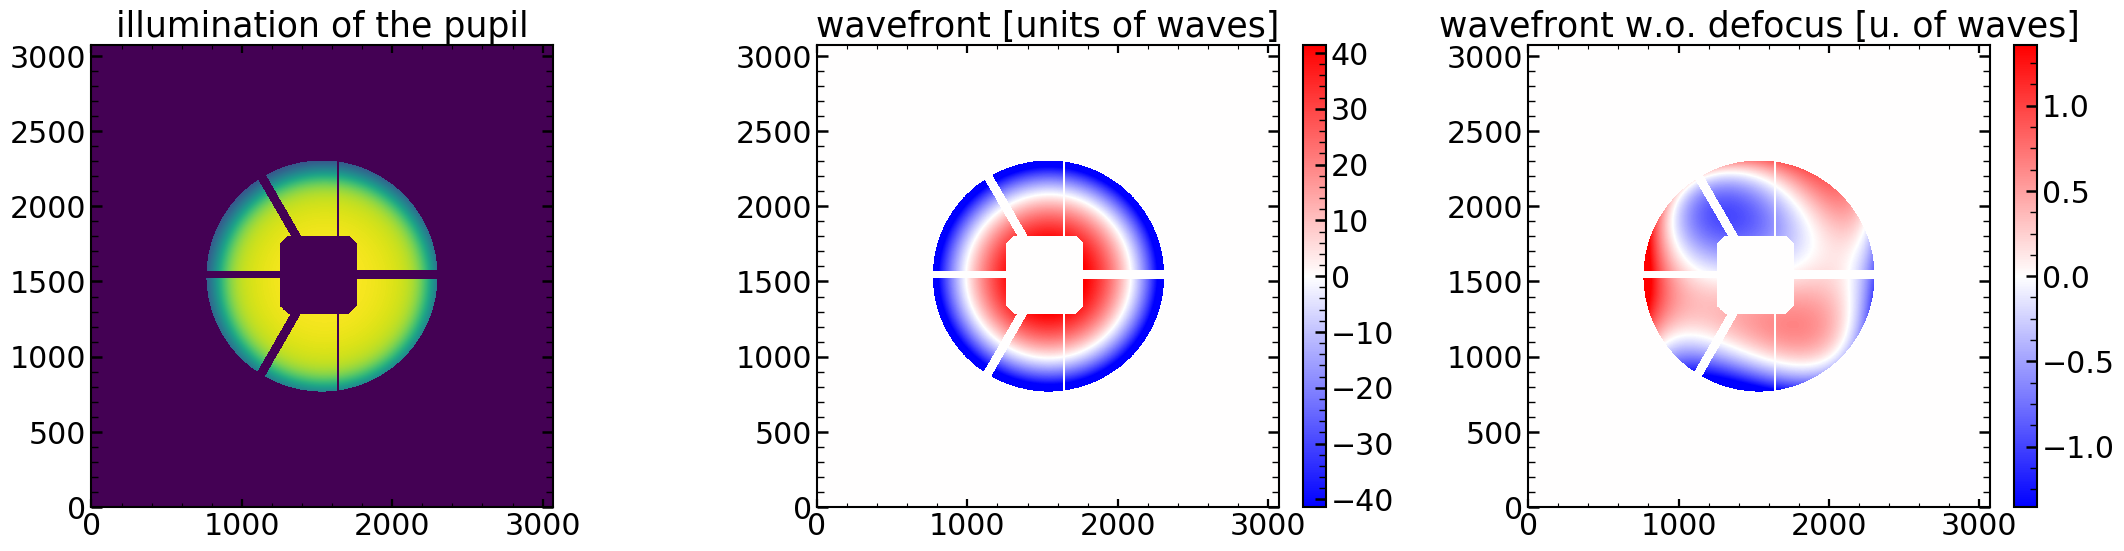

In [149]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 43.36085821957151
Abs of residual divided by total flux is: 0.04941715164562879
Abs of residual divided by largest value of a flux in the image is: 0.1330294781753651


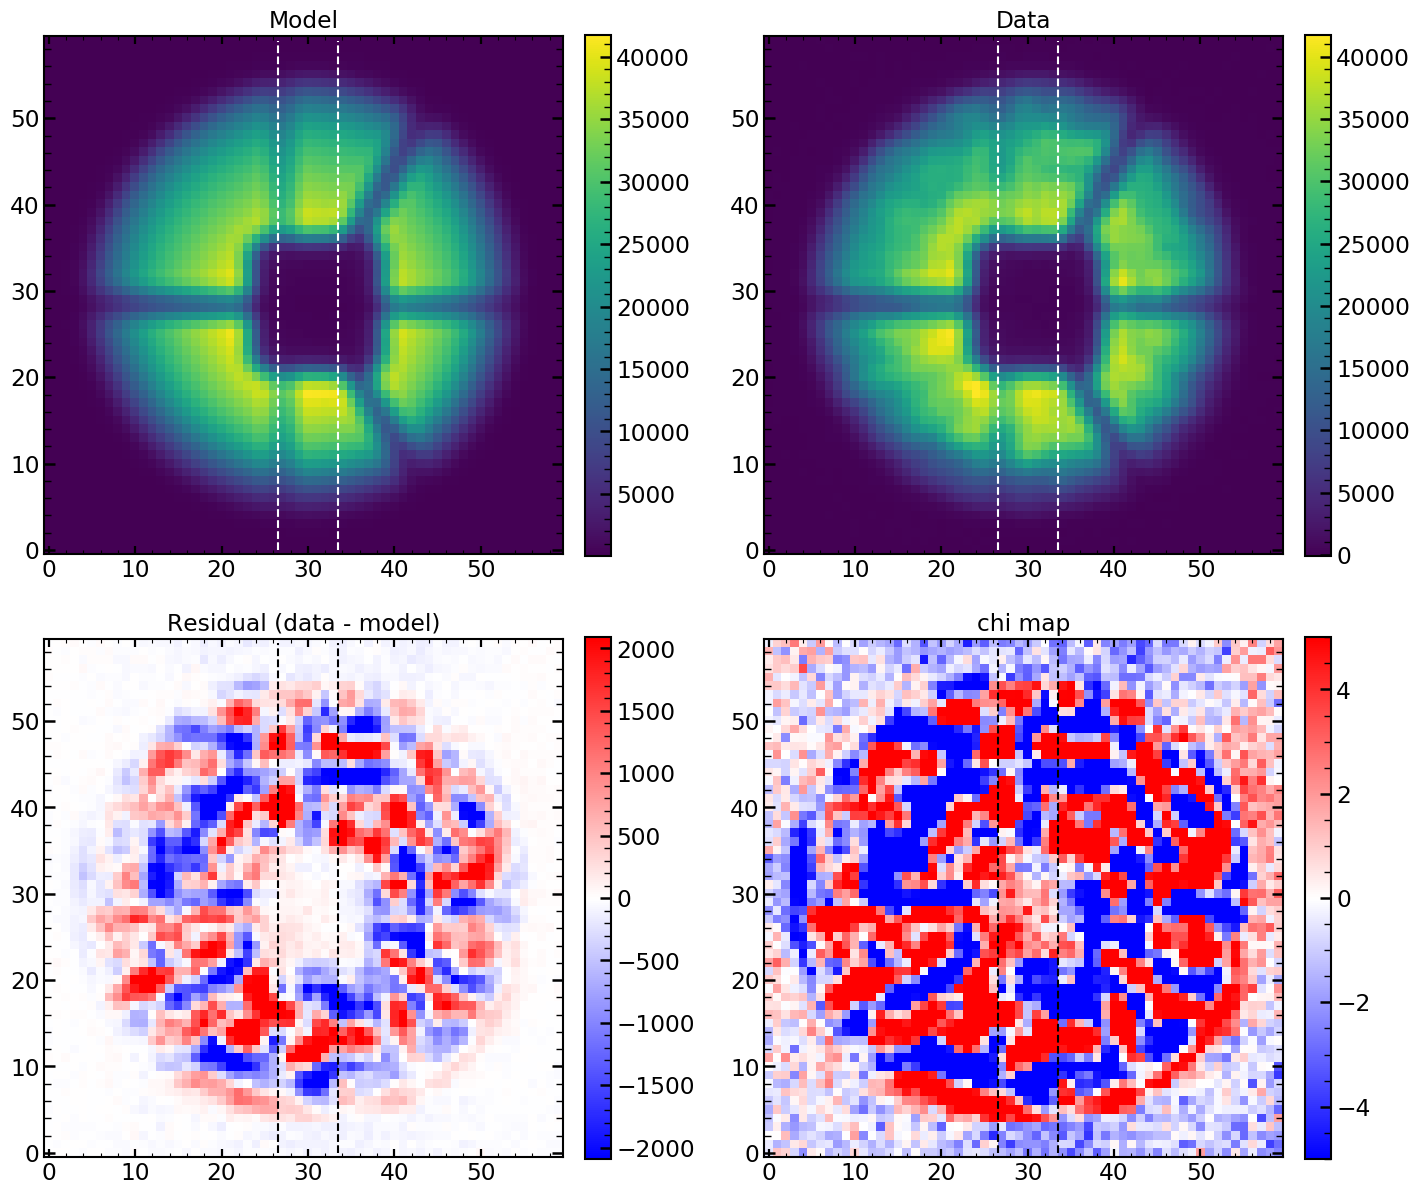

In [150]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

43.36085821957151
chi**2 reduced is: 43.36085821957151
Abs of residual divided by total flux is: 0.04941715164562879
Abs of residual divided by largest value of a flux in the image is: 0.1330294781753651


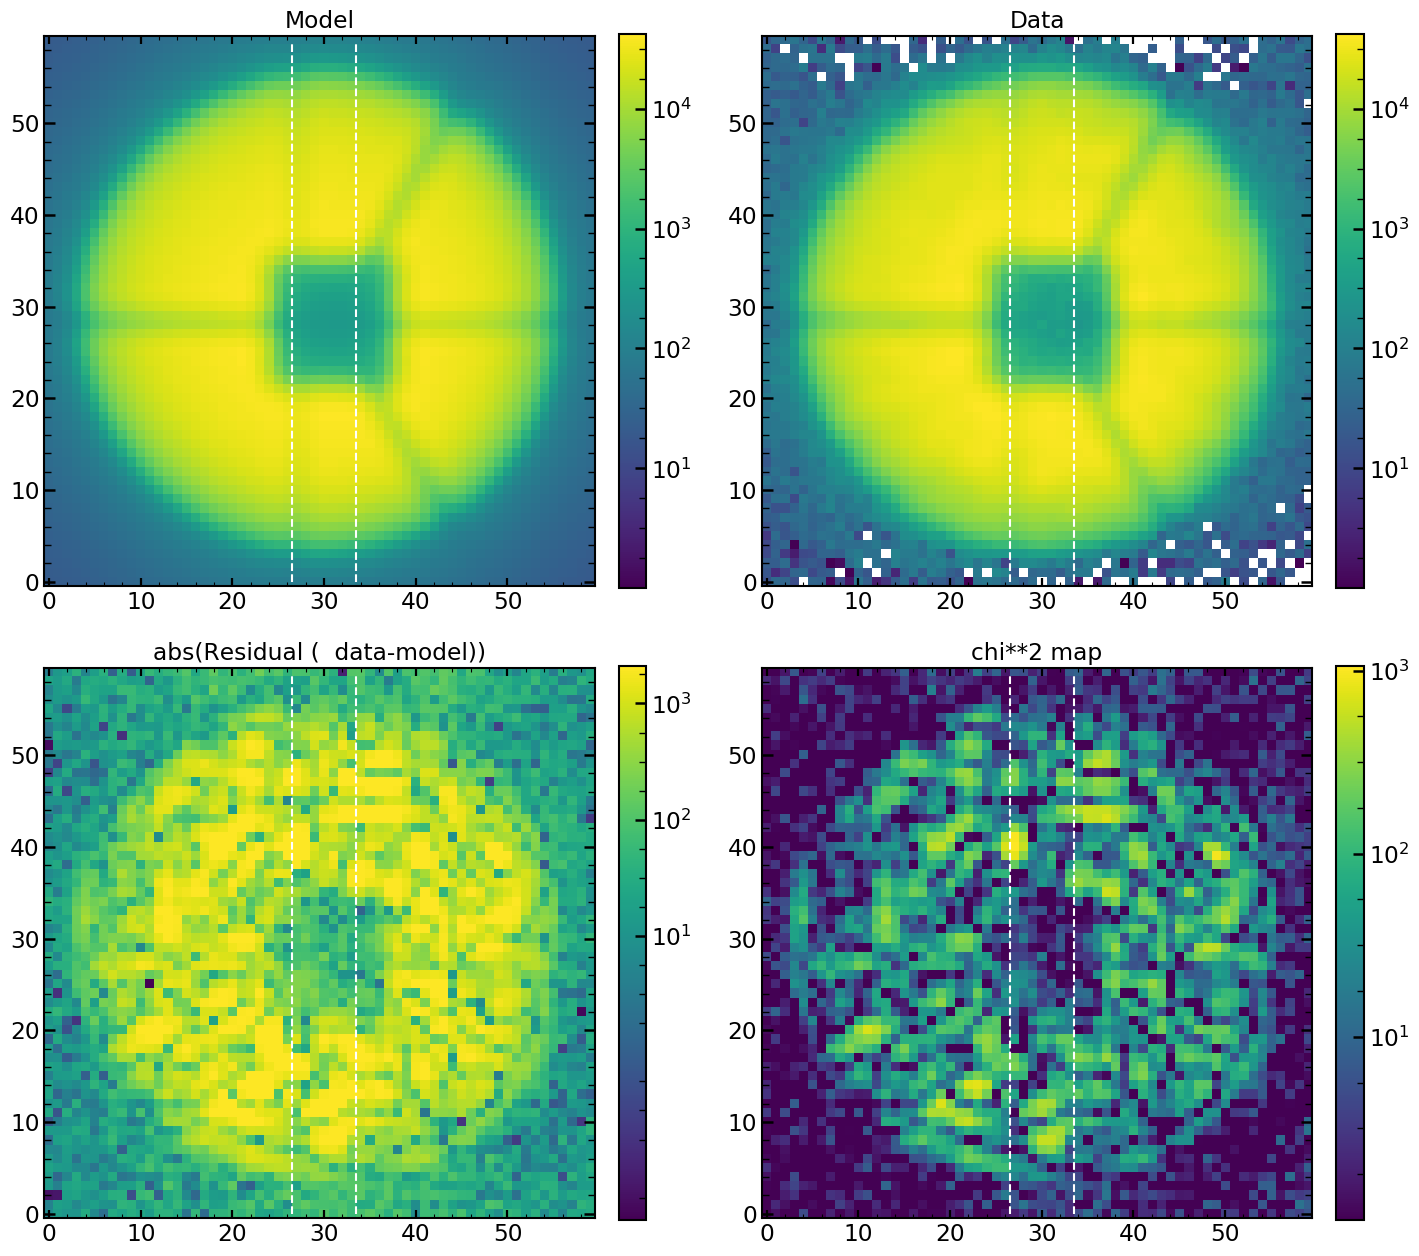

In [151]:
single_analysis.create_basic_comparison_plot_log()

43.36085821957151
chi**2 reduced is: 43.36085821957151
Abs of residual divided by total flux is: 0.04941715164562879
Abs of residual divided by largest value of a flux in the image is: 0.1330294781753651


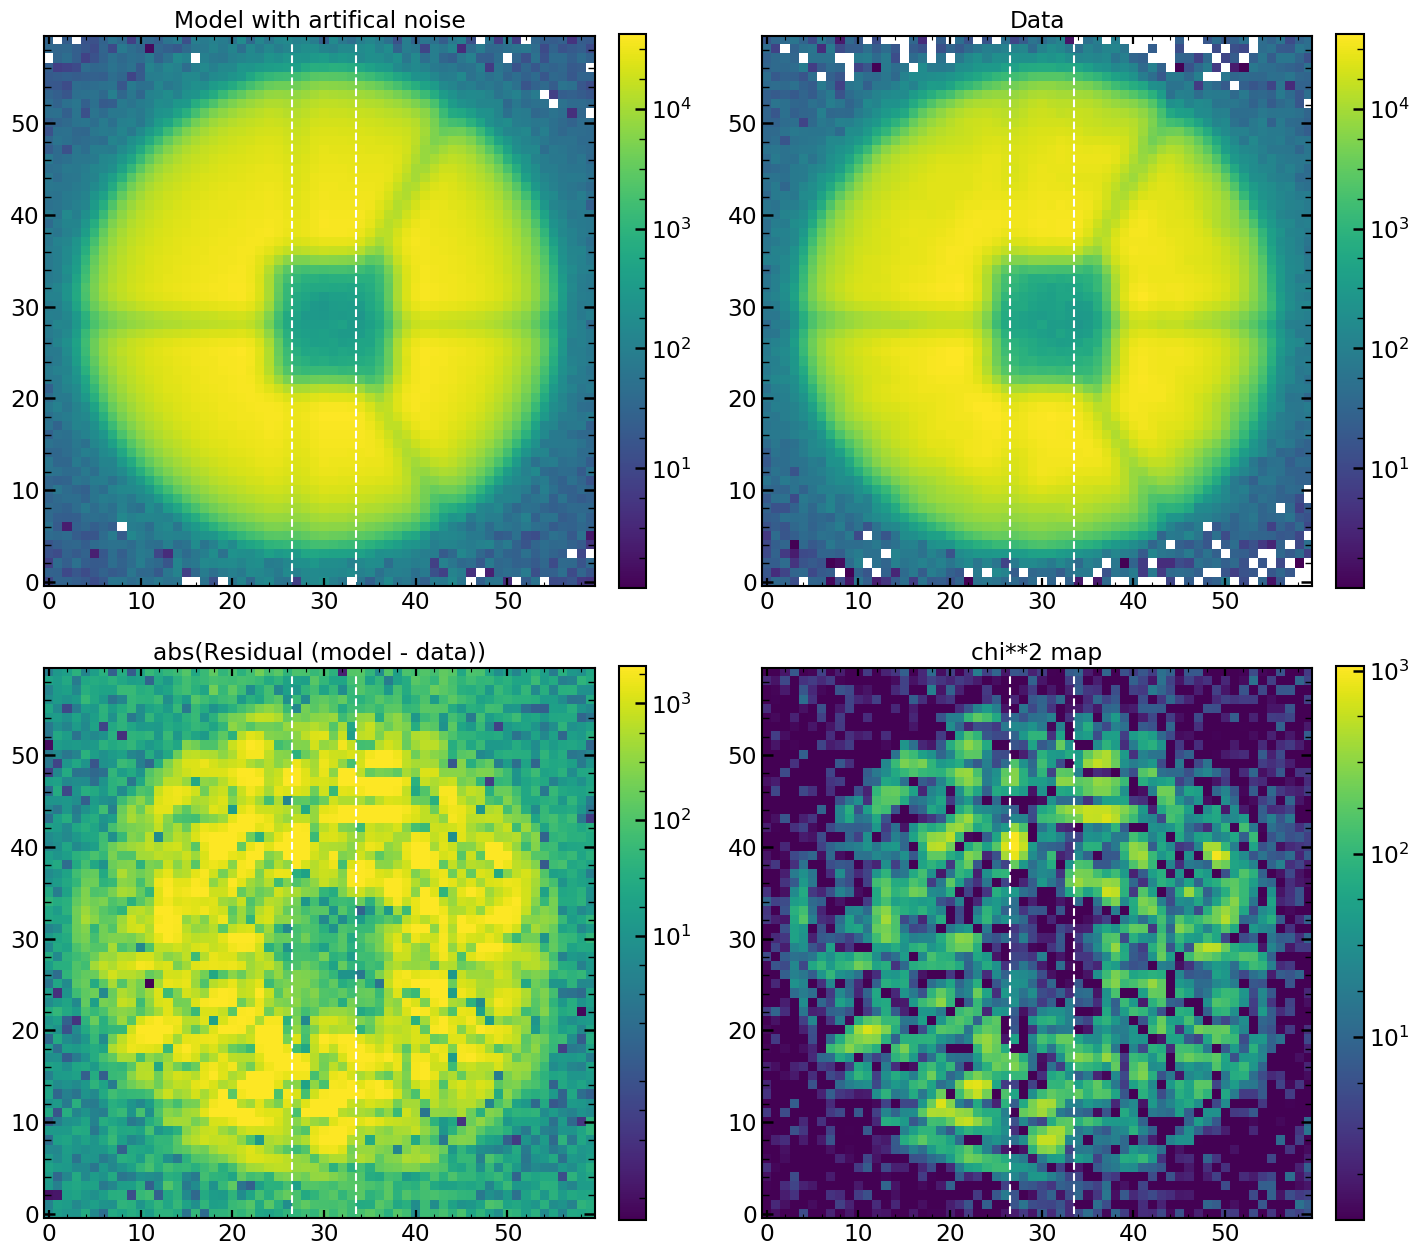

In [152]:
single_analysis.create_basic_comparison_plot_log_artifical()

## results everywhere 

In [153]:


unique_numbers_HgAr=np.unique(arranged_by_spot_number_HgAr[:,1])
unique_numbers_with_5_or_more_images_HgAr=[]
unique_numbers_with_4_or_less_images_HgAr=[]

unique_numbers_Ne=np.unique(arranged_by_spot_number_Ne[:,1])
unique_numbers_with_5_or_more_images_Ne=[]
unique_numbers_with_4_or_less_images_Ne=[]

unique_numbers_Kr=np.unique(arranged_by_spot_number_Kr[:,1])
unique_numbers_with_5_or_more_images_Kr=[]
unique_numbers_with_4_or_less_images_Kr=[]



for u in unique_numbers_HgAr:
    if np.sum(arranged_by_spot_number_HgAr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_HgAr.append(u)
    else:
        unique_numbers_with_4_or_less_images_HgAr.append(u)
        
        
for u in unique_numbers_Ne:
    if np.sum(arranged_by_spot_number_Ne[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Ne.append(u)
    else:
        unique_numbers_with_4_or_less_images_Ne.append(u)
        
    
for u in unique_numbers_Kr:
    if np.sum(arranged_by_spot_number_Kr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_Kr.append(u)
    else:
        unique_numbers_with_4_or_less_images_Kr.append(u)

In [154]:
print(unique_numbers_with_5_or_more_images_HgAr)
print(unique_numbers_with_5_or_more_images_Ne) 
print(unique_numbers_with_5_or_more_images_Kr)
print('######')
print(unique_numbers_with_4_or_less_images_HgAr)
print(unique_numbers_with_4_or_less_images_Ne)
print(unique_numbers_with_4_or_less_images_Kr)

[1, 3, 5, 6, 7, 8, 9, 11, 13, 15, 17, 18, 19, 20, 21, 23, 25, 27, 29, 30, 31, 32, 33, 35, 37, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 73, 75, 77, 78, 79, 80, 81, 83, 85, 87, 89, 90, 91, 92, 93, 95, 97, 99, 101, 102, 103, 104, 105, 107, 109, 111, 113, 114, 115, 116, 117, 119]
[2, 3, 5, 6, 8, 11, 12, 14, 15, 17, 20, 21, 23, 24, 26, 29, 30, 31, 32, 33, 35, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 59, 60, 62, 63, 65, 66, 68, 69, 71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89]
[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38]
######
[44, 51, 64, 71]
[0, 7, 9, 16, 18, 25, 27, 28, 34, 36, 43, 52, 61, 70, 79, 88]
[]


In [155]:
date='Mar0620'

results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalHgAr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                         index=finalHgAr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)
err_results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in unique_numbers_with_5_or_more_images_HgAr:
    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'HgAr',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,return_solution_at_05_0_05=None)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_HgAr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_HgAr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_HgAr[label[i]]=results_of_fit_many_HgAr[label[i]][np.abs(results_of_fit_many_HgAr[label[i]]['z4'])>0]

1 obs (Emcee3, defocus): 21352 (-4.0) is found!
1 obs (Emcee3, defocus): 21358 (-3.5) is found!
1 obs (Emcee3, defocus): 21364 (-3.0) is found!
1 obs (Emcee3, defocus): 21382 (-1.5) is found!
1 obs (Emcee3, defocus): 21400 (0) is found!
1 obs (Emcee3, defocus): 21400 (0) is found!
1 obs (Emcee3, defocus): 21406 (0.5) is found!
1 obs (Emcee3, defocus): 21418 (1.5) is found!
1 obs (Emcee3, defocus): 21436 (3.0) is found!
1 obs (Emcee3, defocus): 21442 (3.5) is found!
1 obs (Emcee3, defocus): 21448 (4) is found!
3 obs (Emcee3, defocus): 21352 (-4.0) is found!
3 obs (Emcee3, defocus): 21358 (-3.5) is found!
3 obs (Emcee3, defocus): 21364 (-3.0) is found!
3 obs (Emcee3, defocus): 21382 (-1.5) is found!
3 obs (Emcee3, defocus): 21400 (0) is found!
3 obs (Emcee3, defocus): 21400 (0) is found!
3 obs (Emcee3, defocus): 21406 (0.5) is found!
3 obs (Emcee3, defocus): 21418 (1.5) is found!
3 obs (Emcee3, defocus): 21436 (3.0) is found!
3 obs (Emcee3, defocus): 21442 (3.5) is found!
3 obs (Emcee3, 

23 obs (Emcee3, defocus): 21436 (3.0) is found!
23 obs (Emcee3, defocus): 21442 (3.5) is found!
23 obs (Emcee3, defocus): 21448 (4) is found!
25 obs (Emcee3, defocus): 21352 (-4.0) is found!
25 obs (Emcee3, defocus): 21358 (-3.5) is found!
25 obs (Emcee3, defocus): 21364 (-3.0) is found!
25 obs (Emcee3, defocus): 21382 (-1.5) is found!
25 obs (Emcee3, defocus): 21400 (0) is found!
25 obs (Emcee3, defocus): 21400 (0) is found!
25 obs (Emcee3, defocus): 21406 (0.5) is found!
25 obs (Emcee3, defocus): 21418 (1.5) is found!
25 obs (Emcee3, defocus): 21436 (3.0) is found!
25 obs (Emcee3, defocus): 21442 (3.5) is found!
25 obs (Emcee3, defocus): 21448 (4) is found!
27 obs (Emcee3, defocus): 21352 (-4.0) is found!
27 obs (Emcee3, defocus): 21358 (-3.5) is found!
27 obs (Emcee3, defocus): 21364 (-3.0) is found!
27 obs (Emcee3, defocus): 21382 (-1.5) is found!
27 obs (Emcee3, defocus): 21400 (0) is found!
27 obs (Emcee3, defocus): 21400 (0) is found!
27 obs (Emcee3, defocus): 21406 (0.5) is fou

48 obs (Emcee3, defocus): 21400 (0) is found!
48 obs (Emcee3, defocus): 21406 (0.5) is found!
48 obs (Emcee3, defocus): 21418 (1.5) is found!
48 obs (Emcee3, defocus): 21436 (3.0) is found!
48 obs (Emcee3, defocus): 21442 (3.5) is found!
48 obs (Emcee3, defocus): 21448 (4) is found!
49 obs (Emcee3, defocus): 21352 (-4.0) is found!
49 obs (Emcee3, defocus): 21358 (-3.5) is found!
49 obs (Emcee3, defocus): 21364 (-3.0) is found!
49 obs (Emcee3, defocus): 21382 (-1.5) is found!
49 obs (Emcee3, defocus): 21394 (-0.5) is found!
49 obs (Emcee3, defocus): 21400 (0) is found!
49 obs (Emcee3, defocus): 21400 (0) is found!
49 obs (Emcee3, defocus): 21406 (0.5) is found!
49 obs (Emcee3, defocus): 21418 (1.5) is found!
49 obs (Emcee3, defocus): 21436 (3.0) is found!
49 obs (Emcee3, defocus): 21442 (3.5) is found!
49 obs (Emcee3, defocus): 21448 (4) is found!
50 obs (Emcee3, defocus): 21352 (-4.0) is found!
50 obs (Emcee3, defocus): 21358 (-3.5) is found!
50 obs (Emcee3, defocus): 21364 (-3.0) is f

63 obs (Emcee3, defocus): 21436 (3.0) is found!
63 obs (Emcee3, defocus): 21442 (3.5) is found!
63 obs (Emcee3, defocus): 21448 (4) is found!
65 obs (Emcee3, defocus): 21352 (-4.0) is found!
65 obs (Emcee3, defocus): 21358 (-3.5) is found!
65 obs (Emcee3, defocus): 21364 (-3.0) is found!
65 obs (Emcee3, defocus): 21370 (-2.5) is found!
65 obs (Emcee3, defocus): 21382 (-1.5) is found!
65 obs (Emcee3, defocus): 21400 (0) is found!
65 obs (Emcee3, defocus): 21400 (0) is found!
65 obs (Emcee3, defocus): 21406 (0.5) is found!
65 obs (Emcee3, defocus): 21418 (1.5) is found!
65 obs (Emcee3, defocus): 21430 (2.5) is found!
65 obs (Emcee3, defocus): 21436 (3.0) is found!
65 obs (Emcee3, defocus): 21442 (3.5) is found!
65 obs (Emcee3, defocus): 21448 (4) is found!
66 obs (Emcee3, defocus): 21352 (-4.0) is found!
66 obs (Emcee3, defocus): 21358 (-3.5) is found!
66 obs (Emcee3, defocus): 21364 (-3.0) is found!
66 obs (Emcee3, defocus): 21382 (-1.5) is found!
66 obs (Emcee3, defocus): 21400 (0) is 

87 obs (Emcee3, defocus): 21406 (0.5) is found!
87 obs (Emcee3, defocus): 21418 (1.5) is found!
87 obs (Emcee3, defocus): 21436 (3.0) is found!
87 obs (Emcee3, defocus): 21442 (3.5) is found!
87 obs (Emcee3, defocus): 21448 (4) is found!
89 obs (Emcee3, defocus): 21364 (-3.0) is found!
89 obs (Emcee3, defocus): 21370 (-2.5) is found!
89 obs (Emcee3, defocus): 21382 (-1.5) is found!
89 obs (Emcee3, defocus): 21406 (0.5) is found!
89 obs (Emcee3, defocus): 21418 (1.5) is found!
89 obs (Emcee3, defocus): 21430 (2.5) is found!
89 obs (Emcee3, defocus): 21436 (3.0) is found!
89 obs (Emcee3, defocus): 21442 (3.5) is found!
90 obs (Emcee3, defocus): 21352 (-4.0) is found!
90 obs (Emcee3, defocus): 21358 (-3.5) is found!
90 obs (Emcee3, defocus): 21364 (-3.0) is found!
90 obs (Emcee3, defocus): 21382 (-1.5) is found!
90 obs (Emcee3, defocus): 21400 (0) is found!
90 obs (Emcee3, defocus): 21400 (0) is found!
90 obs (Emcee3, defocus): 21406 (0.5) is found!
90 obs (Emcee3, defocus): 21418 (1.5) i

113 obs (Emcee3, defocus): 21382 (-1.5) is found!
113 obs (Emcee3, defocus): 21400 (0) is found!
113 obs (Emcee3, defocus): 21400 (0) is found!
113 obs (Emcee3, defocus): 21406 (0.5) is found!
113 obs (Emcee3, defocus): 21418 (1.5) is found!
113 obs (Emcee3, defocus): 21430 (2.5) is found!
113 obs (Emcee3, defocus): 21436 (3.0) is found!
113 obs (Emcee3, defocus): 21442 (3.5) is found!
113 obs (Emcee3, defocus): 21448 (4) is found!
114 obs (Emcee3, defocus): 21352 (-4.0) is found!
114 obs (Emcee3, defocus): 21358 (-3.5) is found!
114 obs (Emcee3, defocus): 21364 (-3.0) is found!
114 obs (Emcee3, defocus): 21382 (-1.5) is found!
114 obs (Emcee3, defocus): 21400 (0) is found!
114 obs (Emcee3, defocus): 21400 (0) is found!
114 obs (Emcee3, defocus): 21406 (0.5) is found!
114 obs (Emcee3, defocus): 21418 (1.5) is found!
114 obs (Emcee3, defocus): 21436 (3.0) is found!
114 obs (Emcee3, defocus): 21442 (3.5) is found!
114 obs (Emcee3, defocus): 21448 (4) is found!
115 obs (Emcee3, defocus): 

In [156]:
results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)


results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

for single_number in unique_numbers_with_5_or_more_images_Ne:

    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,return_solution_at_05_0_05=None)    
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Ne[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Ne[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]

2 obs (Emcee3, defocus): 21556 (-4.0) is found!
2 obs (Emcee3, defocus): 21562 (-3.5) is found!
2 obs (Emcee3, defocus): 21568 (-3.0) is found!
2 obs (Emcee3, defocus): 21574 (-2.5) is found!
2 obs (Emcee3, defocus): 21586 (-1.5) is found!
2 obs (Emcee3, defocus): 21598 (-0.5) is found!
2 obs (Emcee3, defocus): 21604 (0) is found!
2 obs (Emcee3, defocus): 21604 (0) is found!
2 obs (Emcee3, defocus): 21610 (0.5) is found!
2 obs (Emcee3, defocus): 21622 (1.5) is found!
2 obs (Emcee3, defocus): 21634 (2.5) is found!
2 obs (Emcee3, defocus): 21640 (3.0) is found!
2 obs (Emcee3, defocus): 21646 (3.5) is found!
2 obs (Emcee3, defocus): 21652 (4) is found!
3 obs (Emcee3, defocus): 21556 (-4.0) is found!
3 obs (Emcee3, defocus): 21562 (-3.5) is found!
3 obs (Emcee3, defocus): 21568 (-3.0) is found!
3 obs (Emcee3, defocus): 21586 (-1.5) is found!
3 obs (Emcee3, defocus): 21598 (-0.5) is found!
3 obs (Emcee3, defocus): 21604 (0) is found!
3 obs (Emcee3, defocus): 21604 (0) is found!
3 obs (Emcee

26 obs (Emcee3, defocus): 21610 (0.5) is found!
26 obs (Emcee3, defocus): 21646 (3.5) is found!
26 obs (Emcee3, defocus): 21652 (4) is found!
29 obs (Emcee3, defocus): 21556 (-4.0) is found!
29 obs (Emcee3, defocus): 21562 (-3.5) is found!
29 obs (Emcee3, defocus): 21568 (-3.0) is found!
29 obs (Emcee3, defocus): 21574 (-2.5) is found!
29 obs (Emcee3, defocus): 21586 (-1.5) is found!
29 obs (Emcee3, defocus): 21598 (-0.5) is found!
29 obs (Emcee3, defocus): 21604 (0) is found!
29 obs (Emcee3, defocus): 21604 (0) is found!
29 obs (Emcee3, defocus): 21610 (0.5) is found!
29 obs (Emcee3, defocus): 21622 (1.5) is found!
29 obs (Emcee3, defocus): 21634 (2.5) is found!
29 obs (Emcee3, defocus): 21640 (3.0) is found!
29 obs (Emcee3, defocus): 21646 (3.5) is found!
29 obs (Emcee3, defocus): 21652 (4) is found!
30 obs (Emcee3, defocus): 21598 (-0.5) is found!
30 obs (Emcee3, defocus): 21604 (0) is found!
30 obs (Emcee3, defocus): 21604 (0) is found!
30 obs (Emcee3, defocus): 21610 (0.5) is foun

51 obs (Emcee3, defocus): 21556 (-4.0) is found!
51 obs (Emcee3, defocus): 21562 (-3.5) is found!
51 obs (Emcee3, defocus): 21568 (-3.0) is found!
51 obs (Emcee3, defocus): 21574 (-2.5) is found!
51 obs (Emcee3, defocus): 21586 (-1.5) is found!
51 obs (Emcee3, defocus): 21598 (-0.5) is found!
51 obs (Emcee3, defocus): 21604 (0) is found!
51 obs (Emcee3, defocus): 21604 (0) is found!
51 obs (Emcee3, defocus): 21610 (0.5) is found!
51 obs (Emcee3, defocus): 21622 (1.5) is found!
51 obs (Emcee3, defocus): 21634 (2.5) is found!
51 obs (Emcee3, defocus): 21640 (3.0) is found!
51 obs (Emcee3, defocus): 21646 (3.5) is found!
51 obs (Emcee3, defocus): 21652 (4) is found!
53 obs (Emcee3, defocus): 21556 (-4.0) is found!
53 obs (Emcee3, defocus): 21562 (-3.5) is found!
53 obs (Emcee3, defocus): 21568 (-3.0) is found!
53 obs (Emcee3, defocus): 21574 (-2.5) is found!
53 obs (Emcee3, defocus): 21586 (-1.5) is found!
53 obs (Emcee3, defocus): 21598 (-0.5) is found!
53 obs (Emcee3, defocus): 21604 (0

72 obs (Emcee3, defocus): 21610 (0.5) is found!
72 obs (Emcee3, defocus): 21634 (2.5) is found!
72 obs (Emcee3, defocus): 21640 (3.0) is found!
72 obs (Emcee3, defocus): 21646 (3.5) is found!
72 obs (Emcee3, defocus): 21652 (4) is found!
74 obs (Emcee3, defocus): 21556 (-4.0) is found!
74 obs (Emcee3, defocus): 21562 (-3.5) is found!
74 obs (Emcee3, defocus): 21568 (-3.0) is found!
74 obs (Emcee3, defocus): 21574 (-2.5) is found!
74 obs (Emcee3, defocus): 21586 (-1.5) is found!
74 obs (Emcee3, defocus): 21598 (-0.5) is found!
74 obs (Emcee3, defocus): 21604 (0) is found!
74 obs (Emcee3, defocus): 21604 (0) is found!
74 obs (Emcee3, defocus): 21610 (0.5) is found!
74 obs (Emcee3, defocus): 21622 (1.5) is found!
74 obs (Emcee3, defocus): 21634 (2.5) is found!
74 obs (Emcee3, defocus): 21640 (3.0) is found!
74 obs (Emcee3, defocus): 21646 (3.5) is found!
74 obs (Emcee3, defocus): 21652 (4) is found!
75 obs (Emcee3, defocus): 21556 (-4.0) is found!
75 obs (Emcee3, defocus): 21562 (-3.5) is

In [157]:
results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(results_of_fit_many_single_defocus_Kr)
err_results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Kr)


results_of_fit_many_Kr = {'m4': results_of_fit_many_single_defocus_Kr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Kr_pd.copy()}

for single_number in unique_numbers_with_5_or_more_images_Kr:
        
    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'Kr',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,return_solution_at_05_0_05=None)   
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Kr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Kr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Kr[label[i]]=results_of_fit_many_Kr[label[i]][np.abs(results_of_fit_many_Kr[label[i]]['z4'])>0]

0 obs (Emcee3, defocus): 21760 (-4.0) is found!
0 obs (Emcee3, defocus): 21766 (-3.5) is found!
0 obs (Emcee3, defocus): 21772 (-3.0) is found!
0 obs (Emcee3, defocus): 21778 (-2.5) is found!
0 obs (Emcee3, defocus): 21790 (-1.5) is found!
0 obs (Emcee3, defocus): 21808 (0) is found!
0 obs (Emcee3, defocus): 21808 (0) is found!
0 obs (Emcee3, defocus): 21814 (0.5) is found!
0 obs (Emcee3, defocus): 21826 (1.5) is found!
0 obs (Emcee3, defocus): 21838 (2.5) is found!
0 obs (Emcee3, defocus): 21844 (3.0) is found!
0 obs (Emcee3, defocus): 21850 (3.5) is found!
0 obs (Emcee3, defocus): 21856 (4) is found!
1 obs (Emcee3, defocus): 21760 (-4.0) is found!
1 obs (Emcee3, defocus): 21766 (-3.5) is found!
1 obs (Emcee3, defocus): 21772 (-3.0) is found!
1 obs (Emcee3, defocus): 21778 (-2.5) is found!
1 obs (Emcee3, defocus): 21790 (-1.5) is found!
1 obs (Emcee3, defocus): 21802 (-0.5) is found!
1 obs (Emcee3, defocus): 21808 (0) is found!
1 obs (Emcee3, defocus): 21808 (0) is found!
1 obs (Emcee

17 obs (Emcee3, defocus): 21790 (-1.5) is found!
17 obs (Emcee3, defocus): 21808 (0) is found!
17 obs (Emcee3, defocus): 21808 (0) is found!
17 obs (Emcee3, defocus): 21814 (0.5) is found!
17 obs (Emcee3, defocus): 21826 (1.5) is found!
17 obs (Emcee3, defocus): 21844 (3.0) is found!
17 obs (Emcee3, defocus): 21856 (4) is found!
18 obs (Emcee3, defocus): 21760 (-4.0) is found!
18 obs (Emcee3, defocus): 21772 (-3.0) is found!
18 obs (Emcee3, defocus): 21790 (-1.5) is found!
18 obs (Emcee3, defocus): 21808 (0) is found!
18 obs (Emcee3, defocus): 21808 (0) is found!
18 obs (Emcee3, defocus): 21814 (0.5) is found!
18 obs (Emcee3, defocus): 21826 (1.5) is found!
18 obs (Emcee3, defocus): 21844 (3.0) is found!
18 obs (Emcee3, defocus): 21856 (4) is found!
19 obs (Emcee3, defocus): 21760 (-4.0) is found!
19 obs (Emcee3, defocus): 21766 (-3.5) is found!
19 obs (Emcee3, defocus): 21772 (-3.0) is found!
19 obs (Emcee3, defocus): 21790 (-1.5) is found!
19 obs (Emcee3, defocus): 21808 (0) is found

33 obs (Emcee3, defocus): 21772 (-3.0) is found!
33 obs (Emcee3, defocus): 21778 (-2.5) is found!
33 obs (Emcee3, defocus): 21790 (-1.5) is found!
33 obs (Emcee3, defocus): 21808 (0) is found!
33 obs (Emcee3, defocus): 21808 (0) is found!
33 obs (Emcee3, defocus): 21814 (0.5) is found!
33 obs (Emcee3, defocus): 21826 (1.5) is found!
33 obs (Emcee3, defocus): 21838 (2.5) is found!
33 obs (Emcee3, defocus): 21844 (3.0) is found!
33 obs (Emcee3, defocus): 21850 (3.5) is found!
33 obs (Emcee3, defocus): 21856 (4) is found!
34 obs (Emcee3, defocus): 21760 (-4.0) is found!
34 obs (Emcee3, defocus): 21766 (-3.5) is found!
34 obs (Emcee3, defocus): 21772 (-3.0) is found!
34 obs (Emcee3, defocus): 21778 (-2.5) is found!
34 obs (Emcee3, defocus): 21790 (-1.5) is found!
34 obs (Emcee3, defocus): 21802 (-0.5) is found!
34 obs (Emcee3, defocus): 21808 (0) is found!
34 obs (Emcee3, defocus): 21808 (0) is found!
34 obs (Emcee3, defocus): 21814 (0.5) is found!
34 obs (Emcee3, defocus): 21826 (1.5) is 

In [158]:
labels_with_data_HgAr=[]
for i in range(len(label[:])):
    if len(results_of_fit_many_HgAr[label[i]])>5:
        labels_with_data_HgAr.append(i)
        
labels_with_data_Ne=[]
for i in range(len(label[:])):
    if len(results_of_fit_many_Ne[label[i]])>5:
        labels_with_data_Ne.append(i)
   
labels_with_data_Kr=[]
for i in range(len(label[:])):
    if len(results_of_fit_many_Kr[label[i]])>5:
        labels_with_data_Kr.append(i)

labels_with_data=np.unique(labels_with_data_HgAr+labels_with_data_Ne+labels_with_data_Kr)

In [159]:
pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Kr,f, protocol=pickle.HIGHEST_PROTOCOL)

In [160]:
# plot the results of the interpolation
zMax=22
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Mar0620'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed

for j in tqdm(labels_with_data):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        # take values for Krypton        
        x_Kr=finalKr.loc[results_of_fit_many_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Kr=finalKr.loc[results_of_fit_many_Kr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Kr=np.array(results_of_fit_many_Kr[label[j]][descriptions[i]])        
        #x=x_HgAr
        #y=y_HgAr  
        #colors=values_HgAr
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne,x_Kr))
        y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
        colors= np.concatenate((values_HgAr,values_Ne,values_Kr))
        

        
        if zMax==11:

            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 

            # limits for all other parameters    
            if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(max(colors)-median_color)
                low_limit=np.abs(min(colors)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[31,32])[0] == True:   
                max_colors=10
                min_colors=1

        else:
            # limits of color for z5-z11
            if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=1
                    min_colors=-1 
                    
            # limits of color for z12-z22
            if np.in1d([i],[8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                    abs_max_colors=max(np.abs(colors))
                    max_colors=0.25
                    min_colors=-0.25

            # limits for all other parameters    
            if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
                median_color=np.median(colors)
                up_limit=np.abs(np.quantile(colors,0.9)-median_color)
                low_limit=np.abs(np.quantile(colors,0.1)-median_color)
                max_dif=np.max([low_limit,up_limit])
                min_dif=np.min([low_limit,up_limit])
                max_colors=median_color+(min_dif+max_dif)/2
                min_colors=median_color-(min_dif+max_dif)/2

            #'chi2, chi2max'
            if np.in1d([i],[41,42])[0] == True:   
                max_colors=10
                min_colors=1  

        plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='o')
        plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='s')
        plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='p')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(date)+' / '+': '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 15/15 [06:48<00:00, 27.26s/it]


<Figure size 1200x1000 with 0 Axes>

## Creation of prediction for the fit and verification

In [162]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [163]:
from scipy.optimize import curve_fit

def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]


def funcz4(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1,c2):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+c2*x[2]**2+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m15','m05','0d','0','p05','p15','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0d','0','p05']
label_focus_focus=['0']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [164]:
results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalHgAr.index,columns=columns22_analysis)
results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)

results_of_fit_many_single_defocus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalKr.index,columns=columns22_analysis)
results_of_fit_many_single_defocus_Kr_pd=pd.DataFrame(results_of_fit_many_single_defocus_Kr)

In [165]:
results_of_fit_many_interpolation_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

results_of_fit_many_interpolation_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

results_of_fit_many_interpolation_Kr = {'m4': results_of_fit_many_single_defocus_Kr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Kr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Kr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Kr_pd.copy()}


# find coordinates of all spots on the detector
all_x_HgAr=finalHgAr['xc_effective']
all_y_HgAr=finalHgAr['yc']

all_x_Ne=finalNe['xc_effective']
all_y_Ne=finalNe['yc']

all_x_Kr=finalKr['xc_effective']
all_y_Kr=finalKr['yc']

# detector is 4096 pixels in x direction and 4176 in y direction
all_x_HgAr_in_respect_to_center=all_x_HgAr-int((4096+69)/2)
all_y_HgAr_in_respect_to_center=all_y_HgAr-int(4176/2)

all_x_Ne_in_respect_to_center=all_x_Ne-int((4096+69)/2)
all_y_Ne_in_respect_to_center=all_y_Ne-int(4176/2)

all_x_Kr_in_respect_to_center=all_x_Kr-int((4096+69)/2)
all_y_Kr_in_respect_to_center=all_y_Kr-int(4176/2)

In [166]:
zMax=22

if zMax==11:
    labels_cont=['z5','z6','z7','z8','z9','z10','z11','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx',\
                 'radiometricEffect','radiometricExponent','x_ilum','y_ilum']
else:
    labels_cont=['z5','z6','z7','z8','z9','z10','z11','z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22','hscFrac','effective_radius_illumination',\
                 'strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx','radiometricEffect','radiometricExponent','x_ilum','y_ilum']


single_parameter=[]
for j in labels_cont:
    for i in label_defocus:

        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        # fibers 2 and 3 are too close and remove them from analysis - this is only the case for Feb data
        #single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        #single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  
        
        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        #single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        #single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)          
        
        # no Kr data avaliable
        #single_selection_Kr_index=results_of_fit_many_Kr[i][j].index.values
        
        #########
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]      
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]    
        #single_selection_Kr=results_of_fit_many_Kr[i][j][single_selection_Kr_index]   
        #########
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values

        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values

        #single_selection_x_Kr=all_x_Kr_in_respect_to_center[single_selection_Kr.index.astype(int)]
        #single_selection_y_Kr=all_y_Kr_in_respect_to_center[single_selection_Kr.index.astype(int)]    
        #single_selection_z_Kr=np.full(len(single_selection_Kr),mm[label.index(i)])
        #single_selection_values_Kr=single_selection_Kr.values
        #########
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        #single_selection_array_Kr=np.transpose(np.array([single_selection_Kr.index,single_selection_x_Kr.values,single_selection_y_Kr.values,single_selection_z_Kr,single_selection_values_Kr]))         
        #########     
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        #single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne,single_selection_array_Kr))
        single_selection_array=single_selection_array_HgAr
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-5*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))        
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))      
    elif j in ['slitHolder_frac_dx','x_ilum']:
        # I force to have no z-dependance and positive x dependence
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-10e-12,-10e-12,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[-0.000001,0,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        ##############
        # I am manually overiding the fit!!!!
        ##############
        #popt=[-3*10e-5,0,0,0,0,0,0,0,0]
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt))) 
    elif j in ['y_ilum']:
        # I force to have no z-dependance and no x-dependence, only y dependence
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0.0,0,0,0,0,0,0,0,0],
                                   bounds=([-10e-12,-10e-12,0,0,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,np.inf,np.inf,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt))) 
    elif j in ['effective_radius_illumination']:
        # I force to have no z-dependance,no x and no y dependence
        # killing it at the moment
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0.000,0,0,0,0,0,0,0,0],
                                   bounds=([-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt)))     
        
    elif j in ['radiometricEffect','radiometricExponent']:
        # I force to have no z-dependance,no x and no y dependence
        # killing it at the moment
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0.000,0,0,0,0,0,0,0,0],
                                   bounds=([-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,10e-12,10e-12,10e-12,10e-12]))
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt))) 
    else:     
        # 'z5','z6','z7','z8','z9','z10','z11'
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0])
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]        

        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0])        
    #########      
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
  
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Kr[i].at[:,j]=func([all_x_Kr_in_respect_to_center,all_y_Kr_in_respect_to_center,np.full(len(all_x_Kr_in_respect_to_center),mm[label.index(i)])],*popt)     
print('Done')

z5: [ 0.0000155  -0.00000002 -0.00005266  0.00000001 -0.00604006 -0.16801471
  0.00000025 -0.00016574 -0.00000287]
Value in center for z5: -0.6199553991513242
First fit for z5: [ 0.0000155  -0.00000002 -0.00005266  0.00000001 -0.00604006 -0.16801471
  0.00000025 -0.00016574 -0.00000287]
z6: [-0.00000357  0.00000011 -0.00001382 -0.00000017  0.16732273 -0.31659567
  0.00000001  0.00001526  0.00008962]
Value in center for z6: 0.9308805334278152
First fit for z6: [-0.00000357  0.00000011 -0.00001382 -0.00000017  0.16732273 -0.31659567
  0.00000001  0.00001526  0.00008962]
z7: [-0.00000531 -0.00000003 -0.00025198  0.         -0.01413908  0.26347252
  0.          0.00000062 -0.00001241]
Value in center for z7: -0.5388980696350012
First fit for z7: [-0.00000531 -0.00000003 -0.00025198  0.         -0.01413908  0.26347252
  0.          0.00000062 -0.00001241]
z8: [-0.0003582  -0.00000001 -0.00000083  0.00000002  0.01184547 -0.2401084
  0.00000004  0.00000556 -0.00000121]
Value in center for z8:

x_ilum: [-0.00000166 -0.          0.          0.         -0.          0.97340725
 -0.          0.          0.        ]
Value in center for x_ilum: 0.9699715821687402
Value in center for x_ilum: 0.9699714992007026
y_ilum: [-0.          0.          0.          0.         -0.          0.94833747
 -0.         -0.          0.        ]
Value in center for y_ilum: 0.9483570308978472
Value in center for y_ilum: 0.9483570367957772
Done


In [167]:
single_parameter=[]
for j in ['z4']:
    for i in label_defocus:
        # fibers 2 and 3 are too close and remove them from analysis
        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        #single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        #single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  

        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        #single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        #single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)       
        
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]  
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]  
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr.values,single_selection_y_HgAr.values,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne.values,single_selection_y_Ne.values,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        single_selection_array=single_selection_array_HgAr

        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['z4']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(funcz4, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0,0])
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,0],*popt)))            
   
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=funcz4([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=funcz4([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Kr[i].at[:,j]=funcz4([all_x_Kr_in_respect_to_center,all_y_Kr_in_respect_to_center,np.full(len(all_x_Kr_in_respect_to_center),mm[label.index(i)])],*popt)    

First fit for z4: [-0.00023021  0.00000003 -0.00071489  0.00000097 -0.         -1.53561489
 -0.00000007  0.         -0.        ]
z4: [-0.00000894  0.00000019 -0.00018506  0.00000006 -7.6620827  -0.41137947
 -0.00000001 -0.00003348 -0.0000706   0.01997952]
Value in center for z4: -30.98333246781445
Value in center for z4: 0.21377142364719223


In [168]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    dspot_Kr=[]
    values_Kr=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j])) 
            
            
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    

    # when I had only HgAr
    #values=values_HgAr      
    #dspot=dspot_HgAr.astype(float).astype(int)    

    
    # taking median
    parameter_res=[]
    # number of fibers
    number_of_fibers=int(np.max(dspot_HgAr.astype(float)))+1
    for i in range(number_of_fibers):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(np.median(values))

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        dspot_Kr=finalKr['fiber']
        values_HgAr=[]
        values_Ne=[]
        values_Kr=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])
        for l in range(len(dspot_Kr)):
            values_Kr.append(parameter_res[int(float(dspot_Kr[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne
    for i in label:
        results_of_fit_many_interpolation_Kr[i].at[:,j]=values_Kr
        

In [169]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        # fibers 2 and 3 are too close and remove them from analysis
        single_selection_HgAr_index=results_of_fit_many_HgAr[i][j].index.values
        #single_selection_HgAr_index_avaliable_without_2_3=finalHgAr_Feb2019[(finalHgAr_Feb2019['fiber']!='2')&(finalHgAr_Feb2019['fiber']!='3')].index.values
        #single_selection_HgAr_index=np.intersect1d(single_selection_HgAr_index_avaliable_without_2_3,single_selection_HgAr_index)  
        
        single_selection_Ne_index=results_of_fit_many_Ne[i][j].index.values
        #single_selection_Ne_index_avaliable_without_2_3=finalNe_Feb2019[(finalNe_Feb2019['fiber']!='2')&(finalNe_Feb2019['fiber']!='3')].index.values
        #single_selection_Ne_index=np.intersect1d(single_selection_Ne_index_avaliable_without_2_3,single_selection_Ne_index)       
        
        single_selection_HgAr=results_of_fit_many_HgAr[i][j][single_selection_HgAr_index]  
        single_selection_Ne=results_of_fit_many_Ne[i][j][single_selection_Ne_index]  
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr,single_selection_y_HgAr,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne,single_selection_y_Ne,single_selection_z_Ne,single_selection_values_Ne]))         
        
        # when we had only HgAr
        #single_selection_array=single_selection_array_HgAr
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
       
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))
    if j in ['pixel_effect']:
        # no z dependence, no dependence has to become stronger towards lower wavelengths
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))
        
    else:
        # no z dependence
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-10,-np.inf,-np.inf,-10e-10,-10e-10],[np.inf,np.inf,np.inf,np.inf,10e-10,np.inf,np.inf,10e-10,10e-10]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))

    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        results_of_fit_many_interpolation_Kr[i].at[:,j]=func([all_x_Kr_in_respect_to_center,all_y_Kr_in_respect_to_center,np.full(len(all_x_Kr_in_respect_to_center),mm[label.index(i)])],*popt)

First fit for scattering_slope: [-0.00001919 -0.00000004  0.00005998  0.00000001  0.          2.34158095
 -0.00000001 -0.          0.        ]
scattering_slope [-0.00001147 -0.00000003  0.00006332  0.00000001  0.          2.33878798
 -0.00000001 -0.          0.        ]
Value in center for scattering_slope :2.335373138660254
First fit for scattering_amplitude: [-0.00000017 -0.          0.00000119  0.          0.          0.00308388
 -0.         -0.          0.        ]
scattering_amplitude [-0.00000021 -0.          0.00000067  0.          0.          0.00286509
 -0.         -0.          0.        ]
Value in center for scattering_amplitude :0.003844469438278865
First fit for pixel_effect: [-0.         -0.         -0.          0.          0.          0.37262275
 -0.         -0.          0.        ]
pixel_effect [-0.         -0.         -0.          0.          0.          0.37262275
 -0.         -0.          0.        ]
Value in center for pixel_effect :0.3725718024807179
First fit for f

In [170]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    dspot_Kr=[]
    values_Kr=[]
    
    
    # dspot = number of fiber
    # fill the values
    for i in label_focus_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            

    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne))    
    
    #values=values_HgAr       
    #dspot=dspot_HgAr 
    
    
    parameter_res=[]
    for i in range(len(np.unique(dspot))):
        if len(values[dspot==np.unique(dspot)[i]])>1:
            print(np.unique(dspot)[i])
            print(values[dspot==np.unique(dspot)[i]])
            print(np.median(values[dspot==np.unique(dspot)[i]]))
            parameter_res.append(np.median(values[dspot==np.unique(dspot)[i]]))
        else:
            parameter_res.append(100000)
    parameter_res=np.array(parameter_res)                                   
    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['wavelength']
        dspot_Ne=finalNe['wavelength']
        dspot_Kr=finalKr['wavelength']     
        
        values_HgAr=[]
        values_Ne=[]
        values_Kr=[]
        
        for l in range(len(dspot_HgAr)):
            if np.sum((np.unique(dspot)==dspot_HgAr[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_HgAr.append(100000)
            else:
                values_HgAr.append(parameter_res[(np.unique(dspot)==dspot_HgAr[l])][0])
        for l in range(len(dspot_Ne)):
            if np.sum((np.unique(dspot)==dspot_Ne[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_Ne.append(100000)
            else:
                values_Ne.append(parameter_res[(np.unique(dspot)==dspot_Ne[l])][0])
        for l in range(len(dspot_Kr)):
            if np.sum((np.unique(dspot)==dspot_Kr[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_Kr.append(100000)
            else:
                values_Kr.append(parameter_res[(np.unique(dspot)==dspot_Kr[l])][0])
            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne
    for i in label:
        results_of_fit_many_interpolation_Kr[i].at[:,j]=values_Kr

650.84186
[ 90408.81582408  92869.36240751  91606.6093063   99156.48891333
 102677.49473905]
92869.36240750976
660.0668
[46322.4524961  49641.22709628 49932.58005939 48814.10145105
 49212.67086633 49775.21463457 54898.00462654 57694.12025226
 46596.61311416]
49641.22709628195
668.01764
[45007.82245058 49708.44507151 50489.75037286 48705.78193723
 52835.83265535 50494.34415239 49734.81945361 59053.95486602
 43922.94708373]
49734.81945360505
690.9346
[42179.74276371 63180.12670681]
52679.93473525629
693.13116
[46614.7389147  47365.23820022 49151.66577503 47171.92670275
 46820.77978308 47460.09462591 50305.31396687 49911.42768158
 45960.57979614]
47365.23820022249
696.7261
[ 88198.39401827  76945.48973873 106431.18306384  73183.64126639
  72456.62443494  86647.27421428  80039.65795837  92094.93910032
  71966.96909384]
80039.65795837356
706.8989
[67613.94092685 87440.58800848]
77527.26446766827
717.59015
[39706.98029723 44919.9778045  47068.13317258 38806.86118173
 41428.51302207 43790.832

In [171]:
pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_HgAr_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Ne_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Kr_from_Mar06.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Kr,f, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# upload to /tigress/ncaplar/Data/Data_Aug_14/

## verification 

## comparison to earlier versions 

In [162]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/' + 'results_of_fit_many_direct_HgAr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Mar06=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/' + 'results_of_fit_many_direct_Ne_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Mar06=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/' + 'results_of_fit_many_direct_Kr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Mar06=pickle.load(f)

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec040119/' + 'results_of_fit_many_direct_HgAr_from_Dec04.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Dec04=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec040119/' + 'results_of_fit_many_direct_Ne_from_Dec04.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Dec04=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec040119/' + 'results_of_fit_many_direct_Kr_from_Dec04.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Dec04=pickle.load(f)

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/' + 'results_of_fit_many_direct_HgAr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Aug16=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/' + 'results_of_fit_many_direct_Ne_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Aug16=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Aug160119/' + 'results_of_fit_many_direct_Kr_from_Aug16.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Aug16=pickle.load(f)

48 27 4


/Users/nevencaplar/.local/lib/python3.6/site-packages/pandas-0.25.1-py3.6-macosx-10.7-x86_64.egg/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Text(0,0.5,'log10(chi^2)')

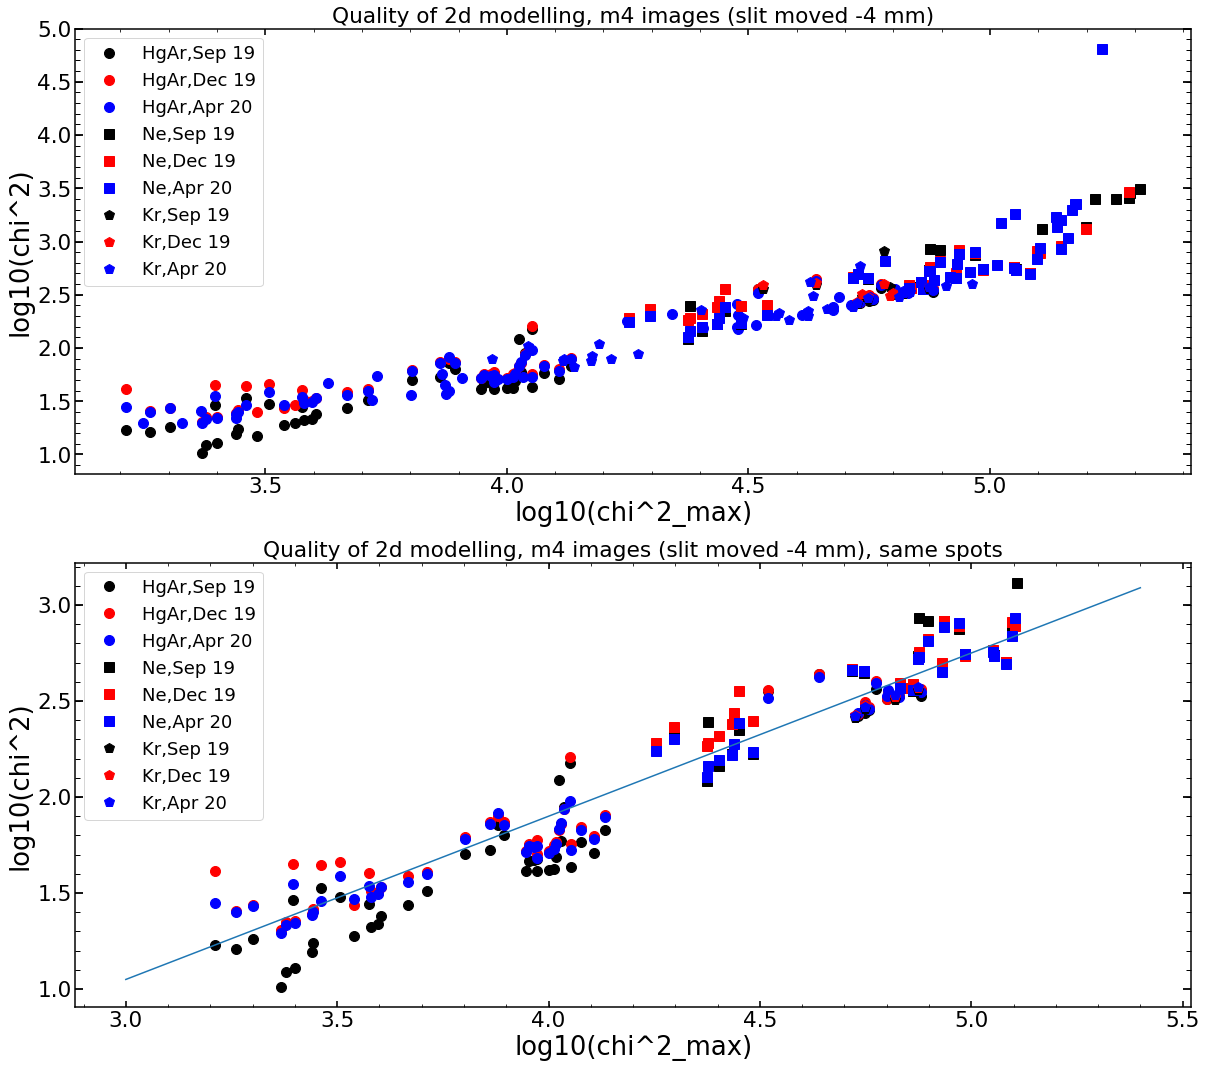

In [203]:
label='p4'


plt.figure(figsize=(20,18))

plt.subplot(211)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Aug16[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_HgAr_from_Aug16[label]['chi2'].values),ls='',marker='o',color='black',label='HgAr,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Dec04[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_HgAr_from_Dec04[label]['chi2'].values),ls='',marker='o',color='red',label='HgAr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Mar06[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_HgAr_from_Mar06[label]['chi2'].values),ls='',marker='o',color='blue',label='HgAr,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Aug16[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_Ne_from_Aug16[label]['chi2'].values),ls='',marker='s',color='black',label='Ne,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Dec04[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_Ne_from_Dec04[label]['chi2'].values),ls='',marker='s',color='red',label='Ne,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Mar06[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_Ne_from_Mar06[label]['chi2'].values),ls='',marker='s',color='blue',label='Ne,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Aug16[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Aug16[label]['chi2'].values),ls='',marker='p',color='black',label='Kr,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Dec04[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Dec04[label]['chi2'].values),ls='',marker='p',color='red',label='Kr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Mar06[label]['chi2max'].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Mar06[label]['chi2'].values),ls='',marker='p',color='blue',label='Kr,Apr 20',markersize=10)

#plt.plot(np.arange(2,4.5,0.1),np.arange(2,4.5,0.1)*0.65-1.4)

plt.title('Quality of 2d modelling, m4 images (slit moved -4 mm)')
plt.legend()
plt.xlabel( 'log10(chi^2_max)')
plt.ylabel('log10(chi^2)')


intersect1d_HgAr=np.intersect1d(np.intersect1d(results_of_fit_many_direct_HgAr_from_Aug16['m4'].index,results_of_fit_many_direct_HgAr_from_Dec04['m4'].index),results_of_fit_many_direct_HgAr_from_Mar06['m4'].index)
intersect1d_Ne=np.intersect1d(np.intersect1d(results_of_fit_many_direct_Ne_from_Aug16['m4'].index,results_of_fit_many_direct_Ne_from_Dec04['m4'].index),results_of_fit_many_direct_Ne_from_Mar06['m4'].index)
intersect1d_Kr=np.intersect1d(np.intersect1d(results_of_fit_many_direct_Kr_from_Aug16['m4'].index,results_of_fit_many_direct_Kr_from_Dec04['m4'].index),results_of_fit_many_direct_Kr_from_Mar06['m4'].index)
print(len(intersect1d_HgAr),len(intersect1d_Ne),len(intersect1d_Kr))


plt.subplot(212)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Aug16[label]['chi2max'][intersect1d_HgAr].values),\
         np.log10(results_of_fit_many_direct_HgAr_from_Aug16[label]['chi2'][intersect1d_HgAr].values),ls='',marker='o',color='black',label='HgAr,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Dec04[label]['chi2max'][intersect1d_HgAr].values),\
         np.log10(results_of_fit_many_direct_HgAr_from_Dec04[label]['chi2'][intersect1d_HgAr].values),ls='',marker='o',color='red',label='HgAr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Mar06[label]['chi2max'][intersect1d_HgAr].values),\
         np.log10(results_of_fit_many_direct_HgAr_from_Mar06[label]['chi2'][intersect1d_HgAr].values),ls='',marker='o',color='blue',label='HgAr,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Aug16[label]['chi2max'][intersect1d_Ne].values),\
         np.log10(results_of_fit_many_direct_Ne_from_Aug16[label]['chi2'][intersect1d_Ne].values),ls='',marker='s',color='black',label='Ne,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Dec04[label]['chi2max'][intersect1d_Ne].values),\
         np.log10(results_of_fit_many_direct_Ne_from_Dec04[label]['chi2'][intersect1d_Ne].values),ls='',marker='s',color='red',label='Ne,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Mar06[label]['chi2max'][intersect1d_Ne].values),\
         np.log10(results_of_fit_many_direct_Ne_from_Mar06[label]['chi2'][intersect1d_Ne].values),ls='',marker='s',color='blue',label='Ne,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Aug16[label]['chi2max'][intersect1d_Kr].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Aug16[label]['chi2'][intersect1d_Kr].values),ls='',marker='p',color='black',label='Kr,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Dec04[label]['chi2max'][intersect1d_Kr].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Dec04[label]['chi2'][intersect1d_Kr].values),ls='',marker='p',color='red',label='Kr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Mar06[label]['chi2max'][intersect1d_Kr].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Mar06[label]['chi2'][intersect1d_Kr].values),ls='',marker='p',color='blue',label='Kr,Apr 20',markersize=10)

plt.plot(np.arange(3,5.5,0.1),np.arange(3,5.5,0.1)*0.85-1.5)

plt.title('Quality of 2d modelling, m4 images (slit moved -4 mm), same spots')
plt.legend()
plt.xlabel( 'log10(chi^2_max)')
plt.ylabel('log10(chi^2)')

# April 15 (focus - direct & interpolation )

In [59]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

## Scripts

### Initial scripts 

In [65]:
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/'

# where are the dataframe which we use to guess the initial solution
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_preApril20run_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_preApril20run_Ne=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_preApril20run_Kr=pickle.load(f)
    

# where are the dataframe which we use to guess the initial solution
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_HgAr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preApril20run_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Ne_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preApril20run_Ne=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Kr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preApril20run_Kr=pickle.load(f)

In [66]:
list_of_HgAr_to_analyze_10=np.array_split(results_of_fit_many_direct_preApril20run_HgAr['0p'].index.astype(int).values,len(results_of_fit_many_direct_preApril20run_HgAr['0p'])/8)

list_of_Ne_to_analyze_10=np.array_split(results_of_fit_many_direct_preApril20run_Ne['0p'].index.astype(int).values,len(results_of_fit_many_direct_preApril20run_Ne['0p'])/8)

list_of_Kr_to_analyze_10=np.array_split(results_of_fit_many_direct_preApril20run_Kr['0p'].index.astype(int).values,len(results_of_fit_many_direct_preApril20run_Kr['0p'])/8)

In [67]:
list_of_Kr_to_analyze_10

[array([ 0,  1,  2,  4,  5,  6,  8,  9, 10]),
 array([12, 13, 14, 15, 16, 17, 18, 19, 20]),
 array([21, 22, 23, 24, 25, 26, 27, 28]),
 array([29, 30, 32, 33, 34, 36, 37, 38])]

In [68]:
for single_spot in list_of_HgAr_to_analyze_10:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=1
    else:
        double_source=0    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T16S'+str(single_spot)+'Mar20.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=5 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, p4, 0, m35, m05
    for obs in [21346+6,21346+102,21346+54,21346+12,21346+96,21346+48]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Mar2020_MPI01.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+"\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Mar20ScriptToSubmitScriptsTiger16'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T16S'+str(single_spot)+'Mar20.sh \n')

file.close()

NameError: name 'remove' is not defined

In [190]:
def remove(string): 
    return string.replace(" ", "")

for i in range(len(list_of_HgAr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T01'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_HgAr_to_analyze_10[i]:
        if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21346+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 direct Apr15 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger01_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_HgAr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T01'+str(i)+'Apr_focus.sh \n')

file.close()


for i in range(len(list_of_Ne_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T02'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Ne_to_analyze_10[i]:
        if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21550+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 direct Apr15 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger02_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_Ne_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T02'+str(i)+'Apr_focus.sh \n')

file.close()


for i in range(len(list_of_Kr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T03'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Kr_to_analyze_10[i]:
        if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21754+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 direct Apr15 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger03_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_Kr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T03'+str(i)+'Apr_focus.sh \n')

file.close()





### Extended scripts 

In [69]:
input_index_HgAr=results_of_fit_many_direct_preApril20run_HgAr['0p'].index.astype(int).values
output_index_HgAr=results_of_fit_many_direct_HgAr_from_Apr1520.index.astype(int).values
difference_HgAr=np.setdiff1d(input_index_HgAr,output_index_HgAr)

input_index_Ne=results_of_fit_many_direct_preApril20run_Ne['0p'].index.astype(int).values
output_index_Ne=results_of_fit_many_direct_Ne_from_Apr1520.index.astype(int).values
difference_Ne=np.setdiff1d(input_index_Ne,output_index_Ne)

input_index_Kr=results_of_fit_many_direct_preApril20run_Kr['0p'].index.astype(int).values
output_index_Kr=results_of_fit_many_direct_Kr_from_Apr1520.index.astype(int).values
difference_Kr=np.setdiff1d(input_index_Kr,output_index_Kr)

print(len(input_index_HgAr),len(input_index_Ne),len(input_index_Kr))

print(len(output_index_HgAr),len(output_index_Ne),len(output_index_Kr))

NameError: name 'results_of_fit_many_direct_HgAr_from_Apr1520' is not defined

In [64]:
list_of_HgAr_to_analyze_10=np.array_split(difference_HgAr,len(difference_HgAr)/5)

list_of_Ne_to_analyze_10=np.array_split(difference_Ne,np.ceil(len(difference_Ne)/5))

list_of_Kr_to_analyze_10=np.array_split(difference_Kr,np.ceil(len(difference_Kr)/5))

NameError: name 'difference_HgAr' is not defined

In [310]:
list_of_HgAr_to_analyze_10

[array([11, 13, 15, 25, 27, 32]),
 array([33, 35, 39, 41, 42, 52]),
 array([53, 54, 55, 57, 58, 59]),
 array([60, 61, 70, 81, 83, 95])]

In [312]:
list_of_Ne_to_analyze_10

[array([12, 14, 47, 48])]

In [311]:
list_of_Kr_to_analyze_10

[array([10, 18, 19, 20])]

In [281]:
def remove(string): 
    return string.replace(" ", "")

for i in range(len(list_of_HgAr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T04'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_HgAr_to_analyze_10[i]:
        if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21346+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 direct Apr15 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger04_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_HgAr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T04'+str(i)+'Apr_focus.sh \n')

file.close()


for i in range(len(list_of_Ne_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T05'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Ne_to_analyze_10[i]:
        if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21550+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 direct Apr15 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger05_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_Ne_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T05'+str(i)+'Apr_focus.sh \n')

file.close()


for i in range(len(list_of_Kr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T06'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Kr_to_analyze_10[i]:
        if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21754+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 direct Apr15 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger06_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_Kr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T06'+str(i)+'Apr_focus.sh \n')

file.close()



## Avaliable images

In [70]:
date='Apr1520'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5NeEmcee3.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5HgArEmcee3.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*5KrEmcee3.npy', recursive=True)

In [71]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][94:len(Emcee3_Ne[i])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][94:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][94:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [72]:
if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_HgAr_images)>0:
    arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
    arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]
else:
    arranged_by_defocus_HgAr=[]
    arranged_by_spot_number_HgAr=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print(len(analyzed_HgAr_images),len(analyzed_Neon_images),len(analyzed_Kr_images))

84 52 32


In [73]:
analyzed_Kr_images

array([[21808,     5],
       [21808,    25],
       [21808,     2],
       [21808,    22],
       [21808,    37],
       [21808,    30],
       [21808,    14],
       [21808,    13],
       [21808,    36],
       [21808,    23],
       [21808,    24],
       [21808,     4],
       [21808,    12],
       [21808,    15],
       [21808,     9],
       [21808,    29],
       [21808,    28],
       [21808,     8],
       [21808,    38],
       [21808,    34],
       [21808,    33],
       [21808,     6],
       [21808,    26],
       [21808,     1],
       [21808,    21],
       [21808,    17],
       [21808,    10],
       [21808,    20],
       [21808,     0],
       [21808,    27],
       [21808,    32],
       [21808,    16]])

In [74]:
arranged_by_spot_number_Ne

array([[21604,     2],
       [21604,     3],
       [21604,     5],
       [21604,     6],
       [21604,     8],
       [21604,    11],
       [21604,    12],
       [21604,    14],
       [21604,    15],
       [21604,    20],
       [21604,    23],
       [21604,    24],
       [21604,    26],
       [21604,    29],
       [21604,    30],
       [21604,    31],
       [21604,    32],
       [21604,    33],
       [21604,    35],
       [21604,    38],
       [21604,    39],
       [21604,    41],
       [21604,    42],
       [21604,    44],
       [21604,    45],
       [21604,    47],
       [21604,    48],
       [21604,    50],
       [21604,    51],
       [21604,    53],
       [21604,    54],
       [21604,    56],
       [21604,    57],
       [21604,    59],
       [21604,    60],
       [21604,    62],
       [21604,    63],
       [21604,    66],
       [21604,    69],
       [21604,    71],
       [21604,    72],
       [21604,    74],
       [21604,    75],
       [216

In [75]:
arranged_by_spot_number_HgAr

array([[21400,     1],
       [21400,     3],
       [21400,     5],
       [21400,     6],
       [21400,     7],
       [21400,     8],
       [21400,     9],
       [21400,    11],
       [21400,    13],
       [21400,    15],
       [21400,    17],
       [21400,    18],
       [21400,    19],
       [21400,    20],
       [21400,    21],
       [21400,    23],
       [21400,    25],
       [21400,    27],
       [21400,    29],
       [21400,    30],
       [21400,    31],
       [21400,    32],
       [21400,    33],
       [21400,    35],
       [21400,    39],
       [21400,    41],
       [21400,    42],
       [21400,    43],
       [21400,    45],
       [21400,    46],
       [21400,    47],
       [21400,    48],
       [21400,    49],
       [21400,    50],
       [21400,    52],
       [21400,    53],
       [21400,    54],
       [21400,    55],
       [21400,    56],
       [21400,    57],
       [21400,    58],
       [21400,    59],
       [21400,    60],
       [214

In [76]:
try:
    unique_numbers_HgAr=np.unique(arranged_by_spot_number_HgAr[:,1])
except:
    pass
unique_numbers_with_5_or_more_images_HgAr=[]
unique_numbers_with_4_or_less_images_HgAr=[]

try:
    unique_numbers_Ne=np.unique(arranged_by_spot_number_Ne[:,1])
except:
    pass
unique_numbers_with_5_or_more_images_Ne=[]
unique_numbers_with_4_or_less_images_Ne=[]

try:
    unique_numbers_Kr=np.unique(arranged_by_spot_number_Kr[:,1])
except:
    pass
unique_numbers_with_5_or_more_images_Kr=[]
unique_numbers_with_4_or_less_images_Kr=[]


for u in unique_numbers_HgAr:
    if np.sum(arranged_by_spot_number_HgAr[:,1]==u)>=7:
        unique_numbers_with_5_or_more_images_HgAr.append(u)
    else:
        unique_numbers_with_4_or_less_images_HgAr.append(u)
        
try:        
    for u in unique_numbers_Ne:
        if np.sum(arranged_by_spot_number_Ne[:,1]==u)>=7:
            unique_numbers_with_5_or_more_images_Ne.append(u)
        else:
            unique_numbers_with_4_or_less_images_Ne.append(u)
except:
    pass        

try:
    for u in unique_numbers_Kr:
        if np.sum(arranged_by_spot_number_Kr[:,1]==u)>=7:
            unique_numbers_with_5_or_more_images_Kr.append(u)
        else:
            unique_numbers_with_4_or_less_images_Kr.append(u)
except:
        pass

In [77]:
print(unique_numbers_with_5_or_more_images_HgAr)
print(unique_numbers_with_5_or_more_images_Ne) 
print(unique_numbers_with_5_or_more_images_Kr)
print('######')
print(unique_numbers_with_4_or_less_images_HgAr)
print(unique_numbers_with_4_or_less_images_Ne)
print(unique_numbers_with_4_or_less_images_Kr)

[]
[]
[]
######
[1, 3, 5, 6, 7, 8, 9, 11, 13, 15, 17, 18, 19, 20, 21, 23, 25, 27, 29, 30, 31, 32, 33, 35, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 73, 75, 77, 78, 79, 80, 81, 83, 85, 87, 89, 90, 91, 92, 93, 95, 97, 99, 101, 102, 103, 104, 105, 107, 109, 111, 113, 114, 115, 116, 117, 119]
[2, 3, 5, 6, 8, 11, 12, 14, 15, 20, 23, 24, 26, 29, 30, 31, 32, 33, 35, 38, 39, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 59, 60, 62, 63, 66, 69, 71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89]
[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38]


In [236]:
np.unique(finalNe_Feb2020_dataset['fiber'])

array([2, 63, 192, 255, 339, 401, 464, 525, 587, 650], dtype=object)

In [237]:
finalNe_Feb2020_dataset[finalNe_Feb2020_dataset['fiber']==255]

fiber    xc    yc wavelength close lamp xc_effective second_offset  \
27   255  1223   320  650.84186     0   Ne         1223         30.12   
28   255  1223   350   653.4774    -1   Ne         1223             0   
29   255  1223   425   660.0668     1   Ne         1223             0   
30   255  1224   516  668.01764     0   Ne         1224         44.24   
31   255  1224   560   671.9268    -1   Ne         1224             0   
32   255  1225   802  693.13116     1   Ne         1225             0   
33   255  1225  1082  717.59015     1   Ne         1225             0   
34   255  1225  1164  724.72437     1   Ne         1225             0   
35   255  1225  1387   744.1276     0   Ne         1225         38.57   

   second_ratio second2_offset second2_ratio  
27        0.406              0             0  
28            0              0             0  
29            0              0             0  
30         0.67         -29.97         0.003  
31            0              0             0  
32            0              0             0  
33            0              0             0  
34            0              0             0  
35        0.012          57.44         0.162

## single image analysis 

In [78]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [79]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
       'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
      'x_fiber','y_fiber','effective_radius_illumination',
      'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
      'grating_lines','scattering_slope','scattering_amplitude',
      'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

In [252]:
date='Apr1520'
obs=21604
obs_int=int(obs)
single_number='30'
image_index=int(single_number)
eps=5
arc='Ne'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4 or dataset==5:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4 or dataset==5:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
 
if dataset==5:
    if arc=='HgAr':
        obs_possibilites=np.arange(21280,21280+11*6,6)
    if arc=='Ne':
        obs_possibilites=np.arange(21484,21484+11*6,6)
    if arc=='Kr':
         obs_possibilites=np.arange(21688,21688+11*6,6)



label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
label_fine_defocus=['m05ff','m04ff','m03ff','m02ff','m01ff','0ff','p01ff','p02ff','p03ff','p04ff','p05ff']
if dataset in [0,1,2,3,4]:
    labelInput=label[list(obs_possibilites).index(obs_int)]
if dataset in [5]:
    labelInput=label_fine_defocus[list(obs_possibilites).index(obs_int)]
    
    
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    
"""
sci_image_focus_like_defocus=np.zeros((50,50))
var_image_focus_like_defocus=np.zeros((50,50))
mask_image_focus_like_defocus=np.zeros((50,50))

sci_image_focus_like_defocus[15:35,15:35]=sci_image
var_image_focus_like_defocus[15:35,15:35]=var_image
mask_image_focus_like_defocus[15:35,15:35]=mask_image

sci_image=sci_image_focus_like_defocus
var_image=var_image_focus_like_defocus
mask_image=mask_image_focus_like_defocus
"""

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4 or dataset==5:   
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2020_dataset
    elif arc=="Ne":
        finalArc=finalNe_Feb2020_dataset    
    elif arc=="Kr":
        finalArc=finalKr_Feb2020_dataset    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]


if str(finalArc.loc[int(single_number)]['close'])=='0' or str(finalArc.loc[int(single_number)]['close'])=='0.5':
    double_source=1
elif str(finalArc.loc[int(single_number)]['close'])=='-1':
    print('can not be analyzed!')
else:
    double_source=None    

double_sources_positions_ratios=finalArc.loc[int(single_number)][['second_offset','second_ratio']].values
print([double_source,double_sources_positions_ratios])

0d
[1, array([44.24, 0.67], dtype=object)]


In [253]:
finalArc.loc[int(single_number)]

fiber                   255
xc                     1224
yc                      516
wavelength        668.01764
close                     0
                    ...    
xc_effective           1224
second_offset         44.24
second_ratio           0.67
second2_offset       -29.97
second2_ratio         0.003
Name: 30, Length: 11, dtype: object

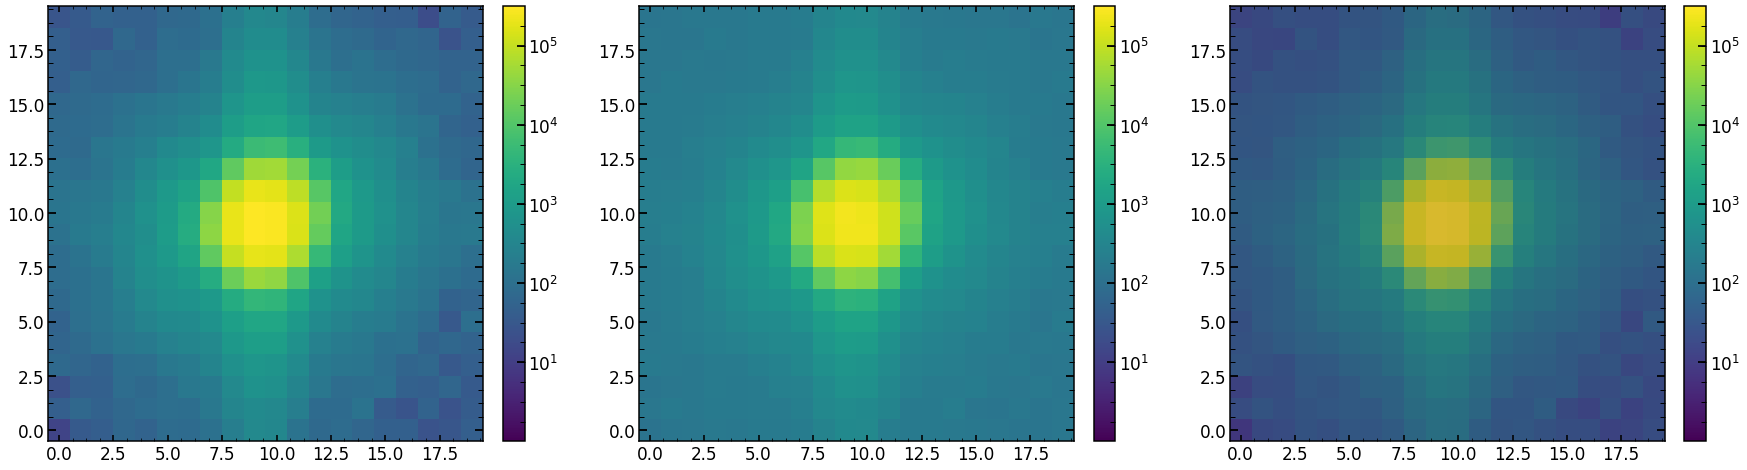

In [254]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(132)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(133)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(mask_image,origin='lower',vmin=0,vmax=np.max(mask_image),alpha=0.2)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
#cbar.set_ticks([10,10**2,10**3,10**4,10**5])

In [255]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc,dataset)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain,like_min=single_analysis.create_likelihood()

(40, 390, 42) (196, 40, 42) (42, 390, 42) (252, 20, 42)
(number of walkers, number of steps, number of parameters): (252, 20, 42)
minimal likelihood is: 193462.85921611634
minimal chi2 reduced is: 959.3544150991364


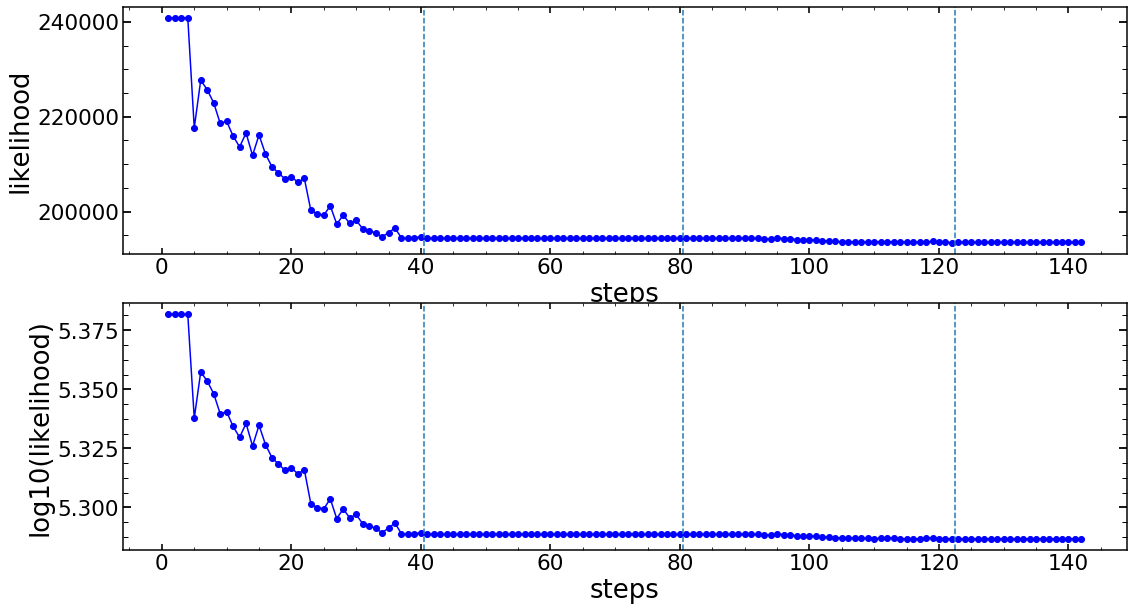

In [256]:
size=chain0_Emcee3.shape[1]
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(np.sum(len_of_chains[:1])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:2])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:3])+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(np.sum(len_of_chains[:1])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:2])+0.5,ls='--')
plt.axvline(np.sum(len_of_chains[:3])+0.5,ls='--')

In [257]:
model = LN_PFS_single(sci_image,var_image,mask_image=mask_image,dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=double_source,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,simulation_00=0)   
#minchain_new=np.copy(minchain)   
#minchain_new[0]=10
#minchain_new[1]=5

model(minchain)

npix_value:1536
Science image shape is: (20, 20)
Top left pixel value of the science image is: 13.273964
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 126.89618
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.42979027     1.44043101    -1.29816973     0.22066089
    -0.08651571    -0.38163994    -0.37532004    -0.6900338
    -0.04201143    -0.45839238     0.0035437      0.07036046
    -0.00756452     0.04552905     0.03018921     0.13362669
    -0.11931946    -0.07969654     0.02837701     0.62777365
     0.08393494    -0.07179333    -0.0872802      0.05405048
     0.03118781     0.0000221      0.0000221      0.97484079
     0.94833718     0.01844497    -0.02606881     0.92260773
     0.05102462     0.31270997     1.03073683  

Finished with optPsf_postprocessing
 
Finished with constructModelImage_PFS_naturalResolution
 
Finished with lnlike_Neven
 


-193484.6435355448

In [258]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut.npy')
optPsf_cut_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled.npy')
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')
optPsf_cut_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_downsampled_scattered.npy')
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled


optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy')


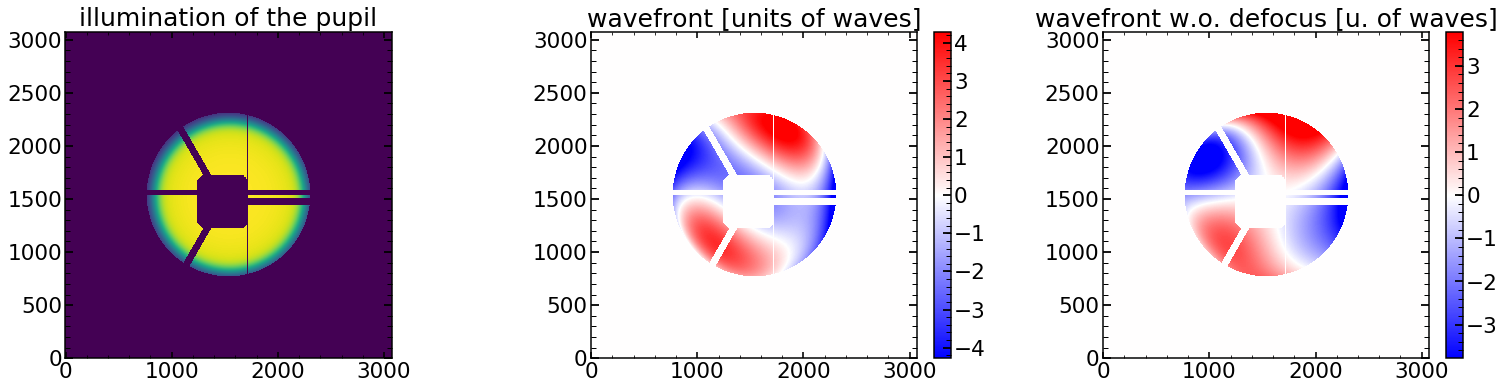

In [259]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 959.4633405659874
Abs of residual divided by total flux is: 0.18306288887677727
Abs of residual divided by largest value of a flux in the image is: 0.14742746192187745


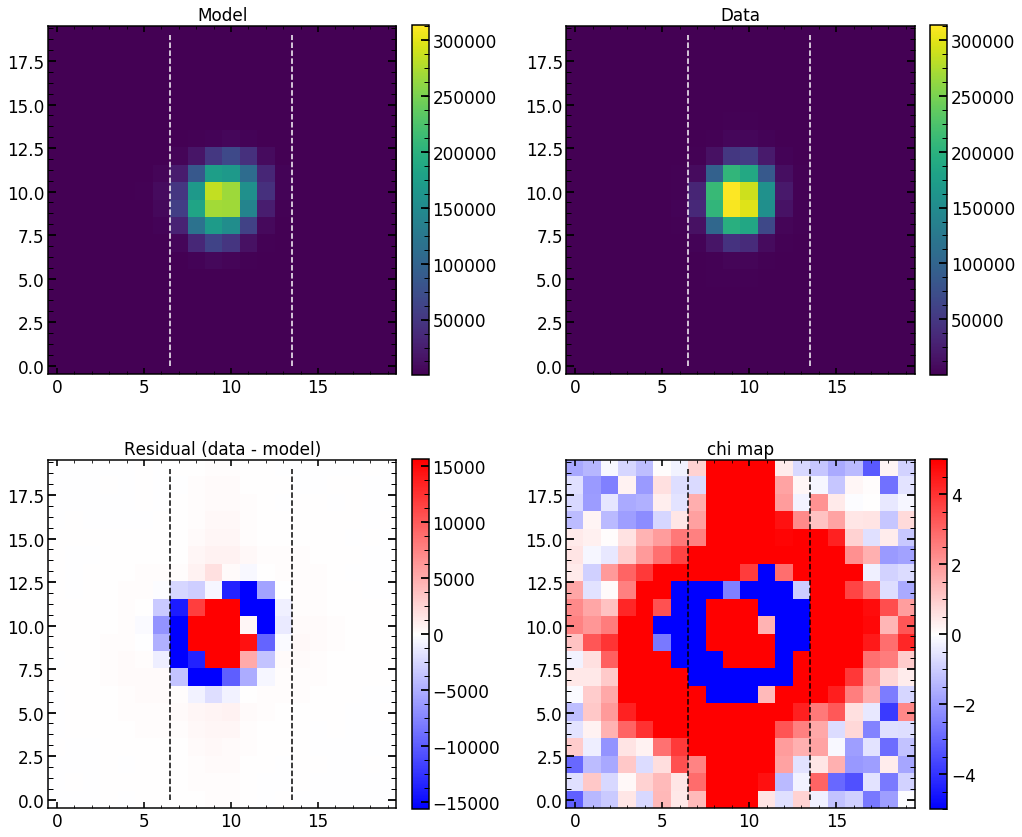

In [260]:
matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot()

8273.397248609344
chi**2 reduced is: 8273.397248609344
Abs of residual divided by total flux is: 5.581989168034295
Abs of residual divided by largest value of a flux in the image is: 5.906804165963993


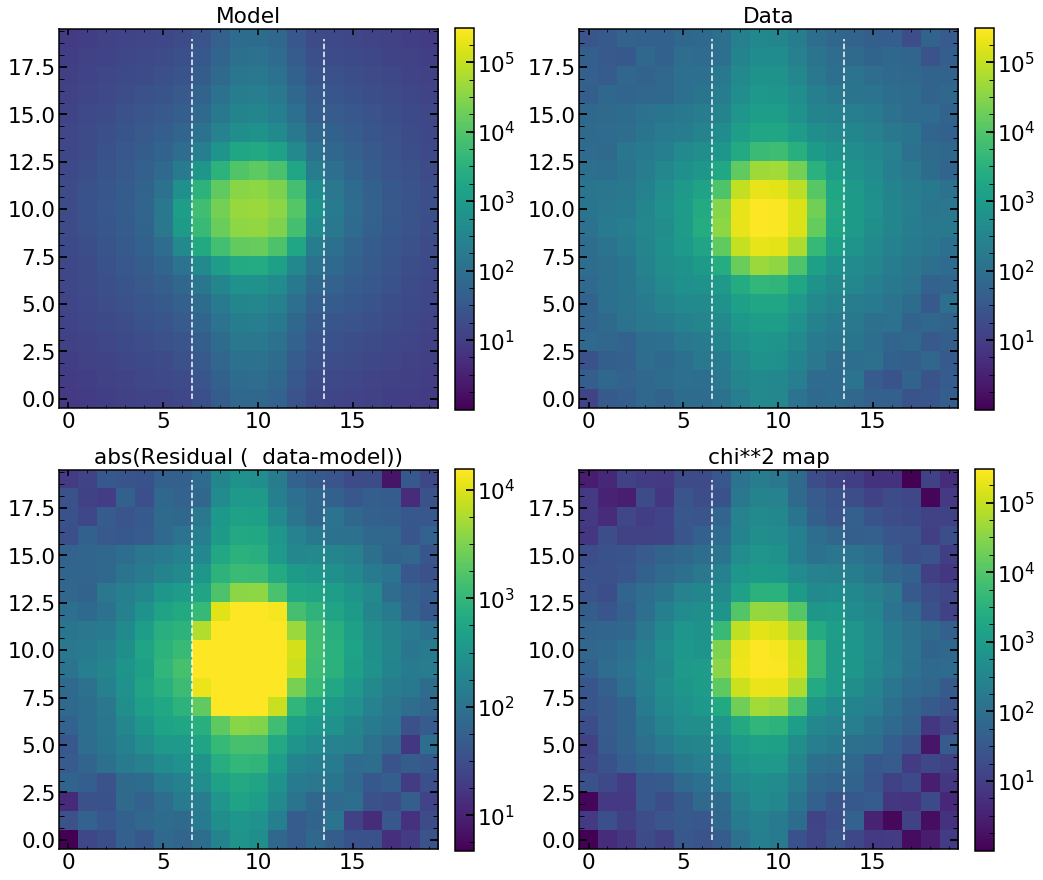

In [306]:
single_analysis.create_basic_comparison_plot_log()

11.834650498288184
chi**2 reduced is: 11.834650498288184
Abs of residual divided by total flux is: 0.030908108658827014
Abs of residual divided by largest value of a flux in the image is: 0.03703311268120291


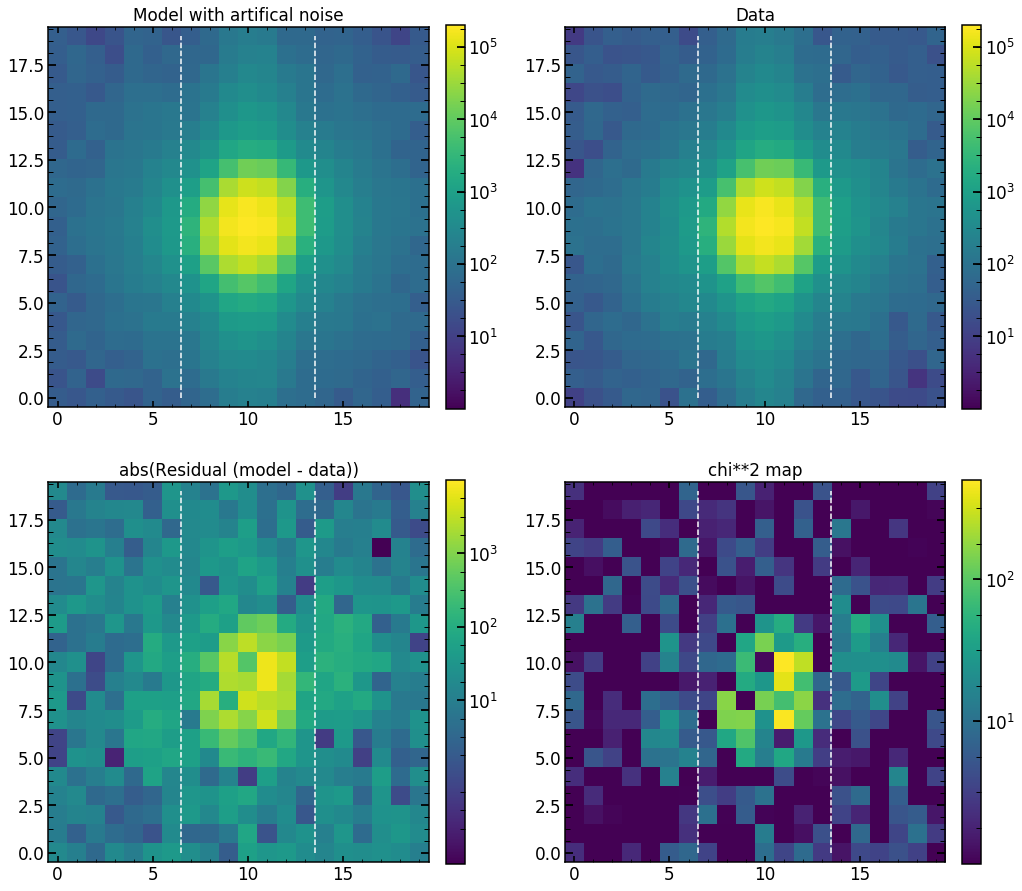

In [249]:
single_analysis.create_basic_comparison_plot_log_artifical()

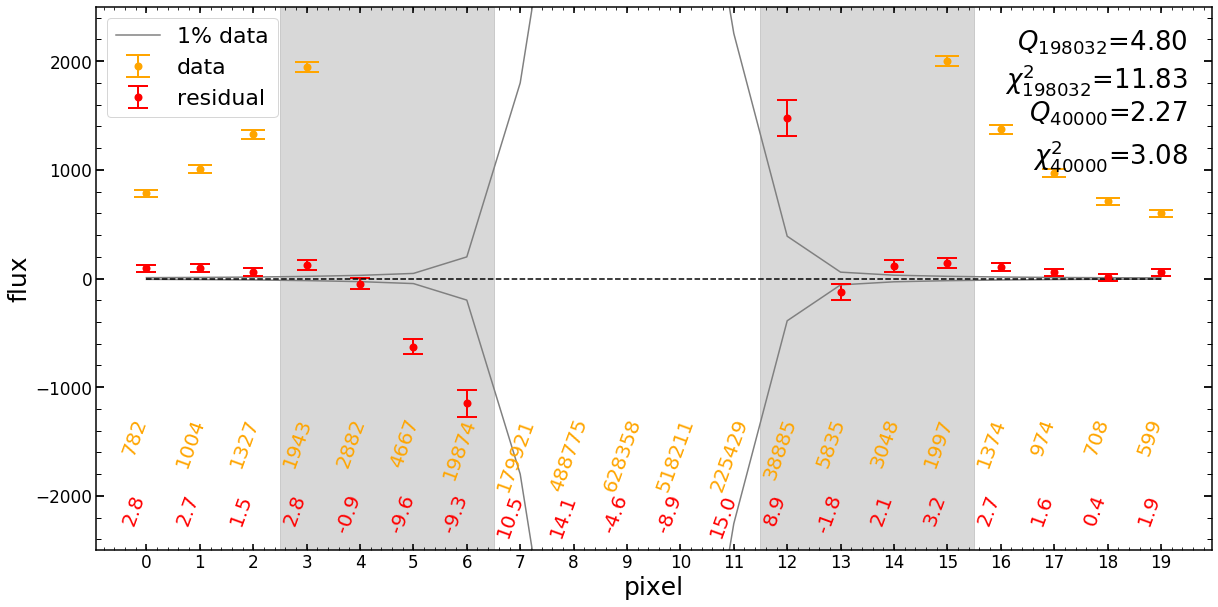

In [250]:
# errors are not same on two figures!!!
sci_image=single_analysis.return_sci_image()
var_image=single_analysis.return_var_image()
model_image=single_analysis.return_model_image()

plot_1D_residual(sci_image,var_image,model_image)

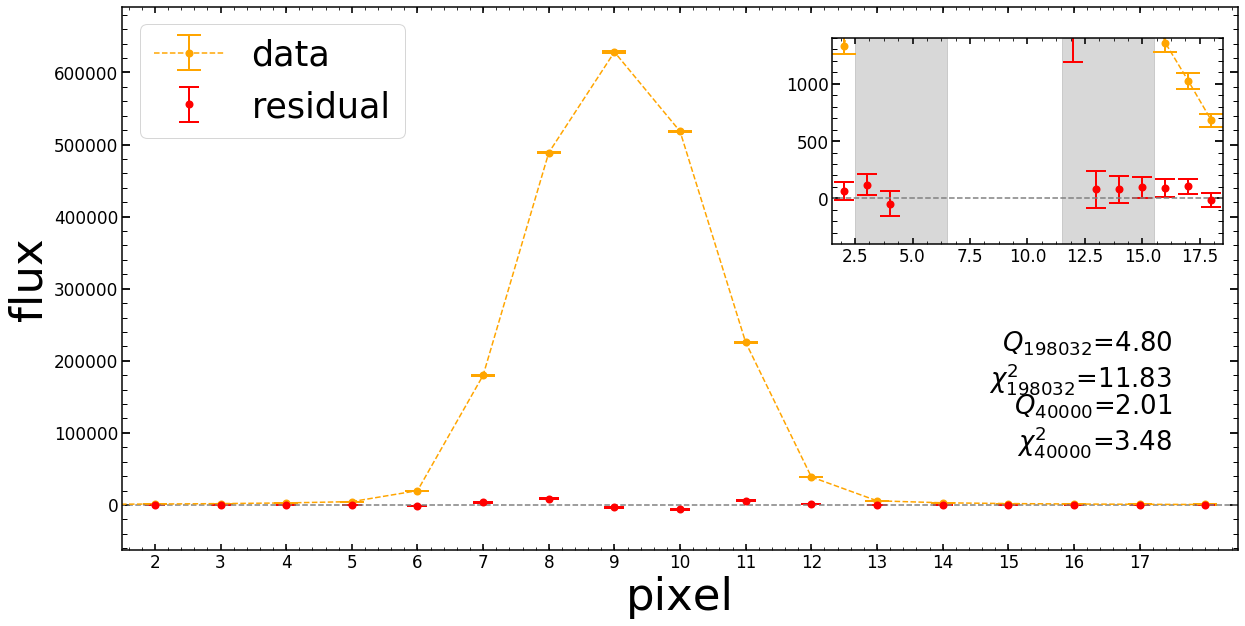

In [251]:
plot_1D_residual_custom_large(sci_image,var_image,model_image)

## results everywhere 

In [93]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020', 'rb') as f:
    finalHgAr_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f)  

finalHgAr=finalHgAr_Feb2020_dataset
finalNe=finalNe_Feb2020_dataset
finalKr=finalKr_Feb2020_dataset

In [94]:
assert date=='Apr1520'

results_of_fit_many_single_focus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                   index=finalHgAr.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                       index=finalHgAr.index,columns=columns22_analysis)

results_of_fit_many_single_focus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_focus_HgAr)
err_results_of_fit_many_single_focus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_focus_HgAr)

#####

results_of_fit_many_single_focus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                 index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_focus_Ne_pd=pd.DataFrame(results_of_fit_many_single_focus_Ne)
err_results_of_fit_many_single_focus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_focus_Ne)

#####

results_of_fit_many_single_focus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                 index=finalKr.index,columns=columns22_analysis)
err_results_of_fit_many_single_focus_Kr=pd.DataFrame(np.zeros((len(finalKr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),\
                                                     index=finalKr.index,columns=columns22_analysis)

results_of_fit_many_single_focus_Kr_pd=pd.DataFrame(results_of_fit_many_single_focus_Kr)
err_results_of_fit_many_single_focus_Kr_pd=pd.DataFrame(err_results_of_fit_many_single_focus_Kr)


In [95]:
columns_analysis=columns22_analysis

for single_number in range(len(finalHgAr)):
    
    result_analysis=Zernike_result_analysis(date,single_number,'HgAr',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single_focus()
    results_of_fit_many_single_focus_HgAr_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_HgAr_pd=results_of_fit_many_single_focus_HgAr_pd[np.abs(results_of_fit_many_single_focus_HgAr_pd['z4'])>0]



for single_number in range(len(finalNe)):
        
    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single_focus()
    results_of_fit_many_single_focus_Ne_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_Ne_pd=results_of_fit_many_single_focus_Ne_pd[np.abs(results_of_fit_many_single_focus_Ne_pd['z4'])>0]



for single_number in range(len(finalKr)):
        
    result_analysis=Zernike_result_analysis(date,single_number,'Kr',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single_focus()
    results_of_fit_many_single_focus_Kr_pd.loc[single_number]=results_of_fit_single.values  

results_of_fit_many_single_focus_Kr_pd=results_of_fit_many_single_focus_Kr_pd[np.abs(results_of_fit_many_single_focus_Kr_pd['z4'])>0]


1 obs (Emcee3, focus): 21400 is found!
3 obs (Emcee3, focus): 21400 is found!
5 obs (Emcee3, focus): 21400 is found!
6 obs (Emcee3, focus): 21400 is found!
7 obs (Emcee3, focus): 21400 is found!
8 obs (Emcee3, focus): 21400 is found!
9 obs (Emcee3, focus): 21400 is found!
11 obs (Emcee3, focus): 21400 is found!
13 obs (Emcee3, focus): 21400 is found!
15 obs (Emcee3, focus): 21400 is found!
17 obs (Emcee3, focus): 21400 is found!
18 obs (Emcee3, focus): 21400 is found!
19 obs (Emcee3, focus): 21400 is found!
20 obs (Emcee3, focus): 21400 is found!
21 obs (Emcee3, focus): 21400 is found!
23 obs (Emcee3, focus): 21400 is found!
25 obs (Emcee3, focus): 21400 is found!
27 obs (Emcee3, focus): 21400 is found!
29 obs (Emcee3, focus): 21400 is found!
30 obs (Emcee3, focus): 21400 is found!
31 obs (Emcee3, focus): 21400 is found!
32 obs (Emcee3, focus): 21400 is found!
33 obs (Emcee3, focus): 21400 is found!
35 obs (Emcee3, focus): 21400 is found!
39 obs (Emcee3, focus): 21400 is found!
41 obs 

In [96]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_HgAr_pd

z4        z5        z6        z7        z8        z9       z10  \
1    1.057901  0.263215 -0.136931  0.491623  0.640376  0.218232 -0.347003   
3    0.834611  0.121743 -0.065698  0.430125  0.617954  0.128828 -0.275378   
5    0.875033 -0.103810  0.052640  0.271415  0.510447  0.056323 -0.218967   
6    0.813353 -0.257015  0.074459  0.211209  0.436435 -0.015353 -0.189621   
7    0.663086 -0.549726 -0.025272  0.069511  0.426580 -0.077579 -0.181386   
..        ...       ...       ...       ...       ...       ...       ...   
114 -0.450613 -0.128901 -0.062656  0.138522 -1.039705 -0.062366 -0.446682   
115 -0.537665  0.032191 -0.005045  0.033390 -1.022990 -0.139875 -0.448171   
116 -0.626997  0.191269 -0.120513 -0.085707 -0.964039 -0.182689 -0.446334   
117  0.699761  0.387522 -0.412097 -0.271906 -0.938017 -0.366629 -0.399603   
119  0.744705  0.345358 -0.515612 -0.300019 -0.822810 -0.479822 -0.171096   

          z11       z12       z13  ...  det_vert  slitHolder_frac_dx  \
1   -0.029465 -0.135699 -0.113871  ...  0.993966            0.615472   
3   -0.044645 -0.169407 -0.100395  ...  0.992199            0.623955   
5   -0.089005 -0.160917 -0.042649  ...  0.985342            0.604405   
6   -0.043999 -0.172782 -0.013655  ...  0.991020            0.595909   
7   -0.032628 -0.163855  0.044639  ...  0.988631            0.574453   
..        ...       ...       ...  ...       ...                 ...   
114 -0.099735 -0.187848 -0.010195  ...  0.995089           -0.233830   
115 -0.123443 -0.149825 -0.061497  ...  0.986524           -0.225668   
116 -0.034642 -0.162574 -0.100558  ...  0.991705           -0.312123   
117  0.214132 -0.105654 -0.207104  ...  1.016173           -0.226255   
119  0.432164  0.019155 -0.285633  ...  1.050915           -0.222869   

     grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
1     45188.335162          2.025984              0.001218      0.350000   
3     28238.961666          1.979683              0.000704      0.350001   
5     45718.484892          2.084413              0.001274      0.350001   
6     39621.703792          1.964096              0.000874      0.350003   
7      9748.295112          2.136660              0.001491      0.350000   
..             ...               ...                   ...           ...   
114   41398.599866          2.159988              0.001441      0.365847   
115    9391.277321          1.926085              0.000814      0.350003   
116    8610.869944          1.676018              0.000413      0.350000   
117   52049.571999          2.105924              0.001843      0.350000   
119   19142.014306          1.942919              0.001684      0.411653   

      fiber_r      flux       chi2      chi2max  
1    1.780571  0.999305   3.680986  1497.676758  
3    1.789922  0.997364   2.149200   421.042938  
5    1.780011  0.997051  23.385939  6108.524902  
6    1.780015  0.997042   6.478820  1367.110840  
7    1.780010  0.997455  12.258064  3711.959961  
..        ...       ...        ...          ...  
114  1.838905  0.996701   4.203060   802.067261  
115  1.805548  0.996288   9.792950  2143.051758  
116  1.792879  0.993998   4.357269   520.956665  
117  1.791469  0.991914  34.621773  3958.158203  
119  1.890781  0.990257   2.524952   189.604843  

[84 rows x 44 columns]

In [97]:
pd.set_option("display.max_rows",10)
results_of_fit_many_single_focus_Ne_pd

z4        z5        z6        z7        z8        z9       z10  \
2   1.107880  0.421004 -0.270865  0.635005  0.690490  0.303621 -0.480176   
3   1.240671  0.319734 -0.269020  0.490459  0.660850  0.288804 -0.468667   
5   1.051087  0.234091 -0.138791  0.423290  0.627635  0.213365 -0.374759   
6   1.005125  0.208655 -0.082032  0.430289  0.576679  0.154989 -0.277949   
8   0.866951  0.099982  0.005769  0.342942  0.546900  0.092790 -0.247398   
..       ...       ...       ...       ...       ...       ...       ...   
83  0.992673 -0.603487 -0.258155  0.642683 -1.252096  0.300778 -0.049786   
84  0.838780 -0.523726 -0.219885  0.581711 -1.291530  0.289227 -0.087788   
86  0.657379 -0.592296 -0.166156  0.562650 -1.161703  0.207951 -0.208175   
87  0.326834 -0.497643 -0.144307  0.442658 -1.164122  0.121670 -0.306555   
89 -0.150988 -0.455586 -0.019605  0.331532 -1.083914  0.053175 -0.345162   

         z11       z12       z13  ...  det_vert  slitHolder_frac_dx  \
2   0.071769 -0.080116 -0.166363  ...  1.017603            0.620243   
3   0.091543 -0.063727 -0.173231  ...  1.010106            0.545395   
5  -0.021590 -0.137472 -0.154922  ...  1.006683            0.626267   
6  -0.035952 -0.151771 -0.110973  ...  0.994111            0.603776   
8  -0.098382 -0.164518 -0.094833  ...  0.989904            0.590379   
..       ...       ...       ...  ...       ...                 ...   
83  0.075041 -0.082100  0.157628  ...  1.010334           -0.210377   
84  0.275559 -0.044332  0.152956  ...  0.993602           -0.522064   
86  0.051069 -0.111891  0.117198  ...  1.001771           -0.218110   
87 -0.031519 -0.145431  0.088630  ...  0.994632           -0.228862   
89 -0.065646 -0.149263  0.060537  ...  0.988439           -0.217236   

    grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
2    38041.811454          2.161971              0.001885      0.383417   
3    40892.910180          2.057754              0.001449      0.350002   
5    41387.842250          2.147654              0.001805      0.350000   
6    38081.330934          1.826131              0.000851      0.350000   
8    79193.725328          2.021345              0.001211      0.350000   
..            ...               ...                   ...           ...   
83   33269.334785          2.028975              0.001512      0.350002   
84   32047.706166          1.646239              0.000463      0.350000   
86   39863.601538          2.138705              0.001983      0.350000   
87   35226.288064          1.852961              0.000990      0.350001   
89   88537.837327          2.089989              0.001679      0.377069   

     fiber_r      flux       chi2      chi2max  
2   1.807015  0.996818  19.345461  5628.119141  
3   1.800865  0.998447  17.194148  9387.206055  
5   1.799054  0.998502  17.079859  9602.761719  
6   1.791696  0.998032   4.955936  2000.132202  
8   1.791693  0.997039  20.814983  6181.423828  
..       ...       ...        ...          ...  
83  1.792132  0.996817  12.702686  3651.568115  
84  1.802074  0.996618  22.226744  6054.042480  
86  1.830819  0.996911  20.701154  6080.844238  
87  1.838806  0.998053   3.496850  1245.952393  
89  1.849134  0.998204   7.995781  3780.805420  

[52 rows x 44 columns]

In [98]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_HgAr_from_Apr15.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_HgAr_pd,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Ne_from_Apr15.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_Ne_pd,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Kr_from_Apr15.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_single_focus_Kr_pd,f, protocol=pickle.HIGHEST_PROTOCOL)

## Verification

In [99]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_HgAr_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Apr1520=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Ne_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Apr1520=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Kr_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Apr1520=pickle.load(f)

In [100]:
results_of_fit_many_HgAr_focus=results_of_fit_many_direct_HgAr_from_Apr1520
results_of_fit_many_Ne_focus=results_of_fit_many_direct_Ne_from_Apr1520
results_of_fit_many_Kr_focus=results_of_fit_many_direct_Kr_from_Apr1520

In [101]:
results_of_fit_many_HgAr

NameError: name 'results_of_fit_many_HgAr' is not defined

In [ ]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
matplotlib.rcParams.update({'font.size': 18})
date='Apr1520'
descriptions=results_of_fit_many_HgAr.columns
# j runs throught the amount of defocu that we have analyzed
zMax=22

# i runs through all the parameters
for i in range(0,len(descriptions)):

    # take values for HgAr
    x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr_focus[descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
    y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr_focus[descriptions[i]].index.astype(int).ravel()]['yc'].values
    values_HgAr=np.array(results_of_fit_many_HgAr_focus[descriptions[i]])

    # take values for Neon        
    x_Ne=finalNe.loc[results_of_fit_many_Ne_focus[descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
    y_Ne=finalNe.loc[results_of_fit_many_Ne_focus[descriptions[i]].index.astype(int).ravel()]['yc'].values
    values_Ne=np.array(results_of_fit_many_Ne_focus[descriptions[i]])

    # take values for Krypton        
    x_Kr=finalKr.loc[results_of_fit_many_Kr_focus[descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
    y_Kr=finalKr.loc[results_of_fit_many_Kr_focus[descriptions[i]].index.astype(int).ravel()]['yc'].values
    values_Kr=np.array(results_of_fit_many_Kr_focus[descriptions[i]])        
    #x=x_HgAr
    #y=y_HgAr  
    #colors=values_HgAr

    # join these values
    x=np.concatenate((x_HgAr,x_Ne,x_Kr))
    y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
    colors= np.concatenate((values_HgAr,values_Ne,values_Kr))



    if zMax==11:

        # limits of color for z5-z11
        if np.in1d([i],[0,1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2

        #'chi2, chi2max'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=10
            min_colors=1

    else:
        # limits of color for z4-z11
        if np.in1d([i],[0,1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits of color for z4-z11
        if np.in1d([i],[8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=0.25
                min_colors=-0.25
                
        # limits for all other parameters    
        if np.in1d([i],[19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2

        #'chi2, chi2max'
        if np.in1d([i],[41,42])[0] == True:   
            max_colors=10
            min_colors=1  

    plt.scatter(x_HgAr, y_HgAr, s=np.pi * (12 * 1)**2, c=values_HgAr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='o')
    plt.scatter(x_Ne, y_Ne, s=np.pi * (8 * 1)**2, c=values_Ne, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='s')
    plt.scatter(x_Kr, y_Kr, s=np.pi * (12 * 1)**2, c=values_Kr, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black',marker='p')
    plt.ylim(0,4176)
    plt.xlim(0,4096)
    plt.xlabel('x position on chip')
    plt.ylabel('y position on chip')
    plt.title(str(date)+' / '+'Direct Fit (``0\'\'): '+" "+str(descriptions[i]))

    plt.colorbar()
    #plt.show()

    IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+'0'+'/'
    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
    if not os.path.exists(IMAGES_FOLDER1):
        os.makedirs(IMAGES_FOLDER1)
        print('Images are in folder: '+str(IMAGES_FOLDER1))

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER1+'0'+" "+str(descriptions[i]))
    plt.savefig(IMAGES_FOLDER2+'0'+" "+str(descriptions[i]))
    plt.clf()

## comparison Sep11, Dec17, Apr15

In [261]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec17_Focus/' + 'results_of_fit_many_direct_HgAr_from_Dec17.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Dec17=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec17_Focus/' + 'results_of_fit_many_direct_Ne_from_Dec17.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Dec17=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec17_Focus/' + 'results_of_fit_many_direct_Kr_from_Dec17.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Dec17=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_HgAr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Sep11=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Ne_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Sep11=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Sep11_Focus/' + 'results_of_fit_many_direct_Kr_from_Sep11.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Sep11=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_HgAr_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Apr1520=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Ne_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Apr1520=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/' + 'results_of_fit_many_direct_Kr_from_Apr15.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Apr1520=pickle.load(f)

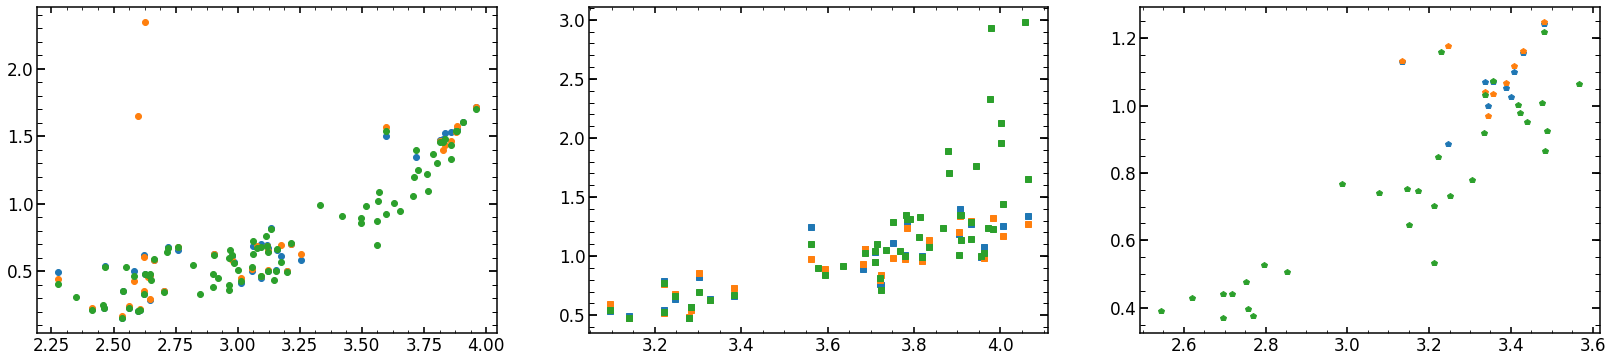

In [262]:
plt.figure(figsize=(28,6))

plt.subplot(131)

plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Dec17['chi2max'].values),np.log10(results_of_fit_many_direct_HgAr_from_Dec17['chi2'].values),ls='',marker='o')
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Sep11['chi2max'].values),np.log10(results_of_fit_many_direct_HgAr_from_Sep11['chi2'].values),ls='',marker='o')
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Apr1520['chi2max'].values),np.log10(results_of_fit_many_direct_HgAr_from_Apr1520['chi2'].values),ls='',marker='o')

plt.subplot(132)

plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Dec17['chi2max'].values),np.log10(results_of_fit_many_direct_Ne_from_Dec17['chi2'].values),ls='',marker='s')
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Sep11['chi2max'].values),np.log10(results_of_fit_many_direct_Ne_from_Sep11['chi2'].values),ls='',marker='s')
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Apr1520['chi2max'].values),np.log10(results_of_fit_many_direct_Ne_from_Apr1520['chi2'].values),ls='',marker='s')

plt.subplot(133)

plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Dec17['chi2max'].values),np.log10(results_of_fit_many_direct_Kr_from_Dec17['chi2'].values),ls='',marker='p')
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Sep11['chi2max'].values),np.log10(results_of_fit_many_direct_Kr_from_Sep11['chi2'].values),ls='',marker='p')
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Apr1520['chi2max'].values),np.log10(results_of_fit_many_direct_Kr_from_Apr1520['chi2'].values),ls='',marker='p')

34 26 3


Text(0,0.5,'log10(chi^2)')

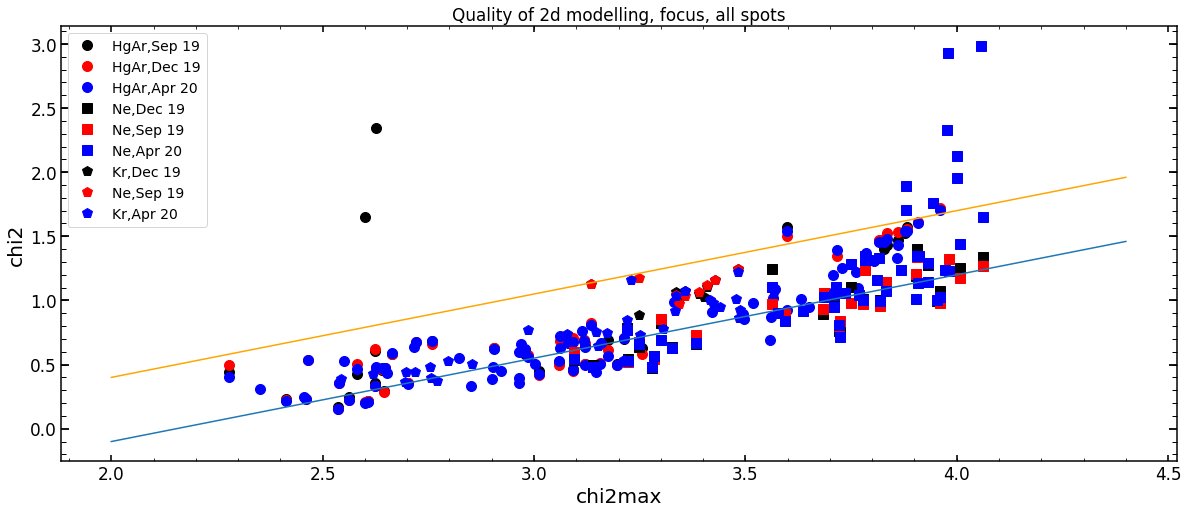

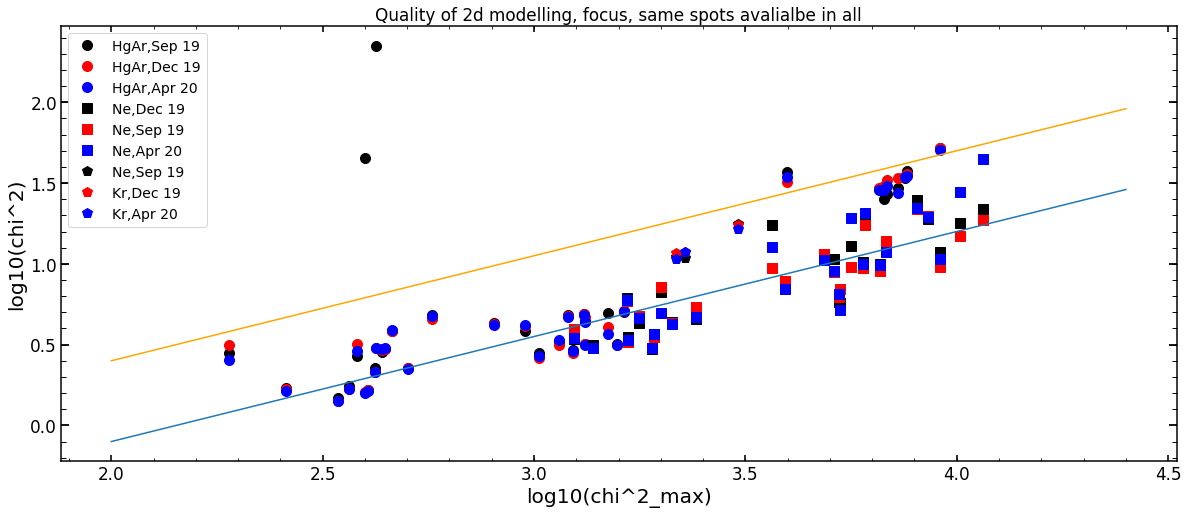

In [271]:
plt.figure(figsize=(20,8))

plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Sep11['chi2max'].values),np.log10(results_of_fit_many_direct_HgAr_from_Sep11['chi2'].values),ls='',marker='o',color='black',label='HgAr,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Dec17['chi2max'].values),np.log10(results_of_fit_many_direct_HgAr_from_Dec17['chi2'].values),ls='',marker='o',color='red',label='HgAr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Apr1520['chi2max'].values),np.log10(results_of_fit_many_direct_HgAr_from_Apr1520['chi2'].values),ls='',marker='o',color='blue',label='HgAr,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Dec17['chi2max'].values),np.log10(results_of_fit_many_direct_Ne_from_Dec17['chi2'].values),ls='',marker='s',color='black',label='Ne,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Sep11['chi2max'].values),np.log10(results_of_fit_many_direct_Ne_from_Sep11['chi2'].values),ls='',marker='s',color='red',label='Ne,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Apr1520['chi2max'].values),np.log10(results_of_fit_many_direct_Ne_from_Apr1520['chi2'].values),ls='',marker='s',color='blue',label='Ne,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Dec17['chi2max'].values),np.log10(results_of_fit_many_direct_Kr_from_Dec17['chi2'].values),ls='',marker='p',color='black',label='Kr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Sep11['chi2max'].values),np.log10(results_of_fit_many_direct_Kr_from_Sep11['chi2'].values),ls='',marker='p',color='red',label='Ne,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Apr1520['chi2max'].values),np.log10(results_of_fit_many_direct_Kr_from_Apr1520['chi2'].values),ls='',marker='p',color='blue',label='Kr,Apr 20',markersize=10)

plt.plot(np.arange(2,4.5,0.1),np.arange(2,4.5,0.1)*0.65-1.4)
plt.plot(np.arange(2,4.5,0.1),np.arange(2,4.5,0.1)*0.65-0.9,color='orange')
plt.legend()
plt.xlabel('chi2max')
plt.ylabel('chi2')
plt.title('Quality of 2d modelling, focus, all spots')

intersect1d_HgAr=np.intersect1d(np.intersect1d(results_of_fit_many_direct_HgAr_from_Sep11.index,results_of_fit_many_direct_HgAr_from_Dec17.index),results_of_fit_many_direct_HgAr_from_Apr1520.index)
intersect1d_Ne=np.intersect1d(np.intersect1d(results_of_fit_many_direct_Ne_from_Sep11.index,results_of_fit_many_direct_Ne_from_Dec17.index),results_of_fit_many_direct_Ne_from_Apr1520.index)
intersect1d_Kr=np.intersect1d(np.intersect1d(results_of_fit_many_direct_Kr_from_Sep11.index,results_of_fit_many_direct_Kr_from_Dec17.index),results_of_fit_many_direct_Kr_from_Apr1520.index)
print(len(intersect1d_HgAr),len(intersect1d_Ne),len(intersect1d_Kr))


plt.figure(figsize=(20,8))

plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Sep11['chi2max'][intersect1d_HgAr].values),np.log10(results_of_fit_many_direct_HgAr_from_Sep11['chi2'][intersect1d_HgAr].values),\
         ls='',marker='o',color='black',label='HgAr,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Dec17['chi2max'][intersect1d_HgAr].values),np.log10(results_of_fit_many_direct_HgAr_from_Dec17['chi2'][intersect1d_HgAr].values),\
         ls='',marker='o',color='red',label='HgAr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_HgAr_from_Apr1520['chi2max'][intersect1d_HgAr].values),np.log10(results_of_fit_many_direct_HgAr_from_Apr1520['chi2'][intersect1d_HgAr].values),\
         ls='',marker='o',color='blue',label='HgAr,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Dec17['chi2max'][intersect1d_Ne].values),np.log10(results_of_fit_many_direct_Ne_from_Dec17['chi2'][intersect1d_Ne].values),\
         ls='',marker='s',color='black',label='Ne,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Sep11['chi2max'][intersect1d_Ne].values),np.log10(results_of_fit_many_direct_Ne_from_Sep11['chi2'][intersect1d_Ne].values),\
         ls='',marker='s',color='red',label='Ne,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Ne_from_Apr1520['chi2max'][intersect1d_Ne].values),np.log10(results_of_fit_many_direct_Ne_from_Apr1520['chi2'][intersect1d_Ne].values),\
         ls='',marker='s',color='blue',label='Ne,Apr 20',markersize=10)

plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Sep11['chi2max'][intersect1d_Kr].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Sep11['chi2'][intersect1d_Kr].values),ls='',marker='p',color='black',label='Ne,Sep 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Dec17['chi2max'][intersect1d_Kr].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Dec17['chi2'][intersect1d_Kr].values),ls='',marker='p',color='red',label='Kr,Dec 19',markersize=10)
plt.plot(np.log10(results_of_fit_many_direct_Kr_from_Apr1520['chi2max'][intersect1d_Kr].values),\
         np.log10(results_of_fit_many_direct_Kr_from_Apr1520['chi2'][intersect1d_Kr].values),ls='',marker='p',color='blue',label='Kr,Apr 20',markersize=10)


plt.plot(np.arange(2,4.5,0.1),np.arange(2,4.5,0.1)*0.65-1.4)
plt.plot(np.arange(2,4.5,0.1),np.arange(2,4.5,0.1)*0.65-0.9,color='orange')


plt.legend()
plt.title('Quality of 2d modelling, focus, same spots avalialbe in all')
plt.xlabel( 'log10(chi^2_max)')
plt.ylabel('log10(chi^2)')

In [283]:
good_chi2_HgAr=10**(np.log10(results_of_fit_many_direct_HgAr_from_Apr1520['chi2max'].values)*0.65-0.9)
results_of_fit_many_direct_HgAr_good=results_of_fit_many_direct_HgAr_from_Apr1520[results_of_fit_many_direct_HgAr_from_Apr1520['chi2'].values<good_chi2_HgAr]

good_chi2_Ne=10**(np.log10(results_of_fit_many_direct_Ne_from_Apr1520['chi2max'].values)*0.65-0.9)
results_of_fit_many_direct_Ne_good=results_of_fit_many_direct_Ne_from_Apr1520[results_of_fit_many_direct_Ne_from_Apr1520['chi2'].values<good_chi2_Ne]

good_chi2_Kr=10**(np.log10(results_of_fit_many_direct_Kr_from_Apr1520['chi2max'].values)*0.65-0.9)
results_of_fit_many_direct_Kr_good=results_of_fit_many_direct_Kr_from_Apr1520[results_of_fit_many_direct_Kr_from_Apr1520['chi2'].values<good_chi2_Kr]

### wavefront median

In [284]:
list_of_wf_grid=[]

wavefront_values_HgAr=[]
list_of_wf_grid_HgAr=[]
list_of_wf_grid_HgAr_0=[]
list_of_wf_grid_HgAr_0_and_focus_0=[]


arc='HgAr'
obs=21346+54
for single_number in tqdm(results_of_fit_many_direct_HgAr_good.index.values):
    minchain=results_of_fit_many_direct_HgAr_good.loc[single_number].values[:42]

    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')


    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,verbosity=0)   

    model(minchain)

    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    wavefront_values_HgAr.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
 
    list_of_wf_grid_HgAr.append(wf_grid)

    # eliminating values for 
    minchain_0=np.copy(minchain)
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0.append(wf_grid)
    
    # also eliminating defocus value z4-z22
    minchain_0_and_focus_0=np.copy(minchain_0)
    minchain_0_and_focus_0[0]=0
    minchain_0_and_focus_0[7]=0
    minchain_0_and_focus_0[18]=0
    model(minchain_0_and_focus_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0_and_focus_0.append(wf_grid)
    
    
    
wavefront_values_Ne=[]
list_of_wf_grid_Ne=[]
list_of_wf_grid_Ne_0=[]
list_of_wf_grid_Ne_0_and_focus_0=[]
arc='Ne'
obs=21550 +54
for single_number in tqdm(results_of_fit_many_direct_Ne_good.index.values):
    minchain=results_of_fit_many_direct_Ne_good.loc[single_number].values[:42]

    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')


    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,verbosity=0)   

    model(minchain)

    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    wavefront_values_Ne.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
    list_of_wf_grid_Ne.append(wf_grid)
    
    minchain_0=np.copy(minchain)
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Ne_0.append(wf_grid)
        
    minchain_0_and_focus_0=np.copy(minchain_0)
    minchain_0_and_focus_0[0]=0
    minchain_0_and_focus_0[7]=0
    minchain_0_and_focus_0[18]=0
    model(minchain_0_and_focus_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Ne_0_and_focus_0.append(wf_grid)
    
 
wavefront_values_Kr=[]
list_of_wf_grid_Kr=[]
list_of_wf_grid_Kr_0=[]
list_of_wf_grid_Kr_0_and_focus_0=[]
arc='Kr'
obs=21754+54 
for single_number in tqdm(results_of_fit_many_direct_Kr_good.index.values):
    minchain=results_of_fit_many_direct_Kr_good.loc[single_number].values[:42]

    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')


    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,verbosity=0)   

    model(minchain)

    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    wavefront_values_Kr.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
    list_of_wf_grid_Kr.append(wf_grid)

    minchain_0=np.copy(minchain)
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Kr_0.append(wf_grid)
    
    minchain_0_and_focus_0=np.copy(minchain_0)
    minchain_0_and_focus_0[0]=0
    minchain_0_and_focus_0[7]=0
    minchain_0_and_focus_0[18]=0
    model(minchain_0_and_focus_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Kr_0_and_focus_0.append(wf_grid)
    
wavefront_values_HgAr=np.array(wavefront_values_HgAr)
wavefront_values_Ne=np.array(wavefront_values_Ne)
wavefront_values_Kr=np.array(wavefront_values_Kr)

  0%|          | 0/82 [00:00<?, ?it/s]

npix_value:512


  1%|          | 1/82 [00:02<03:23,  2.51s/it]

npix_value:512


  2%|▏         | 2/82 [00:04<03:16,  2.46s/it]

npix_value:512


  4%|▎         | 3/82 [00:07<03:19,  2.53s/it]

npix_value:512


  5%|▍         | 4/82 [00:10<03:28,  2.67s/it]

npix_value:512


  6%|▌         | 5/82 [00:13<03:34,  2.78s/it]

npix_value:512


  7%|▋         | 6/82 [00:15<03:18,  2.61s/it]

npix_value:512


  9%|▊         | 7/82 [00:17<03:11,  2.56s/it]

npix_value:512


 10%|▉         | 8/82 [00:19<03:01,  2.46s/it]

npix_value:512


 11%|█         | 9/82 [00:21<02:53,  2.38s/it]

npix_value:512


 12%|█▏        | 10/82 [00:23<02:48,  2.34s/it]

npix_value:512


 13%|█▎        | 11/82 [00:24<02:40,  2.26s/it]

npix_value:512


 15%|█▍        | 12/82 [00:26<02:35,  2.22s/it]

npix_value:512


 16%|█▌        | 13/82 [00:28<02:30,  2.19s/it]

npix_value:512


 17%|█▋        | 14/82 [00:30<02:25,  2.15s/it]

npix_value:512


 18%|█▊        | 15/82 [00:31<02:21,  2.12s/it]

npix_value:512


 20%|█▉        | 16/82 [00:33<02:17,  2.09s/it]

npix_value:512


 21%|██        | 17/82 [00:35<02:14,  2.08s/it]

npix_value:512


 22%|██▏       | 18/82 [00:36<02:11,  2.05s/it]

npix_value:512


 23%|██▎       | 19/82 [00:38<02:08,  2.03s/it]

npix_value:512


 24%|██▍       | 20/82 [00:40<02:06,  2.03s/it]

npix_value:512


 26%|██▌       | 21/82 [00:42<02:03,  2.02s/it]

npix_value:512


 27%|██▋       | 22/82 [00:44<02:00,  2.00s/it]

npix_value:512


 28%|██▊       | 23/82 [00:46<01:58,  2.02s/it]

npix_value:512


 29%|██▉       | 24/82 [00:47<01:55,  1.99s/it]

npix_value:512


 30%|███       | 25/82 [00:49<01:53,  1.98s/it]

npix_value:512


 32%|███▏      | 26/82 [00:51<01:50,  1.97s/it]

npix_value:512


 33%|███▎      | 27/82 [00:52<01:47,  1.95s/it]

npix_value:512


 34%|███▍      | 28/82 [00:54<01:44,  1.94s/it]

npix_value:512


 35%|███▌      | 29/82 [00:55<01:42,  1.93s/it]

npix_value:512


 37%|███▋      | 30/82 [00:57<01:39,  1.91s/it]

npix_value:512


 38%|███▊      | 31/82 [00:58<01:36,  1.90s/it]

npix_value:512


 39%|███▉      | 32/82 [01:00<01:34,  1.90s/it]

npix_value:512


 40%|████      | 33/82 [01:02<01:33,  1.90s/it]

npix_value:512


 41%|████▏     | 34/82 [01:04<01:30,  1.89s/it]

npix_value:512


 43%|████▎     | 35/82 [01:06<01:28,  1.89s/it]

npix_value:512


 44%|████▍     | 36/82 [01:07<01:26,  1.89s/it]

npix_value:512


 45%|████▌     | 37/82 [01:09<01:25,  1.89s/it]

npix_value:512


 46%|████▋     | 38/82 [01:11<01:22,  1.88s/it]

npix_value:512


 48%|████▊     | 39/82 [01:13<01:20,  1.88s/it]

npix_value:512


 49%|████▉     | 40/82 [01:14<01:18,  1.87s/it]

npix_value:512


 50%|█████     | 41/82 [01:16<01:16,  1.86s/it]

npix_value:512


 51%|█████     | 42/82 [01:18<01:14,  1.86s/it]

npix_value:512


 52%|█████▏    | 43/82 [01:19<01:12,  1.85s/it]

npix_value:512


 54%|█████▎    | 44/82 [01:21<01:10,  1.85s/it]

npix_value:512


 55%|█████▍    | 45/82 [01:23<01:08,  1.85s/it]

npix_value:512


 56%|█████▌    | 46/82 [01:25<01:06,  1.85s/it]

npix_value:512


 57%|█████▋    | 47/82 [01:26<01:04,  1.85s/it]

npix_value:512


 59%|█████▊    | 48/82 [01:28<01:02,  1.85s/it]

npix_value:512


 60%|█████▉    | 49/82 [01:30<01:00,  1.85s/it]

npix_value:512


 61%|██████    | 50/82 [01:32<00:59,  1.85s/it]

npix_value:512


 62%|██████▏   | 51/82 [01:33<00:57,  1.84s/it]

npix_value:512


 63%|██████▎   | 52/82 [01:35<00:55,  1.84s/it]

npix_value:512


 65%|██████▍   | 53/82 [01:38<00:53,  1.85s/it]

npix_value:512


 66%|██████▌   | 54/82 [01:39<00:51,  1.84s/it]

npix_value:512


 67%|██████▋   | 55/82 [01:41<00:49,  1.84s/it]

npix_value:512


 68%|██████▊   | 56/82 [01:42<00:47,  1.83s/it]

npix_value:512


 70%|██████▉   | 57/82 [01:44<00:45,  1.83s/it]

npix_value:512


 71%|███████   | 58/82 [01:45<00:43,  1.82s/it]

npix_value:512


 72%|███████▏  | 59/82 [01:47<00:41,  1.82s/it]

npix_value:512


 73%|███████▎  | 60/82 [01:48<00:39,  1.82s/it]

npix_value:512


 74%|███████▍  | 61/82 [01:50<00:38,  1.81s/it]

npix_value:512


 76%|███████▌  | 62/82 [01:52<00:36,  1.81s/it]

npix_value:512


 77%|███████▋  | 63/82 [01:53<00:34,  1.81s/it]

npix_value:512


 78%|███████▊  | 64/82 [01:55<00:32,  1.80s/it]

npix_value:512


 79%|███████▉  | 65/82 [01:57<00:30,  1.80s/it]

npix_value:512


 80%|████████  | 66/82 [01:58<00:28,  1.80s/it]

npix_value:512


 82%|████████▏ | 67/82 [02:00<00:26,  1.80s/it]

npix_value:512


 83%|████████▎ | 68/82 [02:02<00:25,  1.80s/it]

npix_value:512


 84%|████████▍ | 69/82 [02:04<00:23,  1.80s/it]

npix_value:512


 85%|████████▌ | 70/82 [02:05<00:21,  1.80s/it]

npix_value:512


 87%|████████▋ | 71/82 [02:07<00:19,  1.79s/it]

npix_value:512


 88%|████████▊ | 72/82 [02:08<00:17,  1.79s/it]

npix_value:512


 89%|████████▉ | 73/82 [02:10<00:16,  1.79s/it]

npix_value:512


 90%|█████████ | 74/82 [02:12<00:14,  1.79s/it]

npix_value:512


 91%|█████████▏| 75/82 [02:13<00:12,  1.79s/it]

npix_value:512


 93%|█████████▎| 76/82 [02:15<00:10,  1.79s/it]

npix_value:512


 94%|█████████▍| 77/82 [02:17<00:08,  1.78s/it]

npix_value:512


 95%|█████████▌| 78/82 [02:18<00:07,  1.78s/it]

npix_value:512


 96%|█████████▋| 79/82 [02:20<00:05,  1.78s/it]

npix_value:512


 98%|█████████▊| 80/82 [02:22<00:03,  1.78s/it]

npix_value:512


 99%|█████████▉| 81/82 [02:23<00:01,  1.78s/it]

npix_value:512


  0%|          | 0/44 [00:00<?, ?it/s]

npix_value:512


  2%|▏         | 1/44 [00:01<01:03,  1.48s/it]

npix_value:512


  5%|▍         | 2/44 [00:03<01:05,  1.56s/it]

npix_value:512


  7%|▋         | 3/44 [00:04<01:06,  1.61s/it]

npix_value:512


  9%|▉         | 4/44 [00:06<01:06,  1.66s/it]

npix_value:512


 11%|█▏        | 5/44 [00:08<01:04,  1.65s/it]

npix_value:512


 14%|█▎        | 6/44 [00:10<01:04,  1.71s/it]

npix_value:512


 16%|█▌        | 7/44 [00:12<01:04,  1.76s/it]

npix_value:512


 18%|█▊        | 8/44 [00:14<01:03,  1.75s/it]

npix_value:512


 20%|██        | 9/44 [00:15<01:01,  1.75s/it]

npix_value:512


 23%|██▎       | 10/44 [00:17<00:58,  1.73s/it]

npix_value:512


 25%|██▌       | 11/44 [00:18<00:56,  1.72s/it]

npix_value:512


 27%|██▋       | 12/44 [00:20<00:55,  1.73s/it]

npix_value:512


 30%|██▉       | 13/44 [00:22<00:54,  1.76s/it]

npix_value:512


 32%|███▏      | 14/44 [00:24<00:52,  1.76s/it]

npix_value:512


 34%|███▍      | 15/44 [00:26<00:50,  1.75s/it]

npix_value:512


 36%|███▋      | 16/44 [00:28<00:49,  1.75s/it]

npix_value:512


 39%|███▊      | 17/44 [00:30<00:48,  1.78s/it]

npix_value:512


 41%|████      | 18/44 [00:31<00:46,  1.77s/it]

npix_value:512


 43%|████▎     | 19/44 [00:33<00:43,  1.76s/it]

npix_value:512


 45%|████▌     | 20/44 [00:35<00:42,  1.76s/it]

npix_value:512


 48%|████▊     | 21/44 [00:36<00:40,  1.75s/it]

npix_value:512


 50%|█████     | 22/44 [00:38<00:38,  1.74s/it]

npix_value:512


 52%|█████▏    | 23/44 [00:40<00:36,  1.75s/it]

npix_value:512


 55%|█████▍    | 24/44 [00:41<00:34,  1.74s/it]

npix_value:512


 57%|█████▋    | 25/44 [00:43<00:33,  1.75s/it]

npix_value:512


 59%|█████▉    | 26/44 [00:45<00:31,  1.74s/it]

npix_value:512


 61%|██████▏   | 27/44 [00:47<00:29,  1.74s/it]

npix_value:512


 64%|██████▎   | 28/44 [00:48<00:27,  1.74s/it]

npix_value:512


 66%|██████▌   | 29/44 [00:50<00:26,  1.74s/it]

npix_value:512


 68%|██████▊   | 30/44 [00:52<00:24,  1.75s/it]

npix_value:512


 70%|███████   | 31/44 [00:54<00:22,  1.75s/it]

npix_value:512


 73%|███████▎  | 32/44 [00:56<00:21,  1.76s/it]

npix_value:512


 75%|███████▌  | 33/44 [00:57<00:19,  1.75s/it]

npix_value:512


 77%|███████▋  | 34/44 [00:59<00:17,  1.75s/it]

npix_value:512


 80%|███████▉  | 35/44 [01:00<00:15,  1.74s/it]

npix_value:512


 82%|████████▏ | 36/44 [01:02<00:13,  1.74s/it]

npix_value:512


 84%|████████▍ | 37/44 [01:04<00:12,  1.73s/it]

npix_value:512


 86%|████████▋ | 38/44 [01:06<00:10,  1.74s/it]

npix_value:512


 89%|████████▊ | 39/44 [01:07<00:08,  1.73s/it]

npix_value:512


 91%|█████████ | 40/44 [01:09<00:06,  1.73s/it]

npix_value:512


 93%|█████████▎| 41/44 [01:10<00:05,  1.73s/it]

npix_value:512


 95%|█████████▌| 42/44 [01:12<00:03,  1.73s/it]

npix_value:512


 98%|█████████▊| 43/44 [01:14<00:01,  1.73s/it]

npix_value:512


  0%|          | 0/32 [00:00<?, ?it/s]

npix_value:512


  3%|▎         | 1/32 [00:02<01:09,  2.24s/it]

npix_value:512


  6%|▋         | 2/32 [00:03<00:56,  1.87s/it]

npix_value:512


  9%|▉         | 3/32 [00:05<00:54,  1.87s/it]

npix_value:512


 12%|█▎        | 4/32 [00:07<00:49,  1.77s/it]

npix_value:512


 16%|█▌        | 5/32 [00:08<00:48,  1.79s/it]

npix_value:512


 19%|█▉        | 6/32 [00:10<00:45,  1.74s/it]

npix_value:512


 22%|██▏       | 7/32 [00:12<00:44,  1.78s/it]

npix_value:512


 25%|██▌       | 8/32 [00:14<00:42,  1.75s/it]

npix_value:512


 28%|██▊       | 9/32 [00:15<00:40,  1.75s/it]

npix_value:512


 31%|███▏      | 10/32 [00:17<00:37,  1.72s/it]

npix_value:512


 34%|███▍      | 11/32 [00:19<00:36,  1.73s/it]

npix_value:512


 38%|███▊      | 12/32 [00:20<00:34,  1.74s/it]

npix_value:512


 41%|████      | 13/32 [00:22<00:32,  1.73s/it]

npix_value:512


 44%|████▍     | 14/32 [00:24<00:31,  1.73s/it]

npix_value:512


 47%|████▋     | 15/32 [00:26<00:29,  1.74s/it]

npix_value:512


 50%|█████     | 16/32 [00:27<00:27,  1.74s/it]

npix_value:512


 53%|█████▎    | 17/32 [00:29<00:26,  1.74s/it]

npix_value:512


 56%|█████▋    | 18/32 [00:31<00:24,  1.73s/it]

npix_value:512


 59%|█████▉    | 19/32 [00:32<00:22,  1.73s/it]

npix_value:512


 62%|██████▎   | 20/32 [00:34<00:20,  1.72s/it]

npix_value:512


 66%|██████▌   | 21/32 [00:35<00:18,  1.71s/it]

npix_value:512


 69%|██████▉   | 22/32 [00:37<00:17,  1.72s/it]

npix_value:512


 72%|███████▏  | 23/32 [00:39<00:15,  1.71s/it]

npix_value:512


 75%|███████▌  | 24/32 [00:40<00:13,  1.70s/it]

npix_value:512


 78%|███████▊  | 25/32 [00:42<00:11,  1.71s/it]

npix_value:512


 81%|████████▏ | 26/32 [00:44<00:10,  1.70s/it]

npix_value:512


 84%|████████▍ | 27/32 [00:45<00:08,  1.70s/it]

npix_value:512


 88%|████████▊ | 28/32 [00:47<00:06,  1.70s/it]

npix_value:512


 91%|█████████ | 29/32 [00:49<00:05,  1.71s/it]

npix_value:512


 94%|█████████▍| 30/32 [00:51<00:03,  1.71s/it]

npix_value:512


 97%|█████████▋| 31/32 [00:52<00:01,  1.70s/it]

npix_value:512


100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


In [285]:
zMax=22
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

date='Apr1520'
descriptions=results_of_fit_many_direct_HgAr_good.columns


# take values for HgAr
x_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_good.index.astype(int).ravel()]['xc_effective'].values
y_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_good.index.astype(int).ravel()]['yc'].values
values_HgAr_RMS=wavefront_values_HgAr[:,5]
values_HgAr_max_min=wavefront_values_HgAr[:,1]-wavefront_values_HgAr[:,2]
values_HgAr_mean=wavefront_values_HgAr[:,4]

# take values for Neon        
x_Ne=finalNe.loc[results_of_fit_many_direct_Ne_good.index.astype(int).ravel()]['xc_effective'].values
y_Ne=finalNe.loc[results_of_fit_many_direct_Ne_good.index.astype(int).ravel()]['yc'].values
values_Ne_RMS=wavefront_values_Ne[:,5]
values_Ne_max_min=wavefront_values_Ne[:,1]-wavefront_values_Ne[:,2]
values_Ne_mean=wavefront_values_Ne[:,4]

# take values for Krypton        
x_Kr=finalKr.loc[results_of_fit_many_direct_Kr_good.index.astype(int).ravel()]['xc_effective'].values
y_Kr=finalKr.loc[results_of_fit_many_direct_Kr_good.index.astype(int).ravel()]['yc'].values
values_Kr_RMS=wavefront_values_Kr[:,5] 
values_Kr_max_min=wavefront_values_Kr[:,1]-wavefront_values_Kr[:,2]
values_Kr_mean=wavefront_values_Kr[:,4]
#x=x_HgAr
#y=y_HgAr  
#colors=values_HgAr

# join these values
x=np.concatenate((x_HgAr,x_Ne,x_Kr))
y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
colors_RMS= np.concatenate((values_HgAr_RMS,values_Ne_RMS,values_Kr_RMS))
colors_max_min= np.concatenate((values_HgAr_max_min,values_Ne_max_min,values_Kr_max_min))
colors_mean= np.concatenate((values_HgAr_mean,values_Ne_mean,values_Kr_mean))


min_colors_RMS=np.quantile(colors_RMS,0.1)
max_colors_RMS=np.quantile(colors_RMS,0.9)
min_colors_max_min=np.quantile(colors_max_min,0.1)
max_colors_max_min=np.quantile(colors_max_min,0.9)
min_colors_mean=np.quantile(colors_mean,0.1)
max_colors_mean=np.quantile(colors_mean,0.9)
abs_colors_mean=np.max([np.abs(min_colors_mean),np.abs(max_colors_mean)])

In [286]:
print('max_colors_RMS: '+str(max_colors_RMS))
print('min_colors_RMS: '+str(min_colors_RMS))
print('max_colors_max_min: '+str(max_colors_max_min))
print('min_colors_max_min: '+str(min_colors_max_min))
print('max_colors_mean: '+str(max_colors_mean))
print('min_colors_mean: '+str(min_colors_mean))
print('abs_colors_mean: '+str(abs_colors_mean) )

max_colors_RMS: 1.4770787239074707
min_colors_RMS: 0.7565674364566803
max_colors_max_min: 8.914135646820068
min_colors_max_min: 4.2752424597740175
max_colors_mean: 0.22537991851568223
min_colors_mean: -0.23650004565715788
abs_colors_mean: 0.23650004565715788


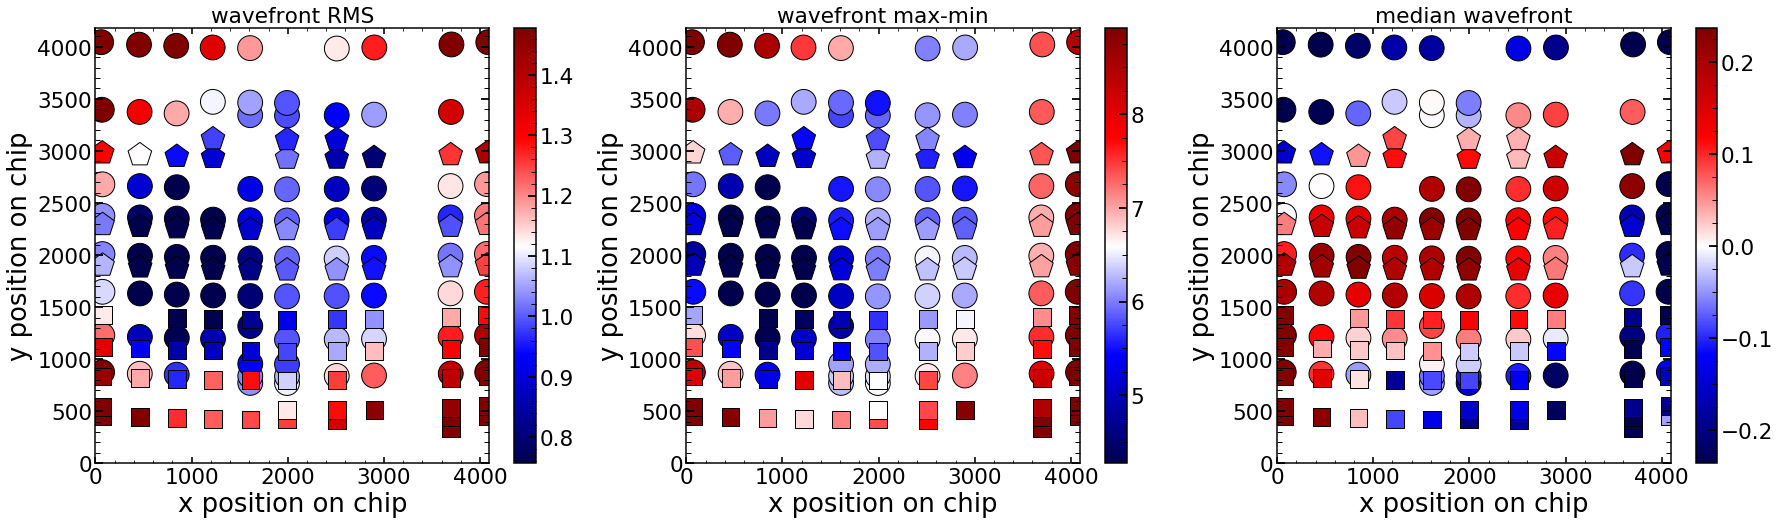

In [287]:
matplotlib.rcParams.update({'font.size': 18})


plt.figure(figsize=(30,8))

plt.subplot(131)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront RMS')
plt.colorbar()


plt.subplot(132)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront max-min')
plt.colorbar()

plt.subplot(133)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('median wavefront')
plt.colorbar()

## wavefront across the detecor?

## Creating array_of_arrays

### removing broad lines 

In [ ]:
broad_lines_wavelength=['826.6699', '852.4029','922.7301']

### creating solution with broad lines 

In [311]:
results_of_fit_many_direct_Ne.loc[29]

z4                 0.430099
z5                 0.320066
z6                -0.618738
z7                 0.743808
z8                 0.143268
                   ...     
pixel_effect       0.350001
fiber_r            1.795020
flux               0.998490
chi2              11.834651
chi2max         6818.895020
Name: 29, Length: 44, dtype: float64

In [288]:
model = LN_PFS_single(sci_image,var_image,dithering=1,save=0,verbosity=0,zmax=22,npix=1536,simulation_00=True)   
       
model(minchain)

npix_value:1536


-4307.905000980697

In [511]:
results_of_fit_many_direct_HgAr.index.values

array([  1,   3,   5,   6,   7,   8,   9,  11,  13,  15,  17,  18,  19,
        20,  21,  23,  25,  27,  29,  30,  31,  32,  33,  35,  39,  41,
        42,  43,  46,  47,  48,  49,  50,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,  70,  73,
        75,  77,  78,  79,  80,  81,  83,  85,  87,  89,  90,  91,  92,
        93,  95,  97,  99, 101, 102, 103, 104, 105, 107, 109, 111, 113,
       114, 115, 116, 119])

In [516]:
results_of_fit_many_direct_HgAr.iloc[0]

z4                 1.057901
z5                 0.263215
z6                -0.136931
z7                 0.491623
z8                 0.640376
                   ...     
pixel_effect       0.350000
fiber_r            1.780571
flux               0.999305
chi2               3.680986
chi2max         1497.676758
Name: 1, Length: 44, dtype: float64

In [509]:
list_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_HgAr.index.values))):
    minchain=results_of_fit_many_direct_HgAr.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut_odd.npy')
    list_of_simulation_00_HgAr_single.append(simulation_00_single)
    positions_of_simulation_00_HgAr_single.append(positions_of_simulation_00_HgAr.iloc[i][:4].values)
    
list_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne_single=[]
positions_of_simulation_00_Ne=finalNe.loc[results_of_fit_many_direct_Ne.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Ne.index.values))):
    minchain=results_of_fit_many_direct_Ne.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut_odd.npy')
    list_of_simulation_00_Ne_single.append(simulation_00_single)
    positions_of_simulation_00_Ne_single.append(positions_of_simulation_00_Ne.iloc[i][:4].values)  
    
list_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr_single=[]
positions_of_simulation_00_Kr=finalKr.loc[results_of_fit_many_direct_Kr.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_Kr.index.values))):
    minchain=results_of_fit_many_direct_Kr.iloc[i].values[:-2]  
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut_odd.npy')
    list_of_simulation_00_Kr_single.append(simulation_00_single)
    positions_of_simulation_00_Kr_single.append(positions_of_simulation_00_Kr.iloc[i][:4].values)

  0%|          | 0/82 [00:00<?, ?it/s]


KeyError: 0

In [290]:
list_of_simulation_00=list_of_simulation_00_HgAr_single+list_of_simulation_00_Ne_single+list_of_simulation_00_Kr_single
array_of_simulation_00=np.array(list_of_simulation_00)

In [291]:
positions_of_simulation_00=np.array(positions_of_simulation_00_HgAr_single+positions_of_simulation_00_Ne_single+positions_of_simulation_00_Kr_single)
positions_of_simulation_00[:,0]=positions_of_simulation_00[:,0].astype(int)
positions_of_simulation_00[:,1]=positions_of_simulation_00[:,1].astype(int)
positions_of_simulation_00[:,2]=positions_of_simulation_00[:,2].astype(int)
positions_of_simulation_00[:,3]=positions_of_simulation_00[:,3].astype(float)

In [292]:
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/array_of_simulation_00_from_Apr1520_v1',array_of_simulation_00)
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/positions_of_simulation_00_from_Apr1520_v1',positions_of_simulation_00)

### creating solution without broad lines (Apr1520_v2)

In [670]:
results_of_fit_many_direct_HgAr_no_broad=results_of_fit_many_direct_HgAr.copy(deep=True)

In [671]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='922.7301']

fiber    xc    yc wavelength close  lamp xc_effective second_offset  \
10      2    65  3517   922.7301     0  HgAr           65         22.44   
22     63   458  3495   922.7301     0  HgAr          458         22.44   
34    192   843  3481   922.7301     0  HgAr          843         22.44   
46    255  1221  3471   922.7301     0  HgAr         1221         22.44   
58    339  1609  3464   922.7301     0  HgAr         1609         22.44   
70    401  1992  3460   922.7301     0  HgAr         1992         22.44   
82    464  2440  3463   922.7301     0  HgAr         2509         22.44   
94    525  2829  3469   922.7301     0  HgAr         2898         22.44   
106   587  3629  3495   922.7301     0  HgAr         3698         22.44   
118   650  4009  3515   922.7301     0  HgAr         4078         22.44   

    second_ratio second2_offset second2_ratio  
10         0.022         -13.14         0.011  
22         0.022         -13.14         0.011  
34         0.022         -13.14         0.011  
46         0.022         -13.14         0.011  
58         0.022         -13.14         0.011  
70         0.022         -13.14         0.011  
82         0.022         -13.14         0.011  
94         0.022         -13.14         0.011  
106        0.022         -13.14         0.011  
118        0.022         -13.14         0.011

In [672]:
np.unique(finalHgAr_Feb2020_dataset['wavelength'].values)

array(['690.9346', '696.7261', '706.8989', '727.47876', '738.6248',
       '763.74286', '795.0522', '826.6699', '852.4029', '912.5693',
       '922.7301', '966.0642'], dtype=object)

In [673]:
np.unique(finalNe_Feb2020_dataset['wavelength'].values)

array(['650.84186', '653.4774', '660.0668', '668.01764', '671.9268',
       '693.13116', '717.59015', '724.72437', '744.1276'], dtype=object)

In [674]:
np.unique(finalKr_Feb2020_dataset['wavelength'].values)

array([785.48, 819.0, 877.68, 892.87], dtype=object)

In [675]:
grat_827=[]
for id in finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='826.6699'].index:
    try:
        grat_827.append(results_of_fit_many_direct_HgAr.loc[id]['grating_lines'])
    except:
        pass
    
    
grat_852=[]
for id in finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='852.4029'].index:
    try:
        grat_852.append(results_of_fit_many_direct_HgAr.loc[id]['grating_lines'])
    except:
        pass


grat_922=[]
for id in finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='922.7301'].index:
    try:
        grat_922.append(results_of_fit_many_direct_HgAr.loc[id]['grating_lines'])
    except:
        pass

In [676]:
grat_922

[7983.652039463646, 7809.508867417477, 7907.768393293661]

In [677]:
finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='795.0522'].index.values

array([  6,  18,  30,  42,  54,  66,  78,  90, 102, 114])

In [678]:
grat_922=results_of_fit_many_direct_HgAr.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='922.7301'].index.values]['grating_lines'].values
print(grat_922[~np.isnan(grat_922)])

grat_852=results_of_fit_many_direct_HgAr.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='852.4029'].index.values]['grating_lines'].values
print(grat_852[~np.isnan(grat_852)])

grat_827=results_of_fit_many_direct_HgAr.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='826.6699'].index.values]['grating_lines'].values
print(grat_827[~np.isnan(grat_827)])


print('##########')

grat_912=results_of_fit_many_direct_HgAr.loc[finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='912.5693'].index.values]['grating_lines'].values
print(grat_912[~np.isnan(grat_912)])

grat_893=results_of_fit_many_direct_Kr.loc[finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['wavelength']==892.87].index.values]['grating_lines'].values
print(grat_893[~np.isnan(grat_893)])

grat_878=results_of_fit_many_direct_Kr.loc[finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['wavelength']==877.68].index.values]['grating_lines'].values
print(grat_878[~np.isnan(grat_878)])

grat_819=results_of_fit_many_direct_Kr.loc[finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['wavelength']==819.0].index.values]['grating_lines'].values
print(grat_819[~np.isnan(grat_819)])

[7983.65203946 7809.50886742 7907.76839329]
[9179.19498415 9678.76915987 9333.89887355 9753.93362658 9349.87392329
 8925.92998396 9093.31454634 9280.88438273 8610.86994355]
[ 9748.29511234 10153.62846272  9506.78806668  9724.67348465
 10013.67258929  9930.28594493  9392.42986242  9413.39986393
 10382.81516355  9391.27732086]
##########
[47751.68964183 48357.68466445 42793.28004317 40978.226055
 41648.92278215 41752.21167219 49563.59432069 53006.02879539]
[59963.14037703 55284.47586284 55612.28419287]
[25666.2620834  24496.92720409 23532.94762673 24331.53179149
 21924.26113907 21889.31131903 21580.08625812 27441.53530197
 21924.58236678]
[27623.33152921 28731.4051772  26146.3047695  28533.75606852
 28846.00909475 27843.87008708 25526.33559238 25969.77312966
 32670.53335334 26771.49704416]


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label wil

In [682]:
print(finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='922.7301'].index.values)
print(finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='852.4029'].index.values)
print(finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='826.6699'].index.values)

for id in finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='922.7301'].index.values:
    try:
        results_of_fit_many_direct_HgAr_no_broad.loc[id][columns22.index('grating_lines')]=42000
    except:
        pass
for id in finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='852.4029'].index.values:
    try:
        results_of_fit_many_direct_HgAr_no_broad.loc[id][columns22.index('grating_lines')]=25000
    except:
        pass
for id in finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['wavelength']=='826.6699'].index.values:
    try:
        results_of_fit_many_direct_HgAr_no_broad.loc[id][columns22.index('grating_lines')]=25000
    except:
        pass

[ 10  22  34  46  58  70  82  94 106 118]
[  8  20  32  44  56  68  80  92 104 116]
[  7  19  31  43  55  67  79  91 103 115]


In [683]:
model = LN_PFS_single(sci_image,var_image,dithering=1,save=0,verbosity=0,zmax=22,npix=1536,simulation_00=True)   
       
model(minchain)

npix_value:1536


-inf

In [687]:
list_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr_single=[]
positions_of_simulation_00_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_no_broad.index.values][['fiber','xc','yc','wavelength']]
for i in tqdm(range(len(results_of_fit_many_direct_HgAr_no_broad.index.values))):
    minchain=results_of_fit_many_direct_HgAr_no_broad.iloc[i].values[:-2]  
    print(i,positions_of_simulation_00_HgAr.iloc[i],results_of_fit_many_direct_HgAr_no_broad.iloc[i]['grating_lines'])
    model(minchain)
    simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut_odd.npy')
    list_of_simulation_00_HgAr_single.append(simulation_00_single)
    positions_of_simulation_00_HgAr_single.append(positions_of_simulation_00_HgAr.iloc[i][:4].values)
    
    
# you can take Neon and Krypton from broad line analysis

  0%|          | 0/82 [00:00<?, ?it/s]

0 fiber                2
xc                  69
yc                 875
wavelength    696.7261
Name: 1, dtype: object 45188.335161841234


  1%|          | 1/82 [00:03<04:45,  3.52s/it]

1 fiber                 2
xc                   71
yc                 1229
wavelength    727.47876
Name: 3, dtype: object 28238.961665824234


  2%|▏         | 2/82 [00:06<04:29,  3.37s/it]

2 fiber                 2
xc                   73
yc                 1647
wavelength    763.74286
Name: 5, dtype: object 45718.48489228844


  4%|▎         | 3/82 [00:09<04:21,  3.31s/it]

3 fiber                2
xc                  73
yc                2009
wavelength    795.0522
Name: 6, dtype: object 39621.703791790125


  5%|▍         | 4/82 [00:13<04:23,  3.37s/it]

4 fiber                2
xc                  72
yc                2377
wavelength    826.6699
Name: 7, dtype: object 25000.0


  6%|▌         | 5/82 [00:16<04:15,  3.32s/it]

5 fiber                2
xc                  72
yc                2679
wavelength    852.4029
Name: 8, dtype: object 25000.0


  7%|▋         | 6/82 [00:20<04:13,  3.34s/it]

6 fiber                2
xc                  66
yc                3395
wavelength    912.5693
Name: 9, dtype: object 47751.689641831625


  9%|▊         | 7/82 [00:23<04:10,  3.34s/it]

7 fiber                2
xc                  59
yc                4044
wavelength    966.0642
Name: 11, dtype: object 24998.62729209023


 10%|▉         | 8/82 [00:26<04:07,  3.35s/it]

8 fiber               63
xc                 461
yc                 860
wavelength    696.7261
Name: 13, dtype: object 58608.22610597152


 11%|█         | 9/82 [00:29<04:02,  3.33s/it]

9 fiber                63
xc                  462
yc                 1214
wavelength    727.47876
Name: 15, dtype: object 35370.492242682994


 12%|█▏        | 10/82 [00:33<03:58,  3.32s/it]

10 fiber                63
xc                  463
yc                 1631
wavelength    763.74286
Name: 17, dtype: object 52199.867171437334


 13%|█▎        | 11/82 [00:36<03:53,  3.29s/it]

11 fiber               63
xc                 463
yc                1993
wavelength    795.0522
Name: 18, dtype: object 47288.51171183474


 15%|█▍        | 12/82 [00:39<03:49,  3.27s/it]

12 fiber               63
xc                 463
yc                2361
wavelength    826.6699
Name: 19, dtype: object 25000.0


 16%|█▌        | 13/82 [00:42<03:45,  3.26s/it]

13 fiber               63
xc                 462
yc                2662
wavelength    852.4029
Name: 20, dtype: object 25000.0


 17%|█▋        | 14/82 [00:45<03:41,  3.26s/it]

14 fiber               63
xc                 459
yc                3374
wavelength    912.5693
Name: 21, dtype: object 48357.68466444862


 18%|█▊        | 15/82 [00:48<03:38,  3.26s/it]

15 fiber               63
xc                 453
yc                4020
wavelength    966.0642
Name: 23, dtype: object 24636.76902372997


 20%|█▉        | 16/82 [00:52<03:36,  3.28s/it]

16 fiber              192
xc                 845
yc                 851
wavelength    696.7261
Name: 25, dtype: object 55347.75224643158


 21%|██        | 17/82 [00:55<03:33,  3.28s/it]

17 fiber               192
xc                  846
yc                 1203
wavelength    727.47876
Name: 27, dtype: object 34530.423326808734


 22%|██▏       | 18/82 [00:59<03:29,  3.28s/it]

18 fiber               192
xc                  846
yc                 1620
wavelength    763.74286
Name: 29, dtype: object 44172.74816027512


 23%|██▎       | 19/82 [01:02<03:27,  3.29s/it]

19 fiber              192
xc                 847
yc                1982
wavelength    795.0522
Name: 30, dtype: object 39153.71792916746


 24%|██▍       | 20/82 [01:05<03:23,  3.29s/it]

20 fiber              192
xc                 846
yc                2350
wavelength    826.6699
Name: 31, dtype: object 25000.0


 26%|██▌       | 21/82 [01:08<03:20,  3.28s/it]

21 fiber              192
xc                 846
yc                2651
wavelength    852.4029
Name: 32, dtype: object 25000.0


 27%|██▋       | 22/82 [01:12<03:16,  3.28s/it]

22 fiber              192
xc                 844
yc                3360
wavelength    912.5693
Name: 33, dtype: object 42793.28004316598


 28%|██▊       | 23/82 [01:15<03:13,  3.28s/it]

23 fiber              192
xc                 840
yc                4009
wavelength    966.0642
Name: 35, dtype: object 23275.742488799304


 29%|██▉       | 24/82 [01:18<03:10,  3.28s/it]

24 fiber               255
xc                 1223
yc                 1195
wavelength    727.47876
Name: 39, dtype: object 28937.515656748626


 30%|███       | 25/82 [01:22<03:07,  3.28s/it]

25 fiber               255
xc                 1224
yc                 1612
wavelength    763.74286
Name: 41, dtype: object 47381.68600060107


 32%|███▏      | 26/82 [01:25<03:03,  3.28s/it]

26 fiber              255
xc                1224
yc                1974
wavelength    795.0522
Name: 42, dtype: object 43769.17549989293


 33%|███▎      | 27/82 [01:28<03:00,  3.28s/it]

27 fiber              255
xc                1223
yc                2340
wavelength    826.6699
Name: 43, dtype: object 25000.0


 34%|███▍      | 28/82 [01:31<02:57,  3.28s/it]

28 fiber              255
xc                1221
yc                3471
wavelength    922.7301
Name: 46, dtype: object 42000.0


 35%|███▌      | 29/82 [01:35<02:53,  3.28s/it]

29 fiber              255
xc                1219
yc                3993
wavelength    966.0642
Name: 47, dtype: object 23902.17188662319


 37%|███▋      | 30/82 [01:38<02:50,  3.28s/it]

30 fiber              339
xc                1610
yc                 772
wavelength    690.9346
Name: 48, dtype: object 19217.267022130363


 38%|███▊      | 31/82 [01:41<02:46,  3.27s/it]

31 fiber              339
xc                1610
yc                 838
wavelength    696.7261
Name: 49, dtype: object 74285.09634123389


 39%|███▉      | 32/82 [01:44<02:43,  3.27s/it]

32 fiber              339
xc                1610
yc                 955
wavelength    706.8989
Name: 50, dtype: object 55011.77444756479


 40%|████      | 33/82 [01:47<02:39,  3.26s/it]

33 fiber              339
xc                1610
yc                1318
wavelength    738.6248
Name: 52, dtype: object 42952.367129932114


 41%|████▏     | 34/82 [01:50<02:36,  3.26s/it]

34 fiber               339
xc                 1610
yc                 1606
wavelength    763.74286
Name: 53, dtype: object 51666.239800515774


 43%|████▎     | 35/82 [01:53<02:33,  3.26s/it]

35 fiber              339
xc                1610
yc                1968
wavelength    795.0522
Name: 54, dtype: object 47659.58851011311


 44%|████▍     | 36/82 [01:57<02:29,  3.25s/it]

36 fiber              339
xc                1610
yc                2334
wavelength    826.6699
Name: 55, dtype: object 25000.0


 45%|████▌     | 37/82 [02:00<02:26,  3.25s/it]

37 fiber              339
xc                1610
yc                2635
wavelength    852.4029
Name: 56, dtype: object 25000.0


 46%|████▋     | 38/82 [02:03<02:23,  3.25s/it]

38 fiber              339
xc                1609
yc                3343
wavelength    912.5693
Name: 57, dtype: object 40978.226054999985


 48%|████▊     | 39/82 [02:06<02:19,  3.25s/it]

39 fiber              339
xc                1609
yc                3464
wavelength    922.7301
Name: 58, dtype: object 42000.0


 49%|████▉     | 40/82 [02:10<02:17,  3.26s/it]

40 fiber              339
xc                1608
yc                3987
wavelength    966.0642
Name: 59, dtype: object 17549.534130947406


 50%|█████     | 41/82 [02:14<02:14,  3.27s/it]

41 fiber              401
xc                1992
yc                 771
wavelength    690.9346
Name: 60, dtype: object 16266.770081133465


 51%|█████     | 42/82 [02:17<02:10,  3.27s/it]

42 fiber              401
xc                1992
yc                 836
wavelength    696.7261
Name: 61, dtype: object 58161.24858856209


 52%|█████▏    | 43/82 [02:20<02:07,  3.27s/it]

43 fiber              401
xc                1992
yc                 952
wavelength    706.8989
Name: 62, dtype: object 53277.10297568141


 54%|█████▎    | 44/82 [02:23<02:04,  3.27s/it]

44 fiber               401
xc                 1992
yc                 1187
wavelength    727.47876
Name: 63, dtype: object 33000.49172317896


 55%|█████▍    | 45/82 [02:27<02:00,  3.27s/it]

45 fiber               401
xc                 1992
yc                 1603
wavelength    763.74286
Name: 65, dtype: object 51246.38888374298


 56%|█████▌    | 46/82 [02:30<01:57,  3.27s/it]

46 fiber              401
xc                1992
yc                1965
wavelength    795.0522
Name: 66, dtype: object 47521.64325272848


 57%|█████▋    | 47/82 [02:33<01:54,  3.27s/it]

47 fiber              401
xc                1992
yc                2332
wavelength    826.6699
Name: 67, dtype: object 25000.0


 59%|█████▊    | 48/82 [02:36<01:51,  3.27s/it]

48 fiber              401
xc                1992
yc                2631
wavelength    852.4029
Name: 68, dtype: object 25000.0


 60%|█████▉    | 49/82 [02:40<01:47,  3.27s/it]

49 fiber              401
xc                1992
yc                3340
wavelength    912.5693
Name: 69, dtype: object 41648.92278215209


 61%|██████    | 50/82 [02:43<01:44,  3.27s/it]

50 fiber              401
xc                1992
yc                3460
wavelength    922.7301
Name: 70, dtype: object 42000.0


 62%|██████▏   | 51/82 [02:46<01:41,  3.27s/it]

51 fiber              464
xc                2440
yc                 839
wavelength    696.7261
Name: 73, dtype: object 50345.08915420817


 63%|██████▎   | 52/82 [02:49<01:37,  3.27s/it]

52 fiber               464
xc                 2440
yc                 1190
wavelength    727.47876
Name: 75, dtype: object 28653.888767057248


 65%|██████▍   | 53/82 [02:53<01:34,  3.27s/it]

53 fiber               464
xc                 2439
yc                 1606
wavelength    763.74286
Name: 77, dtype: object 45111.679920562914


 66%|██████▌   | 54/82 [02:56<01:31,  3.27s/it]

54 fiber              464
xc                2439
yc                1967
wavelength    795.0522
Name: 78, dtype: object 40550.92886236069


 67%|██████▋   | 55/82 [03:00<01:28,  3.27s/it]

55 fiber              464
xc                2439
yc                2334
wavelength    826.6699
Name: 79, dtype: object 25000.0


 68%|██████▊   | 56/82 [03:03<01:25,  3.27s/it]

56 fiber              464
xc                2440
yc                2634
wavelength    852.4029
Name: 80, dtype: object 25000.0


 70%|██████▉   | 57/82 [03:06<01:21,  3.27s/it]

57 fiber              464
xc                2440
yc                3342
wavelength    912.5693
Name: 81, dtype: object 41752.21167219007


 71%|███████   | 58/82 [03:09<01:18,  3.27s/it]

58 fiber              464
xc                2441
yc                3983
wavelength    966.0642
Name: 83, dtype: object 19116.602522205638


 72%|███████▏  | 59/82 [03:12<01:15,  3.26s/it]

59 fiber              525
xc                2828
yc                 843
wavelength    696.7261
Name: 85, dtype: object 45665.050106164956


 73%|███████▎  | 60/82 [03:15<01:11,  3.26s/it]

60 fiber               525
xc                 2828
yc                 1195
wavelength    727.47876
Name: 87, dtype: object 30658.694153820114


 74%|███████▍  | 61/82 [03:18<01:08,  3.26s/it]

61 fiber               525
xc                 2827
yc                 1611
wavelength    763.74286
Name: 89, dtype: object 47400.27907956759


 76%|███████▌  | 62/82 [03:22<01:05,  3.26s/it]

62 fiber              525
xc                2827
yc                1972
wavelength    795.0522
Name: 90, dtype: object 39234.56075208071


 77%|███████▋  | 63/82 [03:25<01:01,  3.26s/it]

63 fiber              525
xc                2827
yc                2339
wavelength    826.6699
Name: 91, dtype: object 25000.0


 78%|███████▊  | 64/82 [03:28<00:58,  3.25s/it]

64 fiber              525
xc                2828
yc                2639
wavelength    852.4029
Name: 92, dtype: object 25000.0


 79%|███████▉  | 65/82 [03:31<00:55,  3.25s/it]

65 fiber              525
xc                2829
yc                3348
wavelength    912.5693
Name: 93, dtype: object 49563.59432068557


 80%|████████  | 66/82 [03:34<00:52,  3.25s/it]

66 fiber              525
xc                2831
yc                3993
wavelength    966.0642
Name: 95, dtype: object 22933.096148400782


 82%|████████▏ | 67/82 [03:38<00:48,  3.26s/it]

67 fiber              587
xc                3626
yc                 862
wavelength    696.7261
Name: 97, dtype: object 53787.23562306517


 83%|████████▎ | 68/82 [03:41<00:45,  3.26s/it]

68 fiber               587
xc                 3624
yc                 1214
wavelength    727.47876
Name: 99, dtype: object 37180.572313281424


 84%|████████▍ | 69/82 [03:44<00:42,  3.26s/it]

69 fiber               587
xc                 3623
yc                 1632
wavelength    763.74286
Name: 101, dtype: object 55675.39768728753


 85%|████████▌ | 70/82 [03:47<00:39,  3.25s/it]

70 fiber              587
xc                3623
yc                1994
wavelength    795.0522
Name: 102, dtype: object 57443.308531002345


 87%|████████▋ | 71/82 [03:51<00:35,  3.25s/it]

71 fiber              587
xc                3623
yc                2361
wavelength    826.6699
Name: 103, dtype: object 25000.0


 88%|████████▊ | 72/82 [03:54<00:32,  3.26s/it]

72 fiber              587
xc                3624
yc                2662
wavelength    852.4029
Name: 104, dtype: object 25000.0


 89%|████████▉ | 73/82 [03:57<00:29,  3.26s/it]

73 fiber              587
xc                3628
yc                3374
wavelength    912.5693
Name: 105, dtype: object 53006.02879538988


 90%|█████████ | 74/82 [04:00<00:26,  3.26s/it]

74 fiber              587
xc                3633
yc                4022
wavelength    966.0642
Name: 107, dtype: object 24475.78238099797


 91%|█████████▏| 75/82 [04:04<00:22,  3.26s/it]

75 fiber              650
xc                4005
yc                 875
wavelength    696.7261
Name: 109, dtype: object 30917.583805084312


 93%|█████████▎| 76/82 [04:07<00:19,  3.26s/it]

76 fiber               650
xc                 4003
yc                 1229
wavelength    727.47876
Name: 111, dtype: object 32214.09863709455


 94%|█████████▍| 77/82 [04:10<00:16,  3.26s/it]

77 fiber               650
xc                 4002
yc                 1647
wavelength    763.74286
Name: 113, dtype: object 48485.07138521521


 95%|█████████▌| 78/82 [04:13<00:13,  3.26s/it]

78 fiber              650
xc                4002
yc                2011
wavelength    795.0522
Name: 114, dtype: object 41398.5998658049


 96%|█████████▋| 79/82 [04:17<00:09,  3.25s/it]

79 fiber              650
xc                4002
yc                2379
wavelength    826.6699
Name: 115, dtype: object 25000.0


 98%|█████████▊| 80/82 [04:20<00:06,  3.25s/it]

80 fiber              650
xc                4003
yc                2681
wavelength    852.4029
Name: 116, dtype: object 25000.0


 99%|█████████▉| 81/82 [04:23<00:03,  3.25s/it]

81 fiber              650
xc                4016
yc                4044
wavelength    966.0642
Name: 119, dtype: object 19142.01430604448


100%|██████████| 82/82 [04:26<00:00,  3.25s/it]


In [688]:
list_of_simulation_00=list_of_simulation_00_HgAr_single+list_of_simulation_00_Ne_single+list_of_simulation_00_Kr_single
array_of_simulation_00=np.array(list_of_simulation_00)

In [689]:
positions_of_simulation_00=np.array(positions_of_simulation_00_HgAr_single+positions_of_simulation_00_Ne_single+positions_of_simulation_00_Kr_single)
positions_of_simulation_00[:,0]=positions_of_simulation_00[:,0].astype(int)
positions_of_simulation_00[:,1]=positions_of_simulation_00[:,1].astype(int)
positions_of_simulation_00[:,2]=positions_of_simulation_00[:,2].astype(int)
positions_of_simulation_00[:,3]=positions_of_simulation_00[:,3].astype(float)

In [690]:
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/array_of_simulation_00_from_Apr1520_v2',array_of_simulation_00)
np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr15_Focus/positions_of_simulation_00_from_Apr1520_v2',positions_of_simulation_00)

#### test 

In [691]:
print(finalHgAr_Feb2020_dataset.loc[58])

fiber                  339
xc                    1609
yc                    3464
wavelength        922.7301
close                    0
                    ...   
xc_effective          1609
second_offset        22.44
second_ratio         0.022
second2_offset      -13.14
second2_ratio        0.011
Name: 58, Length: 11, dtype: object


In [692]:
model = LN_PFS_single(sci_image,var_image,dithering=1,save=0,verbosity=0,zmax=22,npix=1536,simulation_00=True)   
minchain=results_of_fit_many_direct_HgAr_no_broad.loc[58].values[:-2]  
print(results_of_fit_many_direct_HgAr_no_broad.loc[58]['grating_lines'] )
model(minchain)
simulation_00_single_no_broad=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut_odd.npy')

npix_value:1536
42000.0


In [693]:
model = LN_PFS_single(sci_image,var_image,dithering=1,save=0,verbosity=0,zmax=22,npix=1536,simulation_00=True)   
minchain=results_of_fit_many_direct_HgAr.loc[58].values[:-2]      
print(results_of_fit_many_direct_HgAr.loc[58]['grating_lines'] )
model(minchain)
simulation_00_single=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut_odd.npy')

npix_value:1536
7809.508867417477


In [694]:
results_of_fit_many_direct_HgAr_no_broad.loc[58].values[:-2]

array([   -0.17847872,    -0.48417647,    -0.73199433,    -0.04188647,
          -0.09447446,    -0.11842502,    -0.35325183,    -0.13929818,
           0.04926681,     0.04600631,     0.01530665,     0.03710872,
          -0.01185898,     0.00942507,     0.00721298,     0.0026722 ,
          -0.02954917,     0.02288735,     0.02364208,     0.64442555,
           0.08547013,    -0.04579782,     0.16715758,     0.05894031,
           0.03535922,     0.00000717,     0.00000718,     0.97421673,
           0.9483453 ,     0.01574483,    -0.02707121,     0.92364395,
           0.04633775,     0.7160762 ,     1.05560225,     0.16114484,
       42000.        ,     2.48537526,     0.00389293,     0.4306113 ,
           1.82881993,     0.99705226])

In [695]:
results_of_fit_many_direct_HgAr.loc[58].values[:-2]

array([  -0.17847872,   -0.48417647,   -0.73199433,   -0.04188647,
         -0.09447446,   -0.11842502,   -0.35325183,   -0.13929818,
          0.04926681,    0.04600631,    0.01530665,    0.03710872,
         -0.01185898,    0.00942507,    0.00721298,    0.0026722 ,
         -0.02954917,    0.02288735,    0.02364208,    0.64442555,
          0.08547013,   -0.04579782,    0.16715758,    0.05894031,
          0.03535922,    0.00000717,    0.00000718,    0.97421673,
          0.9483453 ,    0.01574483,   -0.02707121,    0.92364395,
          0.04633775,    0.7160762 ,    1.05560225,    0.16114484,
       7809.50886742,    2.48537526,    0.00389293,    0.4306113 ,
          1.82881993,    0.99705226])

In [696]:
LSF_first=simulation_00_single_no_broad[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_first_2d=Zernike_Module.resize(LSF_first,(20,6))
LSF_no_broad=np.sum(LSF_first_2d,axis=1)

LSF_first=simulation_00_single[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_first_2d=Zernike_Module.resize(LSF_first,(20,6))
LSF_broad=np.sum(LSF_first_2d,axis=1)

print(positions_of_simulation_00_HgAr_single[39])
LSF_first=list_of_simulation_00_HgAr_single[39][np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_first_2d=Zernike_Module.resize(LSF_first,(20,6))
LSF_no_broad_from_list=np.sum(LSF_first_2d,axis=1)




[339 1609 3464 '922.7301']


(-0.0001, 0.0005)

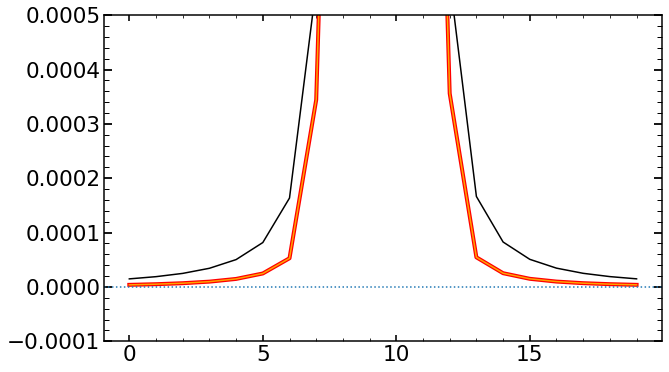

In [697]:
plt.figure(figsize=(10,6))
plt.plot(LSF_no_broad,color='red',label='no broad input, wavelength=922',lw=4)
plt.plot(LSF_no_broad_from_list,color='orange',label='no broad from list input, wavelength=922')
plt.plot(LSF_broad,color='black',label='broad input, wavelength=922')
#plt.plot(LSF_predicted,color='gray',label='predicted')
plt.axhline(0,ls=':')
plt.ylim(-0.0001,0.0005,)

# Apr 16 (interpolation)

## Init scripts 

In [350]:
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/'

# where are the dataframe which we use to guess the initial solution
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_preApril20run_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_preApril20run_Ne=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_direct_preApril20run_Kr=pickle.load(f)
    

# where are the dataframe which we use to guess the initial solution
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_HgAr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preApril20run_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Ne_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preApril20run_Ne=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_interpolation_Kr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_interpolation_preApril20run_Kr=pickle.load(f)

In [364]:
list_of_HgAr_to_analyze_10=np.array_split(results_of_fit_many_interpolation_preApril20run_HgAr['0p'].index.astype(int).values,len(results_of_fit_many_interpolation_preApril20run_HgAr['0p'])/4)

list_of_Ne_to_analyze_10=np.array_split(results_of_fit_many_interpolation_preApril20run_Ne['0p'].index.astype(int).values,len(results_of_fit_many_interpolation_preApril20run_Ne['0p'])/4)

list_of_Kr_to_analyze_10=np.array_split(results_of_fit_many_interpolation_preApril20run_Kr['0p'].index.astype(int).values,len(results_of_fit_many_interpolation_preApril20run_Kr['0p'])/4)

In [365]:
print(list_of_HgAr_to_analyze_10)
print('\n')
print(list_of_Ne_to_analyze_10)
print('\n')
print(list_of_Kr_to_analyze_10)

[array([1, 3, 5, 6]), array([ 7,  8,  9, 11]), array([13, 15, 17, 18]), array([19, 20, 21, 23]), array([25, 27, 29, 30]), array([31, 32, 33, 35]), array([39, 41, 42, 43]), array([45, 46, 47, 48]), array([49, 50, 52, 53]), array([54, 55, 56, 57]), array([58, 59, 60, 61]), array([62, 63, 65, 66]), array([67, 68, 69, 70]), array([73, 75, 77, 78]), array([79, 80, 81, 83]), array([85, 87, 89, 90]), array([91, 92, 93, 95]), array([ 97,  99, 101, 102]), array([103, 104, 105, 107]), array([109, 111, 113, 114]), array([115, 116, 117, 119])]


[array([2, 3, 5, 6]), array([ 8, 11, 12, 14]), array([15, 20, 23, 24]), array([26, 29, 30, 31]), array([32, 33, 35, 38]), array([39, 41, 42, 44]), array([45, 47, 48, 50]), array([51, 53, 54, 56]), array([57, 59, 60, 62]), array([63, 66, 69, 71]), array([72, 74, 75, 77]), array([78, 80, 81, 83]), array([84, 86, 87, 89])]


[array([0, 1, 2, 4, 5]), array([ 6,  8,  9, 10, 12]), array([13, 14, 15, 16]), array([17, 18, 19, 20]), array([21, 22, 23, 24]), array([

In [366]:
def remove(string): 
    return string.replace(" ", "")

for i in range(len(list_of_HgAr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T07'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_HgAr_to_analyze_10[i]:
        if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21346+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 HgAr "+str(double_source)+\
                   " "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 interpolation Apr16 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger07_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_HgAr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T07'+str(i)+'Apr_focus.sh \n')

file.close()


for i in range(len(list_of_Ne_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T08'+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Ne_to_analyze_10[i]:
        if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21550+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Ne "+str(double_source)+\
                   " "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 interpolation Apr16 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger08_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_Ne_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T08'+str(i)+'Apr_focus.sh \n')

file.close()

number_of_run='09'
for i in range(len(list_of_Kr_to_analyze_10)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+number_of_run+str(i)+'Apr_focus.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for single_spot in list_of_Kr_to_analyze_10[i]:
        if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
            double_source=1
        else:
            double_source=0           
        for obs in [str(21754+54)]:
            file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py "+str(obs)+" "+str(single_spot)+\
                   " 40 5 4 Kr "+str(double_source)+\
                   " "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+" 22 Mar06 interpolation Apr16 focus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AprScriptToSubmitScriptsTiger'+number_of_run+'_focus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")

for i in range(len(list_of_Kr_to_analyze_10)):
    file.write('sbatch /home/ncaplar/Scripts/T'+number_of_run+str(i)+'Apr_focus.sh \n')

file.close()





# Faster create_result()

In [35]:
results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)


results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

for single_number in unique_numbers_with_5_or_more_images_Ne[5:6]:

    # result from the defocused analysis
    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)  
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()
    solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                          err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=True,return_solution_at_05_0_05=None)    
    

            
#for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
#    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]

12 obs (Emcee3, defocus): 21556 is found!
12 obs (Emcee3, defocus): 21568 is found!
12 obs (Emcee3, defocus): 21586 is found!
12 obs (Emcee3, defocus): 21598 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee2, defocus): 21610 is found!
12 obs (Emcee2, defocus): 21622 is found!
12 obs (Emcee3, defocus): 21640 is found!
12 obs (Emcee3, defocus): 21646 is found!
12 obs (Emcee3, defocus): 21652 is found!
12 obs (Emcee3, defocus): 21604 is found!


In [45]:
    result_analysis=Zernike_result_analysis(date,single_number,'Ne',22,4)  
    %prun results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=\
    result_analysis.create_results_of_fit_single()

12 obs (Emcee3, defocus): 21556 is found!
12 obs (Emcee3, defocus): 21568 is found!
12 obs (Emcee3, defocus): 21586 is found!
12 obs (Emcee3, defocus): 21598 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee3, defocus): 21604 is found!
12 obs (Emcee2, defocus): 21610 is found!
12 obs (Emcee2, defocus): 21622 is found!
12 obs (Emcee3, defocus): 21640 is found!
12 obs (Emcee3, defocus): 21646 is found!
12 obs (Emcee3, defocus): 21652 is found!
12 obs (Emcee3, defocus): 21604 is found!
 

In [96]:
solution_at_0=result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                      err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=None)

Empty DataFrame
Columns: [z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20, z21, z22, hscFrac, strutFrac, dxFocal, dyFocal, slitFrac, slitFrac_dy, radiometricEffect, radiometricExponent, x_ilum, y_ilum, x_fiber, y_fiber, effective_radius_illumination, frd_sigma, frd_lorentz_factor, det_vert, slitHolder_frac_dx, grating_lines, scattering_slope, scattering_amplitude, pixel_effect, fiber_r, flux, chi2, chi2max]
Index: []

[0 rows x 44 columns]
0


In [92]:
results_of_fit_single

z4        z5        z6        z7        z8        z9       z10  \
-4.0  30.889953 -0.782896 -0.380881  0.557414  0.284642 -0.084343 -0.306468   
-3.5  27.196036 -0.638222 -0.287460  0.554352  0.291296 -0.088280 -0.340491   
-3.0  22.999411 -0.397099 -0.238579  0.488047  0.289071 -0.031435 -0.259940   
-2.5  19.560455 -0.218395 -0.279414  0.481649  0.230988 -0.033748 -0.327135   
-2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
-1.5  11.810266 -0.006752 -0.150153  0.410283  0.327476 -0.014559 -0.295522   
-1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
-0.5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1.5  -10.811823  0.446391  0.105402  0.256629  0.392452  0.019042 -0.285661   
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2.5  -18.141435  0.683509  0.239461  0.234516  0.389751  0.026702 -0.249933   
3.0  -22.281546  0.862032  0.167017  0.210031  0.377126  0.010837 -0.242116   
3.5  -25.923939  0.990971  0.239243  0.188792  0.372132  0.041987 -0.225646   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           z11       z12       z13  ...  det_vert  slitHolder_frac_dx  \
-4.0 -0.216152 -0.171049 -0.061664  ...  0.991876            0.525868   
-3.5 -0.217878 -0.178047 -0.070563  ...  1.008408            0.518896   
-3.0 -0.279464 -0.167414 -0.076414  ...  0.984736            0.532994   
-2.5 -0.266683 -0.164985 -0.082541  ...  0.993655            0.496347   
-2    0.000000  0.000000  0.000000  ...  0.000000            0.000000   
-1.5 -0.236938 -0.164145 -0.099247  ...  1.007921            0.535437   
-1    0.000000  0.000000  0.000000  ...  0.000000            0.000000   
-0.5  0.000000  0.000000  0.000000  ...  0.000000            0.000000   
0     0.000000  0.000000  0.000000  ...  0.000000            0.000000   
0     0.000000  0.000000  0.000000  ...  0.000000            0.000000   
0.5   0.000000  0.000000  0.000000  ...  0.000000            0.000000   
1     0.000000  0.000000  0.000000  ...  0.000000            0.000000   
1.5  -0.278056 -0.100134 -0.027060  ...  0.999156            0.527663   
2     0.000000  0.000000  0.000000  ...  0.000000            0.000000   
2.5  -0.241880 -0.093584 -0.026412  ...  0.994824            0.519671   
3.0  -0.226866 -0.071815 -0.033588  ...  1.003644            0.506122   
3.5  -0.252477 -0.073209 -0.039984  ...  1.009331            0.503698   
4     0.000000  0.000000  0.000000  ...  0.000000            0.000000   

      grating_lines  scattering_slope  scattering_amplitude  pixel_effect  \
-4.0   96628.201844          2.401770              0.004114      0.372592   
-3.5   94507.119689          2.188352              0.001853      0.372592   
-3.0  100528.726320          2.163521              0.001614      0.372592   
-2.5  111013.702104          2.433925              0.003749      0.372592   
-2         0.000000          0.000000              0.000000      0.000000   
-1.5  100321.635293          2.367024              0.003339      0.372592   
-1         0.000000          0.000000              0.000000      0.000000   
-0.5       0.000000          0.000000              0.000000      0.000000   
0          0.000000          0.000000              0.000000      0.000000   
0          0.000000          0.000000              0.000000      0.000000   
0.5        0.000000          0.000000              0.000000      0.000000   
1          0.000000          0.000000              0.000000      0.000000   
1.5    92690.816386          2.258667              0.002146      0.372592   
2          0.000000          0.000000        

In [93]:
        results_of_fit_single_near_focus=results_of_fit_single[int(len(results_of_fit_single)/2)-2:int(len(results_of_fit_single)/2)+2]    
        results_of_fit_single_near_focus=results_of_fit_single_near_focus[np.abs(results_of_fit_single_near_focus['z4'])>0]
        
        print(len(results_of_fit_single_near_focus))

0


In [42]:
%prun result_analysis.solution_at_0_and_plots(results_of_fit_single,err_results_of_fit_single,\
                                      err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=False,return_solution_at_05_0_05=None)

In [ ]:
    def create_minchain_err(self,chain0,likechain0,sci_image,var_image,old=0):
        """create error on the parameters from the chains
        @param chain0      
        @param likechain0  
        @param sci_image  
        @param var_image  
        @param old 
        
        @returns        
        """
        columns22=self.columns22
        columns11=self.columns11

        minchain_err_test=[]
        if len(chain0[0][0])==42:
            columns=columns22          
        else:
            columns=columns11


        for var_number in range(len(columns)):
            #ravel likelihood
            likechain0_Emcee3_ravel=np.ravel(likechain0)
    
            # connect chain and lnchain
            chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
            chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
            chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
            likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
    
            # move to chi2 space
            # you should take into account mask!
            chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
            min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)
    
            # simplest standard deviation
            std_chain=np.std(chain0_Emcee3_ravel_sort)
    
            #best solution
            mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]
    
            # step size
            step=std_chain/10
            
            # if standard deviation is much much smaller than the mean value aborth the effort
            # and set the erros to be equal to the mean value
            # if the standard deviation is so small it means that there were problems in the fit
            # or you intentionally did not move the variable
            if std_chain<np.abs(mean_chain)/10**6:
                minchain_err_element=[-mean_chain,mean_chain]
            else:
                # create result, go 3*std in each direction
                try:
                    res=[]
                    for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                        selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                        if len(selected_chi2_Emcee3_ravel_sort>10):   
                            res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])
        
                    res=np.array(res)
        
                    #print(columns[var_number]+' min : '+str(mean_chain))
                    #print(columns[var_number]+' std : '+str(std_chain))
        
                    # find low limit and high limit
                    res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
                    minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
                except IndexError:   
                    if self.verbosity==1:
                        print(columns[var_number]+': failed!')
                    minchain_err_element=[-mean_chain,mean_chain]
    
            minchain_err_test.append(minchain_err_element)
            #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
            #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
        if old==1:
            minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
            #print(minchain_err_test)
            return minchain_err_test
        else:       
            return np.array(minchain_err_test)

# Higher order Zernike - initial

In [ ]:
# create module or function that takes images and lower level and wanted order to get the result 

chi**2 reduced is: 43.360858218969405
chi**2 reduced within mask area is: 71.16378135453142
Abs of residual divided by total flux is: 0.04941715164237133
Abs of residual divided by largest value of a flux in the image is: 0.13302947815570831


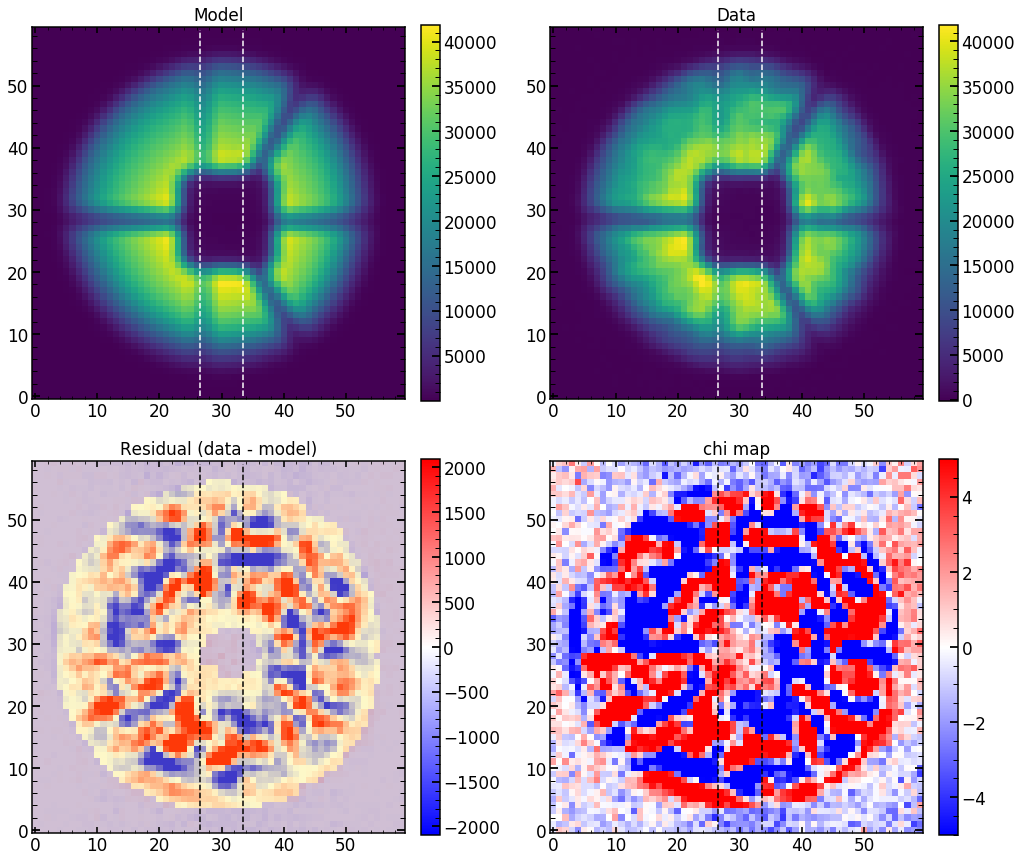

In [384]:
matplotlib.rcParams.update({'font.size': 14})
mask=sci_image>(np.mean([np.median(sci_image[0]),np.median(sci_image[-1]),np.median(sci_image[:,0]),np.median(sci_image[:,-1])])*20)
single_analysis.create_basic_comparison_plot(custom_mask=mask)

chi**2 reduced is: 43.360858218969405
chi**2 reduced within mask area is: 81.96307691501745
Abs of residual divided by total flux is: 0.04941715164237133
Abs of residual divided by largest value of a flux in the image is: 0.13302947815570831


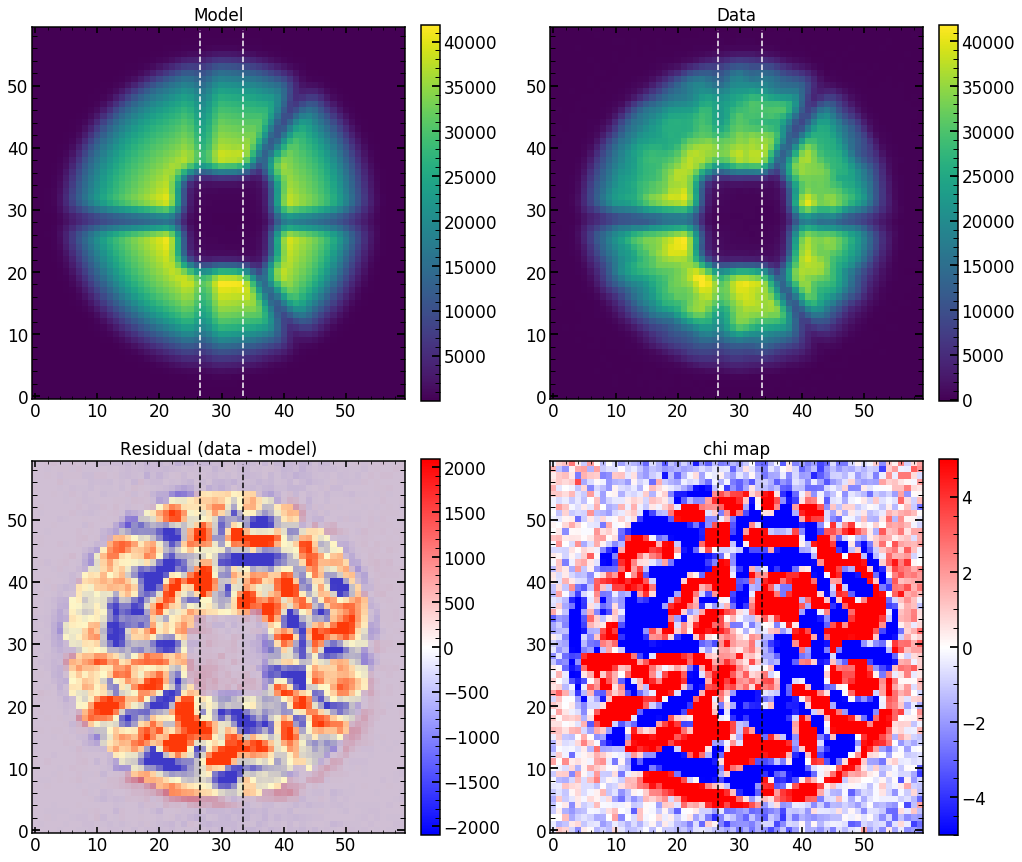

In [388]:
matplotlib.rcParams.update({'font.size': 14})
mask_old=sci_image>(np.max(sci_image)*0.1)
# HgAr_single_image_p4 from the following section
#single_analysis.create_basic_comparison_plot(custom_image=HgAr_single_image_p4,custom_mask=mask,use_max_chi_scaling=True)
single_analysis.create_basic_comparison_plot(custom_mask=mask_old,use_max_chi_scaling=False)

chi**2 reduced is: 42.314048613726314
chi**2 reduced within mask area is: 69.78559034770343
Abs of residual divided by total flux is: 0.0469725810132206
Abs of residual divided by largest value of a flux in the image is: 0.10882630809806217


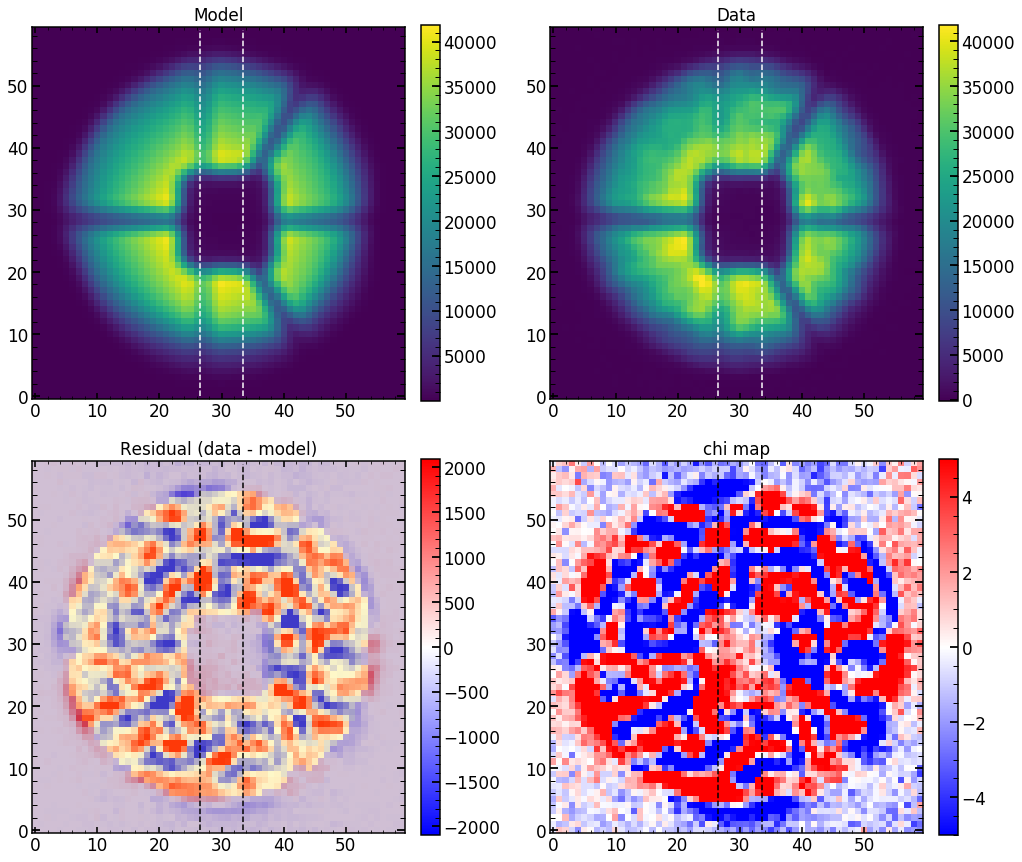

In [390]:
matplotlib.rcParams.update({'font.size': 14})
mask_old=sci_image>(np.max(sci_image)*0.1)
# HgAr_single_image_p4 from the following section
#single_analysis.create_basic_comparison_plot(custom_image=HgAr_single_image_p4,custom_mask=mask,use_max_chi_scaling=True)
single_analysis.create_basic_comparison_plot(custom_image=HgAr_single_image_m4,custom_mask=mask,use_max_chi_scaling=False)

In [393]:
np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/Apr0920/allparameters_proposal_after_iteration_Apr0920_Single_P_21352545HgAr.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/Apr0920/allparameters_proposal_after_iteration_Apr0920_Single_P_21352545HgAr.npy'

# Scripts making for higher order Zernike 

In [ ]:
# which ones are avaliable from Mar06 & have no overlap

In [353]:
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/Mar060120/'


In [436]:
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_HgAr_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_HgAr=pickle.load(f)
with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_Mar06.pkl', 'rb') as f:
    results_of_fit_many_Ne=pickle.load(f)

In [437]:
HgAr_p4_and_only_one=np.intersect1d(results_of_fit_many_HgAr['p4'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_p35_and_only_one=np.intersect1d(results_of_fit_many_HgAr['p35'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_p3_and_only_one=np.intersect1d(results_of_fit_many_HgAr['p3'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_m4_and_only_one=np.intersect1d(results_of_fit_many_HgAr['m4'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_m35_and_only_one=np.intersect1d(results_of_fit_many_HgAr['m35'].index,finalHgAr[finalHgAr['close']=='1'].index)
HgAr_m3_and_only_one=np.intersect1d(results_of_fit_many_HgAr['m3'].index,finalHgAr[finalHgAr['close']=='1'].index)


Ne_p4_and_only_one=np.intersect1d(results_of_fit_many_Ne['p4'].index,finalNe[finalNe['close']=='1'].index)
Ne_p35_and_only_one=np.intersect1d(results_of_fit_many_Ne['p35'].index,finalNe[finalNe['close']=='1'].index)
Ne_p3_and_only_one=np.intersect1d(results_of_fit_many_Ne['p3'].index,finalNe[finalNe['close']=='1'].index)
Ne_m4_and_only_one=np.intersect1d(results_of_fit_many_Ne['m4'].index,finalNe[finalNe['close']=='1'].index)
Ne_m35_and_only_one=np.intersect1d(results_of_fit_many_Ne['m35'].index,finalNe[finalNe['close']=='1'].index)
Ne_m3_and_only_one=np.intersect1d(results_of_fit_many_Ne['m3'].index,finalNe[finalNe['close']=='1'].index)
"""
Kr_p4_and_only_one=np.intersect1d(results_of_fit_many_Kr['p4'].index,finalKr[finalKr['close']=='1'].index)
Kr_p35_and_only_one=np.intersect1d(results_of_fit_many_Kr['p35'].index,finalKr[finalKr['close']=='1'].index)
Kr_p3_and_only_one=np.intersect1d(results_of_fit_many_Kr['p3'].index,finalKr[finalKr['close']=='1'].index)
Kr_m4_and_only_one=np.intersect1d(results_of_fit_many_Kr['m4'].index,finalKr[finalKr['close']=='1'].index)
Kr_m35_and_only_one=np.intersect1d(results_of_fit_many_Kr['m35'].index,finalKr[finalKr['close']=='1'].index)
Kr_m3_and_only_one=np.intersect1d(results_of_fit_many_Kr['m3'].index,finalKr[finalKr['close']=='1'].index)
"""

"\nKr_p4_and_only_one=np.intersect1d(results_of_fit_many_Kr['p4'].index,finalKr[finalKr['close']=='1'].index)\nKr_p35_and_only_one=np.intersect1d(results_of_fit_many_Kr['p35'].index,finalKr[finalKr['close']=='1'].index)\nKr_p3_and_only_one=np.intersect1d(results_of_fit_many_Kr['p3'].index,finalKr[finalKr['close']=='1'].index)\nKr_m4_and_only_one=np.intersect1d(results_of_fit_many_Kr['m4'].index,finalKr[finalKr['close']=='1'].index)\nKr_m35_and_only_one=np.intersect1d(results_of_fit_many_Kr['m35'].index,finalKr[finalKr['close']=='1'].index)\nKr_m3_and_only_one=np.intersect1d(results_of_fit_many_Kr['m3'].index,finalKr[finalKr['close']=='1'].index)\n"

In [438]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_p4_Apr9.sh','w') 
for single_spot in HgAr_p4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21448 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr09 \n")
    
file.close()    
  
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_p35_Apr9.sh','w') 
for single_spot in HgAr_p35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21442 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_p3_Apr9.sh','w') 
for single_spot in HgAr_p3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21436 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_m4_Apr9.sh','w') 
for single_spot in HgAr_m4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21352 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_m35_Apr9.sh','w') 
for single_spot in HgAr_m35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21358 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/HgAr_m3_Apr9.sh','w') 
for single_spot in HgAr_m3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21364 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  


file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_p4_Apr9.sh','w') 
for single_spot in Ne_p4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21652 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_p35_Apr9.sh','w') 
for single_spot in Ne_p35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21648 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_p3_Apr9.sh','w') 
for single_spot in Ne_p3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21642 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_m4_Apr9.sh','w') 
for single_spot in Ne_m4_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21556 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_m35_Apr9.sh','w') 
for single_spot in Ne_m35_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21562 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  

file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Ne_m3_Apr9.sh','w') 
for single_spot in Ne_m3_and_only_one: 
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py 21568 "+str(single_spot)+" 2 5 4 Ne 0 [0,0] 56 Mar06 direct Apr09 \n")
file.close()  
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Apr9ScriptToSubmitScriptsTiger1'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for arc in ['HgAr','Ne']:
    for defocus in ['p4','p35','p3','m3','m35','m4']:
        file.write('sh /home/ncaplar/Scripts/'+str(arc)+'_'+str(defocus)+'_Apr9.sh \n')
file.close()

# Higher order Zernike - analysis 

In [ ]:
# 'final_optpsf'+str(date_of_output)+'20_Single_P_'+str(obs)+str(single_number)+str(eps)+str(arc)

In [70]:
final_optpsfApr0220_Single_P_*855HgAr.npy

21352

In [97]:
HgAr_m4_and_only_one

array([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
        33,  35,  37,  39,  42,  45,  47,  49,  54,  57,  59,  61,  63,
        66,  69,  73,  75,  78,  81,  83,  85,  87,  90,  93,  95,  97,
        99, 102, 105, 107, 109, 111, 114, 117, 119])

In [11]:
date='Apr0920'

HighOrder_m4_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21352*5HgAr.npy', recursive=True)
HighOrder_m35_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21358*5HgAr.npy', recursive=True)
HighOrder_m3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21364*5HgAr.npy', recursive=True)

HighOrder_p4_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21448*5HgAr.npy', recursive=True)
HighOrder_p35_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21442*5HgAr.npy', recursive=True)
HighOrder_p3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21436*5HgAr.npy', recursive=True)

print(len(HighOrder_p4_HgAr))
print(len(HighOrder_p35_HgAr))
print(len(HighOrder_p3_HgAr))

print(len(HighOrder_m4_HgAr))
print(len(HighOrder_m35_HgAr))
print(len(HighOrder_m3_HgAr))

HighOrder_m4_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21556*5Ne.npy', recursive=True)
HighOrder_m35_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21562*5Ne.npy', recursive=True)
HighOrder_m3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21568*5Ne.npy', recursive=True)

HighOrder_p4_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21652*5Ne.npy', recursive=True)
HighOrder_p35_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21646*5Ne.npy', recursive=True)
HighOrder_p3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21640*5Ne.npy', recursive=True)

print(len(HighOrder_p4_Ne))
print(len(HighOrder_p35_Ne))
print(len(HighOrder_p3_Ne))

print(len(HighOrder_m4_Ne))
print(len(HighOrder_m35_Ne))
print(len(HighOrder_m3_Ne))

48
44
45
21
26
37
0
0
0
0
0
0


In [12]:
# final_optpsf images 
list_of_higher_order_images=[]
for i in [21346+6,21346+12,21346+18,21346+90,21346+96,21346+102]:
    try:
        final_optpsf_image=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_'+str(i)+'635HgAr.npy')
        list_of_higher_order_images.append(final_optpsf_image)
    except:
        pass
    
len(list_of_higher_order_images)

6

In [13]:
# names per defocus
analyzed_m4_HgAr=[]
for i in range(len(HighOrder_m4_HgAr)):
    analyzed_m4_HgAr.append(HighOrder_m4_HgAr[i][str.find(HighOrder_m4_HgAr[i],'213')+5:str.find(HighOrder_m4_HgAr[i],'5HgAr') ])  

analyzed_m35_HgAr=[]
for i in range(len(HighOrder_m35_HgAr)):
    analyzed_m35_HgAr.append(HighOrder_m35_HgAr[i][str.find(HighOrder_m35_HgAr[i],'213')+5:str.find(HighOrder_m35_HgAr[i],'5HgAr') ])
    
analyzed_m3_HgAr=[]
for i in range(len(HighOrder_m3_HgAr)):
    analyzed_m3_HgAr.append(HighOrder_m3_HgAr[i][str.find(HighOrder_m3_HgAr[i],'213')+5:str.find(HighOrder_m3_HgAr[i],'5HgAr') ])  
    
    
analyzed_p4_HgAr=[]
for i in range(len(HighOrder_p4_HgAr)):
    analyzed_p4_HgAr.append(HighOrder_p4_HgAr[i][str.find(HighOrder_p4_HgAr[i],'214')+5:str.find(HighOrder_p4_HgAr[i],'5HgAr') ])  

analyzed_p35_HgAr=[]
for i in range(len(HighOrder_p35_HgAr)):
    analyzed_p35_HgAr.append(HighOrder_p35_HgAr[i][str.find(HighOrder_p35_HgAr[i],'214')+5:str.find(HighOrder_p35_HgAr[i],'5HgAr') ])
    
analyzed_p3_HgAr=[]
for i in range(len(HighOrder_p3_HgAr)):
    analyzed_p3_HgAr.append(HighOrder_p3_HgAr[i][str.find(HighOrder_p3_HgAr[i],'214')+5:str.find(HighOrder_p3_HgAr[i],'5HgAr') ]) 


analyzed_m4_HgAr=np.array(analyzed_m4_HgAr).astype(int)
analyzed_m35_HgAr=np.array(analyzed_m35_HgAr).astype(int)
analyzed_m3_HgAr=np.array(analyzed_m3_HgAr).astype(int)

analyzed_p4_HgAr=np.array(analyzed_p4_HgAr).astype(int)
analyzed_p35_HgAr=np.array(analyzed_p35_HgAr).astype(int)
analyzed_p3_HgAr=np.array(analyzed_p3_HgAr).astype(int)

analyzed_m4_HgAr

array([54, 61, 42, 35, 49, 45, 33, 39, 83, 59, 66, 75, 37, 63, 57, 69, 81,
       73, 47, 30, 78])

In [14]:
np.sort(analyzed_m3_HgAr)

array([ 1,  3,  6,  9, 11, 13, 15, 18, 21, 23, 25, 27, 30, 35, 37, 39, 42,
       45, 47, 49, 54, 57, 59, 61, 63, 66, 69, 73, 75, 78, 81, 83, 85, 87,
       90, 93, 95])

In [15]:
# all spot_numbers 
>>> from functools import reduce
spots_that_have_all_6=reduce(np.intersect1d, (analyzed_p4_HgAr, analyzed_p35_HgAr, analyzed_p3_HgAr,analyzed_m4_HgAr,analyzed_m35_HgAr,analyzed_m3_HgAr))
spots_that_have_all_6

array([30, 35, 42, 45, 47, 49, 54, 57, 59, 61, 63, 66])

In [24]:
single_number=63
STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"
arc='HgAr'

sci_image_p4 =np.load(STAMPS_FOLDER+'sci'+str(21352)+str(single_number)+str(arc)+'_Stacked.npy')
try:
    HgAr_single_image_p4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21352'+str(single_number)+'5HgAr.npy')
    HgAr_single_allparameters_p4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/allparameters_proposal_after_iteration_'+date+'_Single_P_21352'+str(single_number)+'5HgAr.npy')
    HgAr_res_init_m4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/res_init_image'+date+'_Single_P_21352'+str(single_number)+'5HgAr.npy')
except:
    HgAr_single_image_p4=np.zeros(sci_image_p4.shape)

sci_image_p35 =np.load(STAMPS_FOLDER+'sci'+str(21358)+str(single_number)+str(arc)+'_Stacked.npy')
try:
    HgAr_single_image_p35=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21358'+str(single_number)+'5HgAr.npy')
except:
    HgAr_single_image_p35=np.zeros(sci_image_p35.shape)

sci_image_p3 =np.load(STAMPS_FOLDER+'sci'+str(21364)+str(single_number)+str(arc)+'_Stacked.npy')
try:
    HgAr_single_image_p3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21364'+str(single_number)+'5HgAr.npy')
except:
    HgAr_single_image_p3=np.zeros(sci_image_p3.shape)

sci_image_m4 =np.load(STAMPS_FOLDER+'sci'+str(21448)+str(single_number)+str(arc)+'_Stacked.npy')
try:
    HgAr_single_image_m4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21448'+str(single_number)+'5HgAr.npy')
    HgAr_single_allparameters_m4=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/allparameters_proposal_after_iteration_'+date+'_Single_P_21448'+str(single_number)+'5HgAr.npy')
except:
    HgAr_single_image_m4=np.zeros(sci_image_m4.shape)

sci_image_m35 =np.load(STAMPS_FOLDER+'sci'+str(21442)+str(single_number)+str(arc)+'_Stacked.npy')
try:
    HgAr_single_image_m35=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21442'+str(single_number)+'5HgAr.npy')
except:
    HgAr_single_image_m35=np.zeros(sci_image_m35.shape)
    
sci_image_m3 =np.load(STAMPS_FOLDER+'sci'+str(21436)+str(single_number)+str(arc)+'_Stacked.npy')
try:
    HgAr_single_image_m3=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/'+date+'/final_optpsf'+date+'_Single_P_21436'+str(single_number)+'5HgAr.npy')
except:
    HgAr_single_image_m3=np.zeros(sci_image_m3.shape)

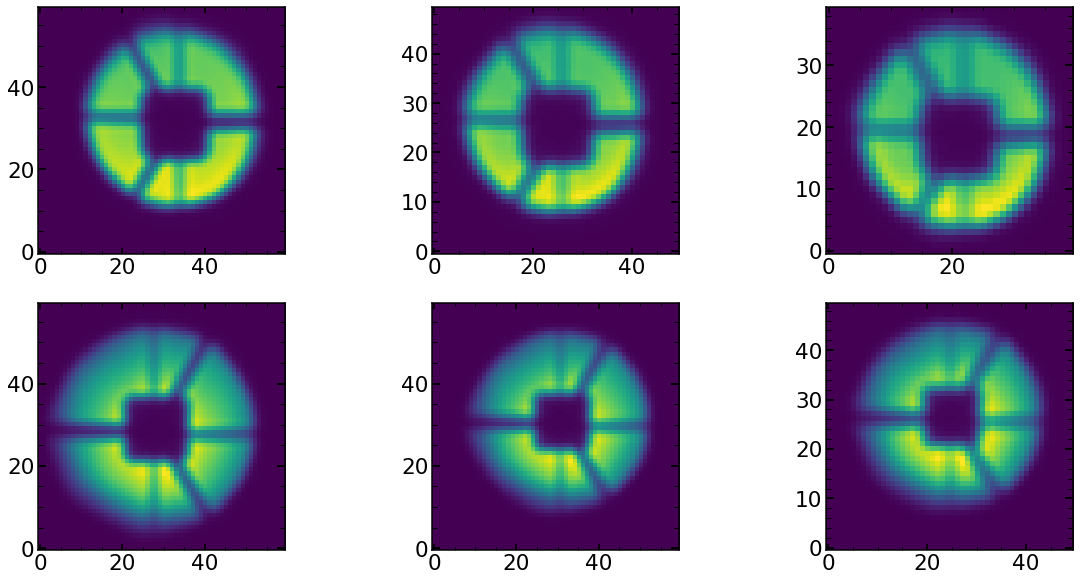

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(HgAr_single_image_p4)
plt.subplot(2,3,2)
plt.imshow(HgAr_single_image_p35)
plt.subplot(2,3,3)
plt.imshow(HgAr_single_image_p3)
plt.subplot(2,3,4)
plt.imshow(HgAr_single_image_m4)
plt.subplot(2,3,5)
plt.imshow(HgAr_single_image_m35)
plt.subplot(2,3,6)
plt.imshow(HgAr_single_image_m3)

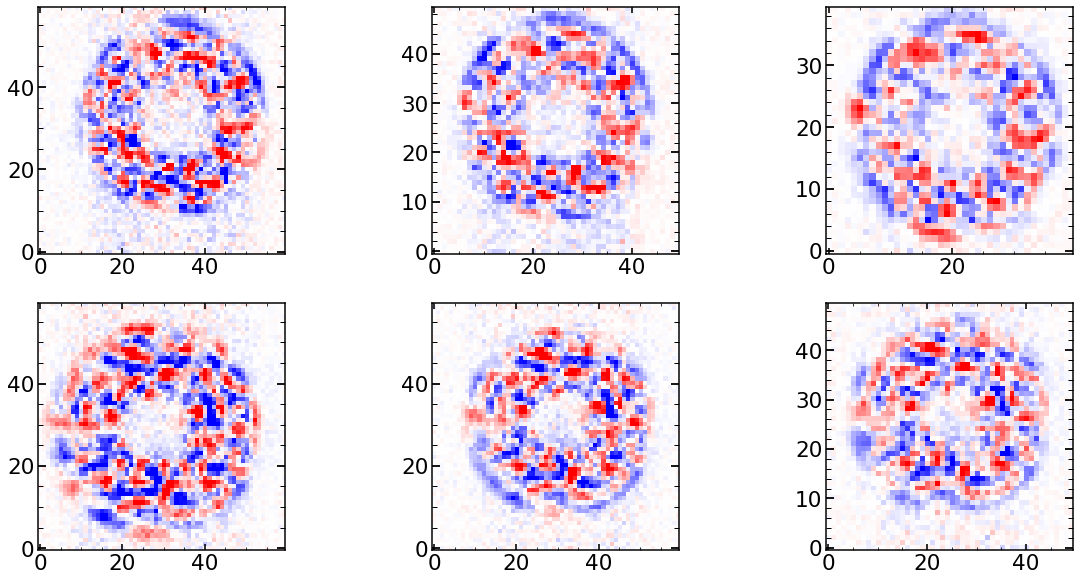

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(HgAr_single_image_p4-sci_image_p4,cmap=plt.get_cmap('bwr'),vmax=np.max(HgAr_single_image_p4)/20,vmin=-np.max(HgAr_single_image_p4)/20)
plt.subplot(2,3,2)
plt.imshow(HgAr_single_image_p35-sci_image_p35,cmap=plt.get_cmap('bwr'),vmax=np.max(HgAr_single_image_p35)/20,vmin=-np.max(HgAr_single_image_p35)/20)
plt.subplot(2,3,3)
plt.imshow(HgAr_single_image_p3-sci_image_p3,cmap=plt.get_cmap('bwr'),vmax=np.max(HgAr_single_image_p3)/20,vmin=-np.max(HgAr_single_image_p3)/20)
plt.subplot(2,3,4)
plt.imshow(HgAr_single_image_m4-sci_image_m4,cmap=plt.get_cmap('bwr'),vmax=np.max(HgAr_single_image_m4)/20,vmin=-np.max(HgAr_single_image_m4)/20)
plt.subplot(2,3,5)
plt.imshow(HgAr_single_image_m35-sci_image_m35,cmap=plt.get_cmap('bwr'),vmax=np.max(HgAr_single_image_m35)/20,vmin=-np.max(HgAr_single_image_m35)/20)
plt.subplot(2,3,6)
plt.imshow(HgAr_single_image_m3-sci_image_m3,cmap=plt.get_cmap('bwr'),vmax=np.max(HgAr_single_image_m3)/20,vmin=-np.max(HgAr_single_image_m3)/20)

In [191]:
'/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/final_optpsfApr0220_Single_P_'+str(21352)+'635HgAr'

'/Users/nevencaplar/Documents/PFS/TigerAnalysis/Result_DirectAndInt_FinalResults/final_optpsfApr0220_Single_P_21352635HgAr'

In [ ]:
# python /home/ncaplar/Code/Zernike_parameter_estimation.py 21352 "+str(single_spot)+" 2 5 4 HgAr 0 [0,0] 56 Mar06 direct Apr02 

# PIPE2D - 547 Negative values in LSF 

In [813]:
def provide_PSF_2D(x=None,y=None,PSF_version=None):
    """ Provide 2D PSF at any position in the detector plane
        This a version which takes a finite nubmer of pregenerated PSF and \
        creates the interpolated version at required position
        (Future: version which takes interpolated values for Zernike \
        coefficients and generates image on the fly?)
        

    @param[in] x            x-coordinate
    @param[in] y            y-coordinate
    @param[in] PSF_version  version of the PSF input files
    @returns                numpy array, 210x210, oversampled 10 times, corresponding to \
                            21x21 physical pixels (315x315 microns)
    """    
    
    # on tiger this directory is at:
    #DATA_DIRECTORY='/tigress/ncaplar/PIPE2D-450/'
    DATA_DIRECTORY='/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-450 (PSF_across_detector)/'
    
    if PSF_version is None:
        PSF_version='Sep11_v2'

    positions_of_simulation=np.load(DATA_DIRECTORY+'positions_of_simulation_00_from_'+PSF_version+'.npy',allow_pickle=True)
    array_of_simulation=np.load(DATA_DIRECTORY+'array_of_simulation_00_from_'+PSF_version+'.npy',allow_pickle=True)
    
    # x and y position with simulated PSFs
    x_positions_of_simulation=positions_of_simulation[:,1]
    y_positions_of_simulation=positions_of_simulation[:,2]
    
    # This is a simple code that finds the closest avaliable PSFs, given the x and y position
    # This will have to be improved in order when we get to work with the full populated dectector plane
    
    
    # how far in x-dimension are you willing to search for suitable simulated PSFs
    x_search_distance=20
    # positions of all simulated PSFs in that range
    positions_of_simulation_in_acceptable_x_range=\
    positions_of_simulation[(x_positions_of_simulation<(x+x_search_distance))\
                            &(x_positions_of_simulation>(x-x_search_distance))]
    
    # if there are no simulated PSF avaliable in the specified x-range we are not able to provide the solution
    if len(positions_of_simulation_in_acceptable_x_range)<2:
        print('No simulated PSFs are avaliable in this x-area of the detector,')
        print('probably because this fiber has not been illuminated;')
        print('returning the closest avaliable PSFs, BUT that is probably not what you want')
        distances=np.sqrt(((x-x_positions_of_simulation)**2+\
                           (y-y_positions_of_simulation)**2).astype(float))
        index_of_closest_distance=np.where(distances[distances==\
                                                     np.min(distances)])[0][0]
        
        # ! change here on April 20, 2020!
        #  changed so the output is more similar (output as a list) to more general case below
        return [array_of_simulation[index_of_closest_distance]]
        # end of change here on April 20, 2020
    
    # y-distance from the requested positions for all of the suitable simulated PSFs
    distances_of_y_requested_position_from_avaliable=\
    y-positions_of_simulation_in_acceptable_x_range[:,2]
    # out of the suitable PSFs, which 2 are the closest
    index_of_1st_closest_simulated_psf=\
    np.where(np.abs(distances_of_y_requested_position_from_avaliable)==\
             np.sort(np.abs(distances_of_y_requested_position_from_avaliable))[0])[0][0]
    
    # a bit more complicated process when selecting the second psf to ensure that we do not select the first spot twice   
    # change here on April 20, 2020!
    list_of_index_of_2nd_closest_simulated_psf=\
    np.where(np.abs(distances_of_y_requested_position_from_avaliable)==\
             np.sort(np.abs(distances_of_y_requested_position_from_avaliable))[1])[0]
    # if two psf spots are exactly the same distance from each other, this ensures that we do not select the first spot again
    if len(list_of_index_of_2nd_closest_simulated_psf)==2:
        index_of_2nd_closest_simulated_psf=list_of_index_of_2nd_closest_simulated_psf[1]
    else:
        index_of_2nd_closest_simulated_psf=list_of_index_of_2nd_closest_simulated_psf[0]
    # end of change here on April 20, 2020!
    
    # where are these 2 closest PSF in the initial table
    index_of_1st_closest_simulated_psf_in_positions_of_simulation=\
    np.where(np.sum(positions_of_simulation,axis=1)==\
             np.sum(positions_of_simulation_in_acceptable_x_range[index_of_1st_closest_simulated_psf]))[0][0]
    index_of_2nd_closest_simulated_psf_in_positions_of_simulation=\
    np.where(np.sum(positions_of_simulation,axis=1)==\
             np.sum(positions_of_simulation_in_acceptable_x_range[index_of_2nd_closest_simulated_psf]))[0][0]
    
    # extract the 2 simulated PSFs
    first_array_simulation=\
    array_of_simulation[index_of_1st_closest_simulated_psf_in_positions_of_simulation]
    second_array_simulation=\
    array_of_simulation[index_of_2nd_closest_simulated_psf_in_positions_of_simulation]
    
    print('1st:'+str(positions_of_simulation[index_of_1st_closest_simulated_psf_in_positions_of_simulation]),\
          '2nd:'+str(positions_of_simulation[index_of_2nd_closest_simulated_psf_in_positions_of_simulation]))
    
    # distance of each PSF from the proposed position
    print(positions_of_simulation[index_of_1st_closest_simulated_psf_in_positions_of_simulation],positions_of_simulation[index_of_2nd_closest_simulated_psf_in_positions_of_simulation])
    y1_distance=\
    y-positions_of_simulation[index_of_1st_closest_simulated_psf_in_positions_of_simulation][2]
    y2_distance=\
    y-positions_of_simulation[index_of_2nd_closest_simulated_psf_in_positions_of_simulation][2]
    
    # if you requested psf at the exact position of existing PSF use that one
    if y1_distance==0:
        print('requested psf at the exact position of existing PSF ')
        # ! change here on April 20, 2020!
        # changed so the output is equivalent as in more general case
        return first_array_simulation,first_array_simulation,second_array_simulation,y1_distance,y2_distance
        # end of change here on April 20, 2020
    else:    
        # create the predicted PSF as a linear interpolation of these two PSFs
        predicted_psf=(second_array_simulation-first_array_simulation*(y2_distance/y1_distance))/(1-y2_distance/y1_distance)
        return predicted_psf,first_array_simulation,second_array_simulation,y1_distance,y2_distance
    

## Sep11

In [18]:
test=provide_PSF_2D(1990.93,3021.58)

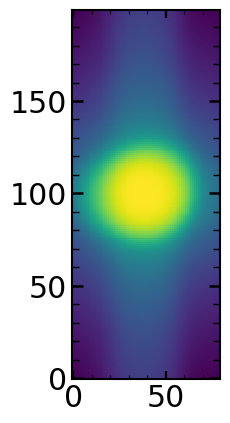

In [48]:
plt.imshow(test[105-100:105+100,105-40:105+40],norm=LogNorm())

In [20]:
test_for_LSF=test[105-100:105+100,105-30:105+30]
test_for_LSF_2d=Zernike_Module.resize(test_for_LSF,(20,6))
LSF=np.sum(test_for_LSF_2d,axis=1)

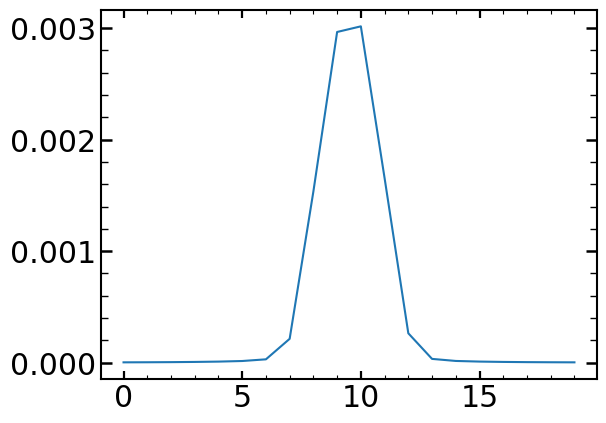

In [21]:
plt.plot(LSF)

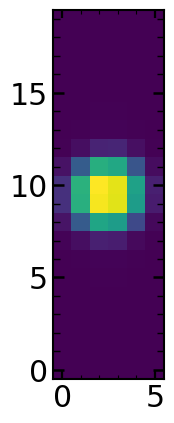

In [22]:
plt.imshow(Zernike_Module.resize(test_for_LSF,(20,6)))

In [23]:
# fiberId=339 wavelength=800 - where is that 

In [24]:
from astropy.io import fits
detector_map_fits = fits.open('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-547 (Negative values in LSF)/pfsDetectorMap-000000-r1.fits')

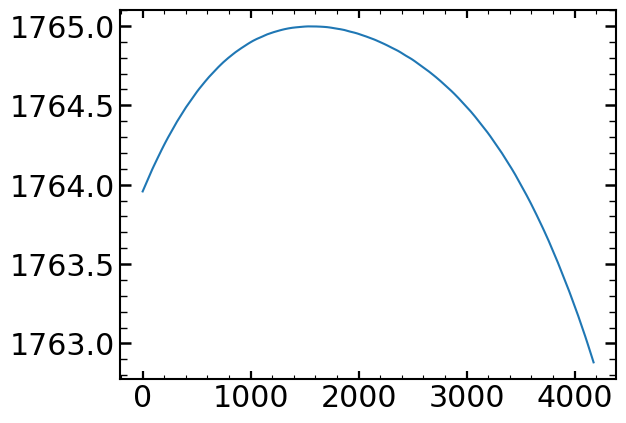

In [25]:
plt.plot(detector_map_fits[3].data[detector_map_fits[3].data['index']==339]['knot'],detector_map_fits[3].data[detector_map_fits[3].data['index']==339]['value'])

In [26]:
wavelength_Y_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==339]['value']
y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==339]['knot']
y_pixel_as_value_of_x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==339]['knot']
x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==339]['value']

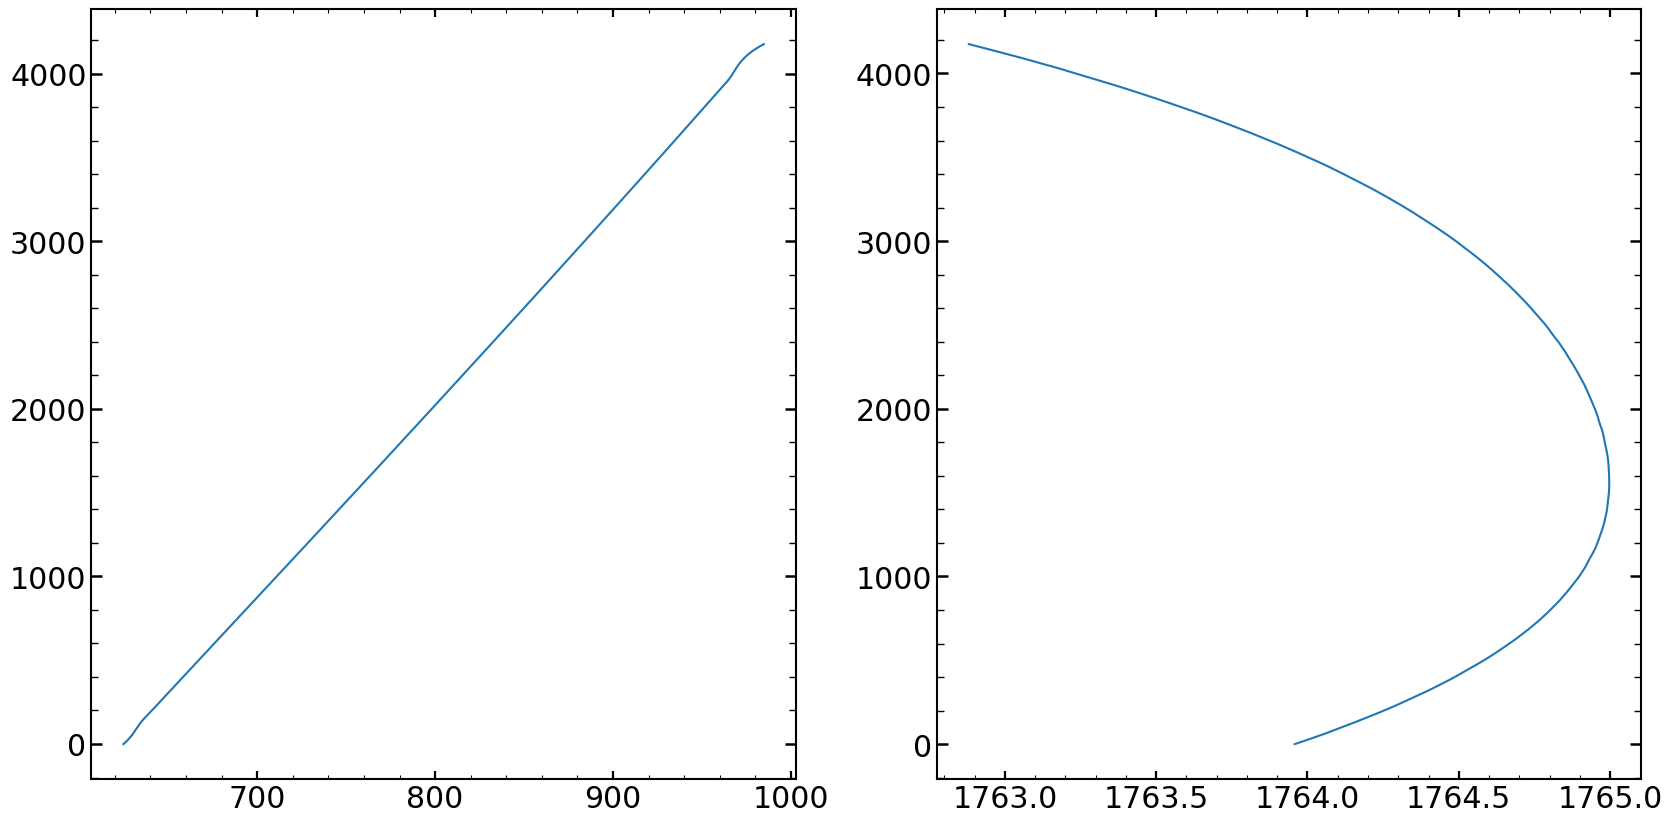

In [27]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.plot(wavelength_Y_339,y_pixel_339)

plt.subplot(122)
plt.plot(x_pixel_339,y_pixel_as_value_of_x_pixel_339)

In [28]:
detector_map_fits[4].data

FITS_rec([(  0,    0., 620.9046 ), (  0,    1., 621.04785),
          (  0,    2., 621.19025), ..., (599, 4173., 975.36194),
          (599, 4174., 975.47156), (599, 4175., 975.583  )],
         dtype=(numpy.record, [('index', '>i8'), ('knot', '>f4'), ('value', '>f4')]))

In [29]:
wavelength_339[(wavelength_339>799.9)&(wavelength_339<800.1)]

NameError: name 'wavelength_339' is not defined

In [81]:
# y value is at 2021
y_pixel_339[(wavelength_339>799.9)&(wavelength_339<800.1)]
# x value is at 1765 (reading from the plot)

array([2020.7063, 2021.7065], dtype=float32)

In [71]:
test_PIPE2D333,first_array_simulation,second_array_simulation,y1_distance,y2_distance=provide_PSF_2D(2000,2300)

In [84]:
y1_distance

-808

In [77]:
predicted_psf=(second_array_simulation-first_array_simulation*(y2_distance/y1_distance))/(1-y2_distance/y1_distance)

In [78]:
LSF_first=first_array_simulation[105-100:105+100,105-30:105+30]
LSF_first_2d=Zernike_Module.resize(LSF_first,(20,6))
LSF_1=np.sum(LSF_first_2d,axis=1)

LSF_second=second_array_simulation[105-100:105+100,105-30:105+30]
LSF_second_2d=Zernike_Module.resize(LSF_second,(20,6))
LSF_2=np.sum(LSF_second_2d,axis=1)

predicted_LSF=predicted_psf[105-100:105+100,105-30:105+30]
LSF_predicted_2d=Zernike_Module.resize(predicted_LSF,(20,6))
LSF_predicted=np.sum(LSF_predicted_2d,axis=1)

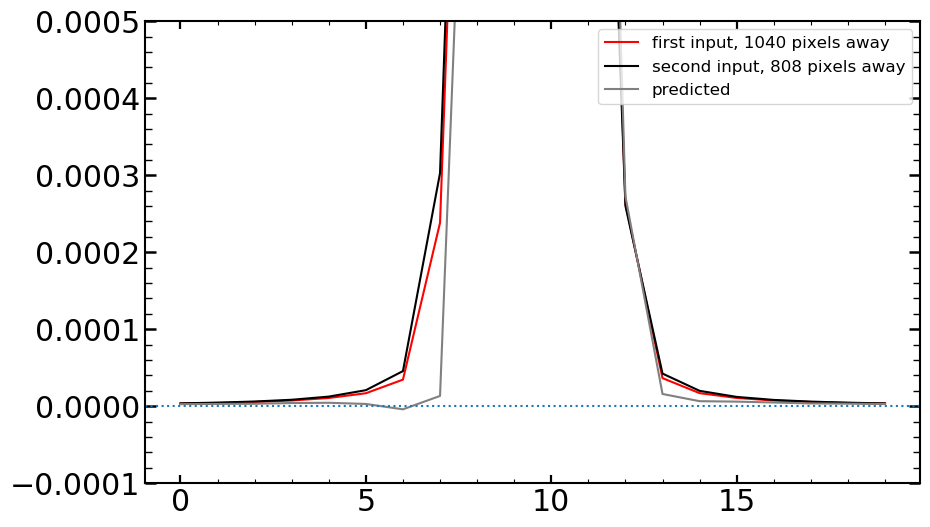

In [95]:
plt.figure(figsize=(10,6))
plt.plot(LSF_1,color='red',label='first input, 1040 pixels away')
plt.plot(LSF_2,color='black',label='second input, 808 pixels away')
plt.plot(LSF_predicted,color='gray',label='predicted')
plt.axhline(0,ls=':')
plt.ylim(-0.0001,0.0005,)
plt.legend(fontsize=12)

In [58]:
first_distance

-808

In [59]:
second_distance

-1040

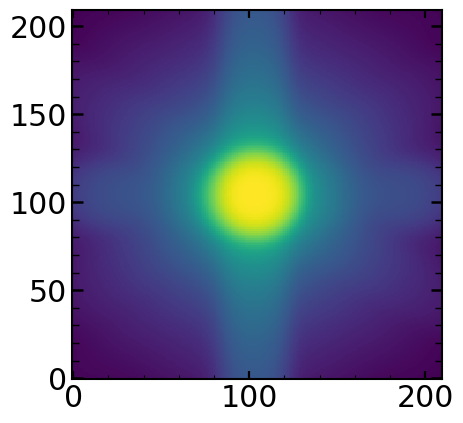

In [57]:
first_array[]

-4.135272890115939e-06


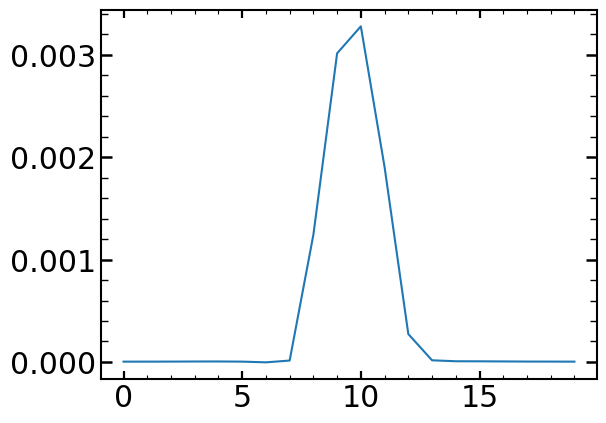

In [51]:
test_PIPE2D333=provide_PSF_2D(2000,2300)[0]

test_for_LSF=test_PIPE2D333[105-100:105+100,105-30:105+30]
test_for_LSF_2d=Zernike_Module.resize(test_for_LSF,(20,6))
LSF=np.sum(test_for_LSF_2d,axis=1)

print(np.min(LSF))
plt.plot(LSF)

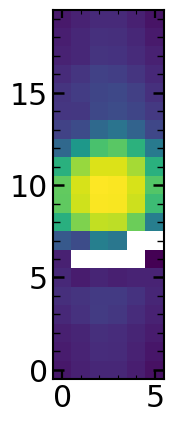

In [54]:
plt.imshow(test_for_LSF_2d,norm=LogNorm())

In [30]:
min_x_y_values=[]
x_y_LSFs=[]
x_y_test_for_LSF=[]
for x in np.arange(1800,2600,100):
    for y in np.arange(1800,2600,100):
        test_PIPE2D333=provide_PSF_2D(x,y)

        test_for_LSF=test_PIPE2D333[105-100:105+100,105-30:105+30]
        test_for_LSF_2d=Zernike_Module.resize(test_for_LSF,(20,6))
        LSF=np.sum(test_for_LSF_2d,axis=1)
        min_x_y_values.append([x,y,np.min(LSF)])
        x_y_LSFs.append([x,y,LSF])
        x_y_test_for_LSF.append([x,y,test_for_LSF])    
    
        
min_x_y_values=np.array(min_x_y_values)


No simulated PSFs are avaliable in this x-area of the detector,
probably because this fiber has not been illuminated;
returning the closest avaliable PSFs, BUT that is probably not what you want
No simulated PSFs are avaliable in this x-area of the detector,
probably because this fiber has not been illuminated;
returning the closest avaliable PSFs, BUT that is probably not what you want
No simulated PSFs are avaliable in this x-area of the detector,
probably because this fiber has not been illuminated;
returning the closest avaliable PSFs, BUT that is probably not what you want
No simulated PSFs are avaliable in this x-area of the detector,
probably because this fiber has not been illuminated;
returning the closest avaliable PSFs, BUT that is probably not what you want
No simulated PSFs are avaliable in this x-area of the detector,
probably because this fiber has not been illuminated;
returning the closest avaliable PSFs, BUT that is probably not what you want
No simulated PSFs are ava

In [255]:
min_x_y_values[0]

array([0.       , 0.       , 0.0000045])

In [31]:
min_x_y_values[min_x_y_values[:,2]==np.min(min_x_y_values[:,2])]

array([[2000.        , 2300.        ,   -0.00000414]])

In [32]:
np.array(x_y_LSFs)[min_x_y_values[:,2]==np.min(min_x_y_values[:,2])]

array([[2000, 2300,
        array([ 0.00000259,  0.00000288,  0.00000308,  0.00000404,  0.00000437,
        0.00000284, -0.00000414,  0.00001325,  0.00124258,  0.0030147 ,
        0.00327845,  0.00190311,  0.00027226,  0.00001579,  0.00000643,
        0.00000588,  0.0000047 ,  0.00000349,  0.00000317,  0.00000274])]],
      dtype=object)

In [40]:
test_for_LSF=np.array(x_y_test_for_LSF)[min_x_y_values[:,2]==np.min(min_x_y_values[:,2])][0][2]
test_for_LSF

array([[0.0000003 , 0.00000031, 0.00000032, ..., 0.00000027, 0.00000027,
        0.00000026],
       [0.00000031, 0.00000032, 0.00000032, ..., 0.00000027, 0.00000027,
        0.00000027],
       [0.00000032, 0.00000032, 0.00000033, ..., 0.00000028, 0.00000027,
        0.00000027],
       ...,
       [0.00000032, 0.00000033, 0.00000033, ..., 0.00000029, 0.00000029,
        0.00000029],
       [0.00000032, 0.00000032, 0.00000033, ..., 0.00000029, 0.00000028,
        0.00000028],
       [0.00000031, 0.00000031, 0.00000032, ..., 0.00000028, 0.00000028,
        0.00000028]])

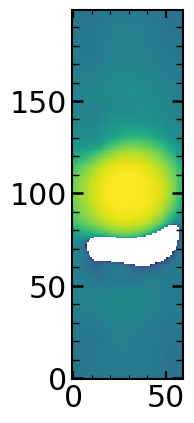

In [42]:
plt.imshow(test_for_LSF,norm=LogNorm())

## Apr15 20

In [639]:
np.unique(finalHgAr_Feb2020_dataset['wavelength'])

array(['690.9346', '696.7261', '706.8989', '727.47876', '738.6248',
       '763.74286', '795.0522', '826.6699', '852.4029', '912.5693',
       '922.7301', '966.0642'], dtype=object)

In [640]:
DATA_DIRECTORY='/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-450 (PSF_across_detector)/'


PSF_version='Apr1520_v2'

positions_of_simulation=np.load(DATA_DIRECTORY+'positions_of_simulation_00_from_'+PSF_version+'.npy',allow_pickle=True)
array_of_simulation=np.load(DATA_DIRECTORY+'array_of_simulation_00_from_'+PSF_version+'.npy',allow_pickle=True)


# x and y position with simulated PSFs
x_positions_of_simulation=positions_of_simulation[:,1]
y_positions_of_simulation=positions_of_simulation[:,2]

In [641]:
positions_of_simulation[(positions_of_simulation[:,1]<1630)&(positions_of_simulation[:,1]>1590)]

array([[339, 1610, 772, 690.9346],
       [339, 1610, 838, 696.7261],
       [339, 1610, 955, 706.8989],
       [339, 1610, 1318, 738.6248],
       [339, 1610, 1606, 763.74286],
       [339, 1610, 1968, 795.0522],
       [339, 1610, 2334, 826.6699],
       [339, 1610, 2635, 852.4029],
       [339, 1609, 3343, 912.5693],
       [339, 1609, 3464, 922.7301],
       [339, 1608, 3987, 966.0642],
       [339, 1612, 420, 660.0668],
       [339, 1613, 797, 693.13116],
       [339, 1613, 1077, 717.59015],
       [339, 1613, 1381, 744.1276],
       [339, 1611, 1858, 785.48],
       [339, 1611, 2246, 819.0]], dtype=object)

In [852]:
median_x_per_fiber=[]
fibers=np.unique(finalHgAr['fiber'].values)
for f in fibers:
    median_x_per_fiber.append(np.median(positions_of_simulation_00_HgAr[positions_of_simulation_00_HgAr['fiber']==f]['xc']))
    
print(median_x_per_fiber)

test_PIPE2D333,first_array_simulation,second_array_simulation,y1_distance,y2_distance=provide_PSF_2D(1610,650,PSF_version="Apr1520_v2")

print(y1_distance)
print(y2_distance)

predicted_psf=(second_array_simulation-first_array_simulation*(y2_distance/y1_distance))/(1-y2_distance/y1_distance)

LSF_first=first_array_simulation[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_first_2d=Zernike_Module.resize(LSF_first,(20,6))
LSF_1_no_broad=np.sum(LSF_first_2d,axis=1)

LSF_second=second_array_simulation[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_second_2d=Zernike_Module.resize(LSF_second,(20,6))
LSF_2_no_broad=np.sum(LSF_second_2d,axis=1)

predicted_LSF=predicted_psf[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_predicted_2d=Zernike_Module.resize(predicted_LSF,(20,6))
LSF_predicted_no_broad=np.sum(LSF_predicted_2d,axis=1)
###################

test_PIPE2D333,first_array_simulation,second_array_simulation,y1_distance,y2_distance=provide_PSF_2D(1610,650,PSF_version="Apr1520_v1")

print(y1_distance)
print(y2_distance)

predicted_psf=(second_array_simulation-first_array_simulation*(y2_distance/y1_distance))/(1-y2_distance/y1_distance)

LSF_first=first_array_simulation[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_first_2d=Zernike_Module.resize(LSF_first,(20,6))
LSF_1=np.sum(LSF_first_2d,axis=1)

LSF_second=second_array_simulation[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_second_2d=Zernike_Module.resize(LSF_second,(20,6))
LSF_2=np.sum(LSF_second_2d,axis=1)

predicted_LSF=predicted_psf[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
LSF_predicted_2d=Zernike_Module.resize(predicted_LSF,(20,6))
LSF_predicted=np.sum(LSF_predicted_2d,axis=1)

[71.5, 462.0, 846.0, 1223.0, 1610.0, 1992.0, 2440.0, 2828.0, 3624.0, 4003.0]
1st:[339 1610 772 690.9346] 2nd:[339 1613 797 693.13116]
[339 1610 772 690.9346] [339 1613 797 693.13116]
-122
-147
1st:[339 1610 772 690.9346] 2nd:[339 1613 797 693.13116]
[339 1610 772 690.9346] [339 1613 797 693.13116]
-122
-147


In [862]:
(y2_distance/y1_distance)

1.2049180327868851

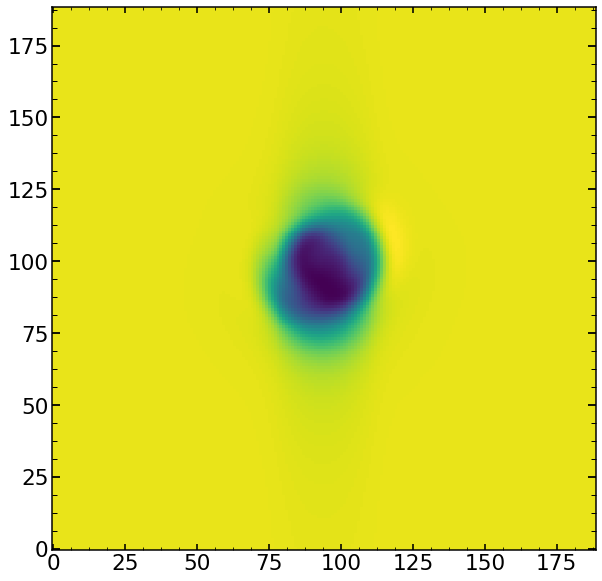

In [860]:
plt.imshow(second_array_simulation-first_array_simulation*(y2_distance/y1_distance))

In [854]:
np.sum(second_array_simulation)

1.0000000000000002

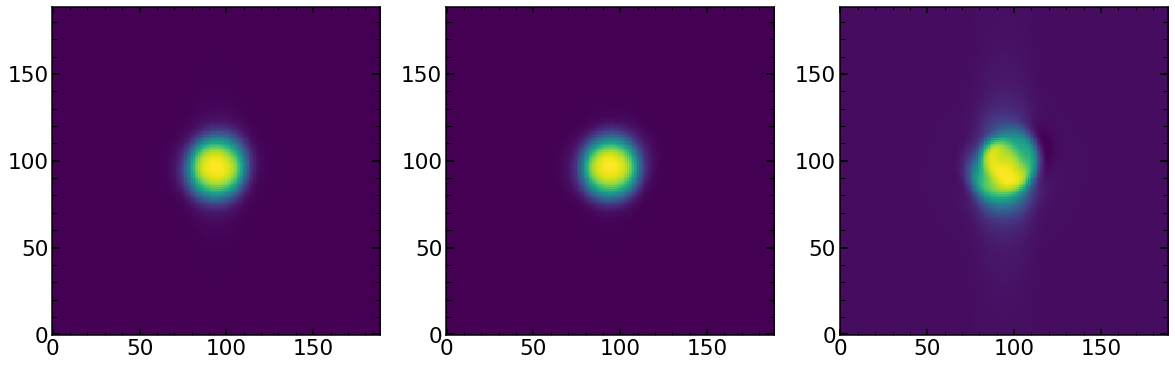

In [856]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(first_array_simulation)

plt.subplot(132)
plt.imshow(second_array_simulation)

plt.subplot(133)
plt.imshow(predicted_psf)

In [ ]:
plt.imshow(second_array_simulation-)

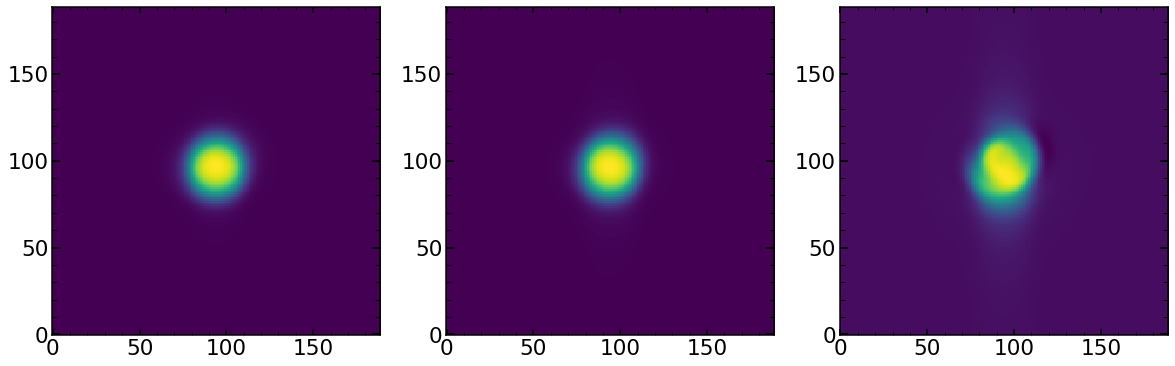

In [861]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(second_array_simulation)

plt.subplot(132)
plt.imshow(first_array_simulation*(y2_distance/y1_distance))

plt.subplot(133)
plt.imshow(predicted_psf)

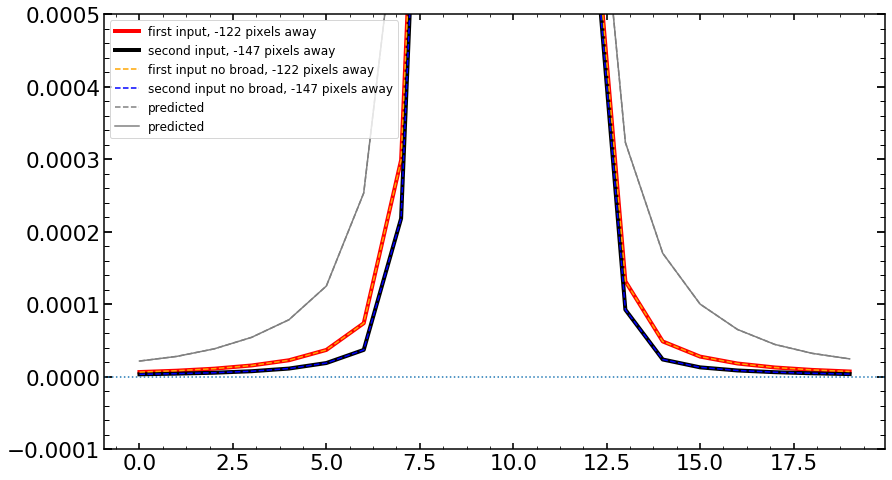

In [849]:
plt.figure(figsize=(14,8))
plt.plot(LSF_1,color='red',label='first input, '+str(y1_distance)+' pixels away',lw=4)
plt.plot(LSF_2,color='black',label='second input, '+str(y2_distance)+' pixels away',lw=4)

plt.plot(LSF_1_no_broad,color='orange',label='first input no broad, '+str(y1_distance)+' pixels away',ls='--')
plt.plot(LSF_2_no_broad,color='blue',label='second input no broad, '+str(y2_distance)+' pixels away',ls='--')

#plt.plot(LSF_no_broad,color='blue',label='no broad input, wavelength=922',ls='--')
#plt.plot(LSF_broad,color='blue',label='broad input, wavelength=922')

plt.plot(LSF_predicted_no_broad,color='gray',label='predicted',ls='--')
plt.plot(LSF_predicted,color='gray',label='predicted')
plt.axhline(0,ls=':')
plt.ylim(-0.0001,0.0005,)
plt.legend(fontsize=12)

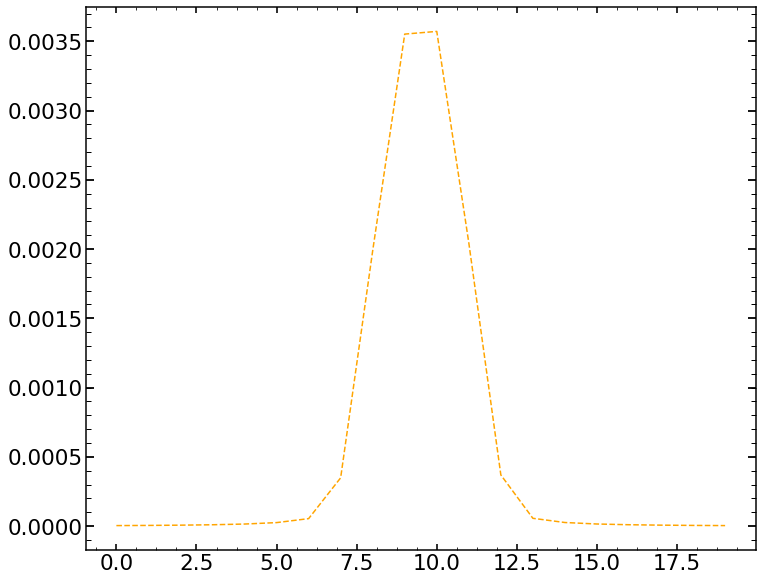

In [653]:
plt.plot(LSF_1_no_broad,color='orange',label='first input no broad, '+str(y1_distance)+' pixels away',ls='--')


In [814]:
oversampling=9

min_x_y_values=[]
x_y_LSFs=[]
x_y_test_for_LSF=[]
for x in tqdm(median_x_per_fiber):
    for y in np.arange(50,4050,50):
        print(x,y)
        test_PIPE2D333=provide_PSF_2D(x,y,PSF_version="Apr1520_v2")[0]

        test_for_LSF=test_PIPE2D333[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
        test_for_LSF_2d=Zernike_Module.resize(test_for_LSF,(20,6))
        LSF=np.sum(test_for_LSF_2d,axis=1)
        LSF=LSF/np.sum(LSF)
        min_x_y_values.append([x,y,np.min(LSF)])
        #x_y_LSFs.append([x,y,LSF])
        #x_y_test_for_LSF.append([x,y,test_for_LSF])    
    
        
min_x_y_values=np.array(min_x_y_values)

  0%|          | 0/10 [00:00<?, ?it/s]

71.5 50
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 100
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 150
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 200
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 250
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 300
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 350
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 400
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 450
1st:[2 69 453 660.0668] 2nd:[2 71 544 668.01764]
[2 69 453 660.0668] [2 71 544 668.01764]
71.5 500
1st:[2 71 544 668.01764] 2nd:[2 69 453 660.0668]
[2 71 544 668.01764] [2 69 453 660.0668]
71.5 550
1s

 10%|█         | 1/10 [00:01<00:14,  1.63s/it]

1st:[2 66 3395 912.5693] 2nd:[2 59 4044 966.0642]
[2 66 3395 912.5693] [2 59 4044 966.0642]
71.5 3700
1st:[2 66 3395 912.5693] 2nd:[2 59 4044 966.0642]
[2 66 3395 912.5693] [2 59 4044 966.0642]
71.5 3750
1st:[2 59 4044 966.0642] 2nd:[2 66 3395 912.5693]
[2 59 4044 966.0642] [2 66 3395 912.5693]
71.5 3800
1st:[2 59 4044 966.0642] 2nd:[2 66 3395 912.5693]
[2 59 4044 966.0642] [2 66 3395 912.5693]
71.5 3850
1st:[2 59 4044 966.0642] 2nd:[2 66 3395 912.5693]
[2 59 4044 966.0642] [2 66 3395 912.5693]
71.5 3900
1st:[2 59 4044 966.0642] 2nd:[2 66 3395 912.5693]
[2 59 4044 966.0642] [2 66 3395 912.5693]
71.5 3950
1st:[2 59 4044 966.0642] 2nd:[2 66 3395 912.5693]
[2 59 4044 966.0642] [2 66 3395 912.5693]
71.5 4000
1st:[2 59 4044 966.0642] 2nd:[2 66 3395 912.5693]
[2 59 4044 966.0642] [2 66 3395 912.5693]
462.0 50
1st:[63 461 443 660.0668] 2nd:[63 464 822 693.13116]
[63 461 443 660.0668] [63 464 822 693.13116]
462.0 100
1st:[63 461 443 660.0668] 2nd:[63 464 822 693.13116]
[63 461 443 660.0668] [6

 20%|██        | 2/10 [00:03<00:12,  1.61s/it]

1st:[63 453 4020 966.0642] 2nd:[63 459 3374 912.5693]
[63 453 4020 966.0642] [63 459 3374 912.5693]
462.0 3900
1st:[63 453 4020 966.0642] 2nd:[63 459 3374 912.5693]
[63 453 4020 966.0642] [63 459 3374 912.5693]
462.0 3950
1st:[63 453 4020 966.0642] 2nd:[63 459 3374 912.5693]
[63 453 4020 966.0642] [63 459 3374 912.5693]
462.0 4000
1st:[63 453 4020 966.0642] 2nd:[63 459 3374 912.5693]
[63 453 4020 966.0642] [63 459 3374 912.5693]
846.0 50
1st:[192 846 432 660.0668] 2nd:[192 848 810 693.13116]
[192 846 432 660.0668] [192 848 810 693.13116]
846.0 100
1st:[192 846 432 660.0668] 2nd:[192 848 810 693.13116]
[192 846 432 660.0668] [192 848 810 693.13116]
846.0 150
1st:[192 846 432 660.0668] 2nd:[192 848 810 693.13116]
[192 846 432 660.0668] [192 848 810 693.13116]
846.0 200
1st:[192 846 432 660.0668] 2nd:[192 848 810 693.13116]
[192 846 432 660.0668] [192 848 810 693.13116]
846.0 250
1st:[192 846 432 660.0668] 2nd:[192 848 810 693.13116]
[192 846 432 660.0668] [192 848 810 693.13116]
846.0 30

 30%|███       | 3/10 [00:04<00:11,  1.64s/it]

1st:[192 840 4009 966.0642] 2nd:[192 844 3360 912.5693]
[192 840 4009 966.0642] [192 844 3360 912.5693]
846.0 3750
1st:[192 840 4009 966.0642] 2nd:[192 844 3360 912.5693]
[192 840 4009 966.0642] [192 844 3360 912.5693]
846.0 3800
1st:[192 840 4009 966.0642] 2nd:[192 844 3360 912.5693]
[192 840 4009 966.0642] [192 844 3360 912.5693]
846.0 3850
1st:[192 840 4009 966.0642] 2nd:[192 844 3360 912.5693]
[192 840 4009 966.0642] [192 844 3360 912.5693]
846.0 3900
1st:[192 840 4009 966.0642] 2nd:[192 844 3360 912.5693]
[192 840 4009 966.0642] [192 844 3360 912.5693]
846.0 3950
1st:[192 840 4009 966.0642] 2nd:[192 844 3360 912.5693]
[192 840 4009 966.0642] [192 844 3360 912.5693]
846.0 4000
1st:[192 840 4009 966.0642] 2nd:[192 844 3360 912.5693]
[192 840 4009 966.0642] [192 844 3360 912.5693]
1223.0 50
1st:[255 1223 425 660.0668] 2nd:[255 1225 802 693.13116]
[255 1223 425 660.0668] [255 1225 802 693.13116]
1223.0 100
1st:[255 1223 425 660.0668] 2nd:[255 1225 802 693.13116]
[255 1223 425 660.0668

1st:[255 1221 3471 922.7301] 2nd:[255 1222 3116 892.87]
[255 1221 3471 922.7301] [255 1222 3116 892.87]
1223.0 3400
1st:[255 1221 3471 922.7301] 2nd:[255 1222 3116 892.87]
[255 1221 3471 922.7301] [255 1222 3116 892.87]
1223.0 3450
1st:[255 1221 3471 922.7301] 2nd:[255 1222 3116 892.87]
[255 1221 3471 922.7301] [255 1222 3116 892.87]
1223.0 3500
1st:[255 1221 3471 922.7301] 2nd:[255 1222 3116 892.87]
[255 1221 3471 922.7301] [255 1222 3116 892.87]
1223.0 3550
1st:[255 1221 3471 922.7301] 2nd:[255 1222 3116 892.87]
[255 1221 3471 922.7301] [255 1222 3116 892.87]
1223.0 3600
1st:[255 1221 3471 922.7301] 2nd:[255 1219 3993 966.0642]
[255 1221 3471 922.7301] [255 1219 3993 966.0642]
1223.0 3650
1st:[255 1221 3471 922.7301] 2nd:[255 1219 3993 966.0642]
[255 1221 3471 922.7301] [255 1219 3993 966.0642]
1223.0 3700
1st:[255 1221 3471 922.7301] 2nd:[255 1219 3993 966.0642]
[255 1221 3471 922.7301] [255 1219 3993 966.0642]
1223.0 3750
1st:[255 1219 3993 966.0642] 2nd:[255 1221 3471 922.7301]
[2

 40%|████      | 4/10 [00:06<00:09,  1.63s/it]

1st:[255 1219 3993 966.0642] 2nd:[255 1221 3471 922.7301]
[255 1219 3993 966.0642] [255 1221 3471 922.7301]
1223.0 4000
1st:[255 1219 3993 966.0642] 2nd:[255 1221 3471 922.7301]
[255 1219 3993 966.0642] [255 1221 3471 922.7301]
1610.0 50
1st:[339 1612 420 660.0668] 2nd:[339 1610 772 690.9346]
[339 1612 420 660.0668] [339 1610 772 690.9346]
1610.0 100
1st:[339 1612 420 660.0668] 2nd:[339 1610 772 690.9346]
[339 1612 420 660.0668] [339 1610 772 690.9346]
1610.0 150
1st:[339 1612 420 660.0668] 2nd:[339 1610 772 690.9346]
[339 1612 420 660.0668] [339 1610 772 690.9346]
1610.0 200
1st:[339 1612 420 660.0668] 2nd:[339 1610 772 690.9346]
[339 1612 420 660.0668] [339 1610 772 690.9346]
1610.0 250
1st:[339 1612 420 660.0668] 2nd:[339 1610 772 690.9346]
[339 1612 420 660.0668] [339 1610 772 690.9346]
1610.0 300
1st:[339 1612 420 660.0668] 2nd:[339 1610 772 690.9346]
[339 1612 420 660.0668] [339 1610 772 690.9346]
1610.0 350
1st:[339 1612 420 660.0668] 2nd:[339 1610 772 690.9346]
[339 1612 420 66

 50%|█████     | 5/10 [00:08<00:08,  1.62s/it]

1st:[339 1609 3464 922.7301] 2nd:[339 1609 3343 912.5693]
[339 1609 3464 922.7301] [339 1609 3343 912.5693]
1610.0 3650
1st:[339 1609 3464 922.7301] 2nd:[339 1609 3343 912.5693]
[339 1609 3464 922.7301] [339 1609 3343 912.5693]
1610.0 3700
1st:[339 1609 3464 922.7301] 2nd:[339 1608 3987 966.0642]
[339 1609 3464 922.7301] [339 1608 3987 966.0642]
1610.0 3750
1st:[339 1608 3987 966.0642] 2nd:[339 1609 3464 922.7301]
[339 1608 3987 966.0642] [339 1609 3464 922.7301]
1610.0 3800
1st:[339 1608 3987 966.0642] 2nd:[339 1609 3464 922.7301]
[339 1608 3987 966.0642] [339 1609 3464 922.7301]
1610.0 3850
1st:[339 1608 3987 966.0642] 2nd:[339 1609 3464 922.7301]
[339 1608 3987 966.0642] [339 1609 3464 922.7301]
1610.0 3900
1st:[339 1608 3987 966.0642] 2nd:[339 1609 3464 922.7301]
[339 1608 3987 966.0642] [339 1609 3464 922.7301]
1610.0 3950
1st:[339 1608 3987 966.0642] 2nd:[339 1609 3464 922.7301]
[339 1608 3987 966.0642] [339 1609 3464 922.7301]
1610.0 4000
1st:[339 1608 3987 966.0642] 2nd:[339 16

1st:[401 1992 3340 912.5693] 2nd:[401 1993 3108 892.87]
[401 1992 3340 912.5693] [401 1993 3108 892.87]
1992.0 3300
1st:[401 1992 3340 912.5693] 2nd:[401 1992 3460 922.7301]
[401 1992 3340 912.5693] [401 1992 3460 922.7301]
1992.0 3350
1st:[401 1992 3340 912.5693] 2nd:[401 1992 3460 922.7301]
[401 1992 3340 912.5693] [401 1992 3460 922.7301]
1992.0 3400
1st:[401 1992 3340 912.5693] 2nd:[401 1992 3460 922.7301]
[401 1992 3340 912.5693] [401 1992 3460 922.7301]
1992.0 3450
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 3500
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 3550
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 3600
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 3650
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3

 60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 3850
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 3900
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 3950
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
1992.0 4000
1st:[401 1992 3460 922.7301] 2nd:[401 1992 3340 912.5693]
[401 1992 3460 922.7301] [401 1992 3340 912.5693]
2440.0 50
1st:[464 2443 417 660.0668] 2nd:[464 2443 510 668.01764]
[464 2443 417 660.0668] [464 2443 510 668.01764]
2440.0 100
1st:[464 2443 417 660.0668] 2nd:[464 2443 510 668.01764]
[464 2443 417 660.0668] [464 2443 510 668.01764]
2440.0 150
1st:[464 2443 417 660.0668] 2nd:[464 2443 510 668.01764]
[464 2443 417 660.0668] [464 2443 510 668.01764]
2440.0 200
1st:[464 2443 417 660.0668] 2nd:[464 2443 510 668.0

1st:[464 2440 3342 912.5693] 2nd:[464 2440 3109 892.87]
[464 2440 3342 912.5693] [464 2440 3109 892.87]
2440.0 3550
1st:[464 2440 3342 912.5693] 2nd:[464 2441 3983 966.0642]
[464 2440 3342 912.5693] [464 2441 3983 966.0642]
2440.0 3600
1st:[464 2440 3342 912.5693] 2nd:[464 2441 3983 966.0642]
[464 2440 3342 912.5693] [464 2441 3983 966.0642]
2440.0 3650
1st:[464 2440 3342 912.5693] 2nd:[464 2441 3983 966.0642]
[464 2440 3342 912.5693] [464 2441 3983 966.0642]
2440.0 3700
1st:[464 2441 3983 966.0642] 2nd:[464 2440 3342 912.5693]
[464 2441 3983 966.0642] [464 2440 3342 912.5693]
2440.0 3750
1st:[464 2441 3983 966.0642] 2nd:[464 2440 3342 912.5693]
[464 2441 3983 966.0642] [464 2440 3342 912.5693]
2440.0 3800
1st:[464 2441 3983 966.0642] 2nd:[464 2440 3342 912.5693]
[464 2441 3983 966.0642] [464 2440 3342 912.5693]
2440.0 3850
1st:[464 2441 3983 966.0642] 2nd:[464 2440 3342 912.5693]
[464 2441 3983 966.0642] [464 2440 3342 912.5693]
2440.0 3900
1st:[464 2441 3983 966.0642] 2nd:[464 2440 3

 70%|███████   | 7/10 [00:11<00:04,  1.61s/it]

1st:[464 2441 3983 966.0642] 2nd:[464 2440 3342 912.5693]
[464 2441 3983 966.0642] [464 2440 3342 912.5693]
2828.0 50
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2832 514 668.01764] [525 2828 843 696.7261]
2828.0 100
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2832 514 668.01764] [525 2828 843 696.7261]
2828.0 150
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2832 514 668.01764] [525 2828 843 696.7261]
2828.0 200
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2832 514 668.01764] [525 2828 843 696.7261]
2828.0 250
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2832 514 668.01764] [525 2828 843 696.7261]
2828.0 300
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2832 514 668.01764] [525 2828 843 696.7261]
2828.0 350
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2832 514 668.01764] [525 2828 843 696.7261]
2828.0 400
1st:[525 2832 514 668.01764] 2nd:[525 2828 843 696.7261]
[525 2

 80%|████████  | 8/10 [00:12<00:03,  1.61s/it]

2828.0 3650
1st:[525 2829 3348 912.5693] 2nd:[525 2831 3993 966.0642]
[525 2829 3348 912.5693] [525 2831 3993 966.0642]
2828.0 3700
1st:[525 2831 3993 966.0642] 2nd:[525 2829 3348 912.5693]
[525 2831 3993 966.0642] [525 2829 3348 912.5693]
2828.0 3750
1st:[525 2831 3993 966.0642] 2nd:[525 2829 3348 912.5693]
[525 2831 3993 966.0642] [525 2829 3348 912.5693]
2828.0 3800
1st:[525 2831 3993 966.0642] 2nd:[525 2829 3348 912.5693]
[525 2831 3993 966.0642] [525 2829 3348 912.5693]
2828.0 3850
1st:[525 2831 3993 966.0642] 2nd:[525 2829 3348 912.5693]
[525 2831 3993 966.0642] [525 2829 3348 912.5693]
2828.0 3900
1st:[525 2831 3993 966.0642] 2nd:[525 2829 3348 912.5693]
[525 2831 3993 966.0642] [525 2829 3348 912.5693]
2828.0 3950
1st:[525 2831 3993 966.0642] 2nd:[525 2829 3348 912.5693]
[525 2831 3993 966.0642] [525 2829 3348 912.5693]
2828.0 4000
1st:[525 2831 3993 966.0642] 2nd:[525 2829 3348 912.5693]
[525 2831 3993 966.0642] [525 2829 3348 912.5693]
3624.0 50
1st:[587 3632 336 650.84186] 2

1st:[587 3628 3374 912.5693] 2nd:[587 3625 2963 877.68]
[587 3628 3374 912.5693] [587 3625 2963 877.68]
3624.0 3400
1st:[587 3628 3374 912.5693] 2nd:[587 3625 2963 877.68]
[587 3628 3374 912.5693] [587 3625 2963 877.68]
3624.0 3450
1st:[587 3628 3374 912.5693] 2nd:[587 3625 2963 877.68]
[587 3628 3374 912.5693] [587 3625 2963 877.68]
3624.0 3500
1st:[587 3628 3374 912.5693] 2nd:[587 3633 4022 966.0642]
[587 3628 3374 912.5693] [587 3633 4022 966.0642]
3624.0 3550
1st:[587 3628 3374 912.5693] 2nd:[587 3633 4022 966.0642]
[587 3628 3374 912.5693] [587 3633 4022 966.0642]
3624.0 3600
1st:[587 3628 3374 912.5693] 2nd:[587 3633 4022 966.0642]
[587 3628 3374 912.5693] [587 3633 4022 966.0642]
3624.0 3650
1st:[587 3628 3374 912.5693] 2nd:[587 3633 4022 966.0642]
[587 3628 3374 912.5693] [587 3633 4022 966.0642]
3624.0 3700
1st:[587 3633 4022 966.0642] 2nd:[587 3628 3374 912.5693]
[587 3633 4022 966.0642] [587 3628 3374 912.5693]
3624.0 3750
1st:[587 3633 4022 966.0642] 2nd:[587 3628 3374 912.

 90%|█████████ | 9/10 [00:14<00:01,  1.60s/it]

1st:[587 3633 4022 966.0642] 2nd:[587 3628 3374 912.5693]
[587 3633 4022 966.0642] [587 3628 3374 912.5693]
3624.0 3950
1st:[587 3633 4022 966.0642] 2nd:[587 3628 3374 912.5693]
[587 3633 4022 966.0642] [587 3628 3374 912.5693]
3624.0 4000
1st:[587 3633 4022 966.0642] 2nd:[587 3628 3374 912.5693]
[587 3633 4022 966.0642] [587 3628 3374 912.5693]
4003.0 50
1st:[650 4012 455 660.0668] 2nd:[650 4011 547 668.01764]
[650 4012 455 660.0668] [650 4011 547 668.01764]
4003.0 100
1st:[650 4012 455 660.0668] 2nd:[650 4011 547 668.01764]
[650 4012 455 660.0668] [650 4011 547 668.01764]
4003.0 150
1st:[650 4012 455 660.0668] 2nd:[650 4011 547 668.01764]
[650 4012 455 660.0668] [650 4011 547 668.01764]
4003.0 200
1st:[650 4012 455 660.0668] 2nd:[650 4011 547 668.01764]
[650 4012 455 660.0668] [650 4011 547 668.01764]
4003.0 250
1st:[650 4012 455 660.0668] 2nd:[650 4011 547 668.01764]
[650 4012 455 660.0668] [650 4011 547 668.01764]
4003.0 300
1st:[650 4012 455 660.0668] 2nd:[650 4011 547 668.01764]


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]

1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]
4003.0 3700
1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]
4003.0 3750
1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]
4003.0 3800
1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]
4003.0 3850
1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]
4003.0 3900
1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]
4003.0 3950
1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]
4003.0 4000
1st:[650 4016 4044 966.0642] 2nd:[650 4005 2981 877.68]
[650 4016 4044 966.0642] [650 4005 2981 877.68]


In [825]:
min_x_y_values[min_x_y_values[:,2]==np.max(min_x_y_values[:,2])]

array([[1610.        ,  650.        ,    0.00177152]])

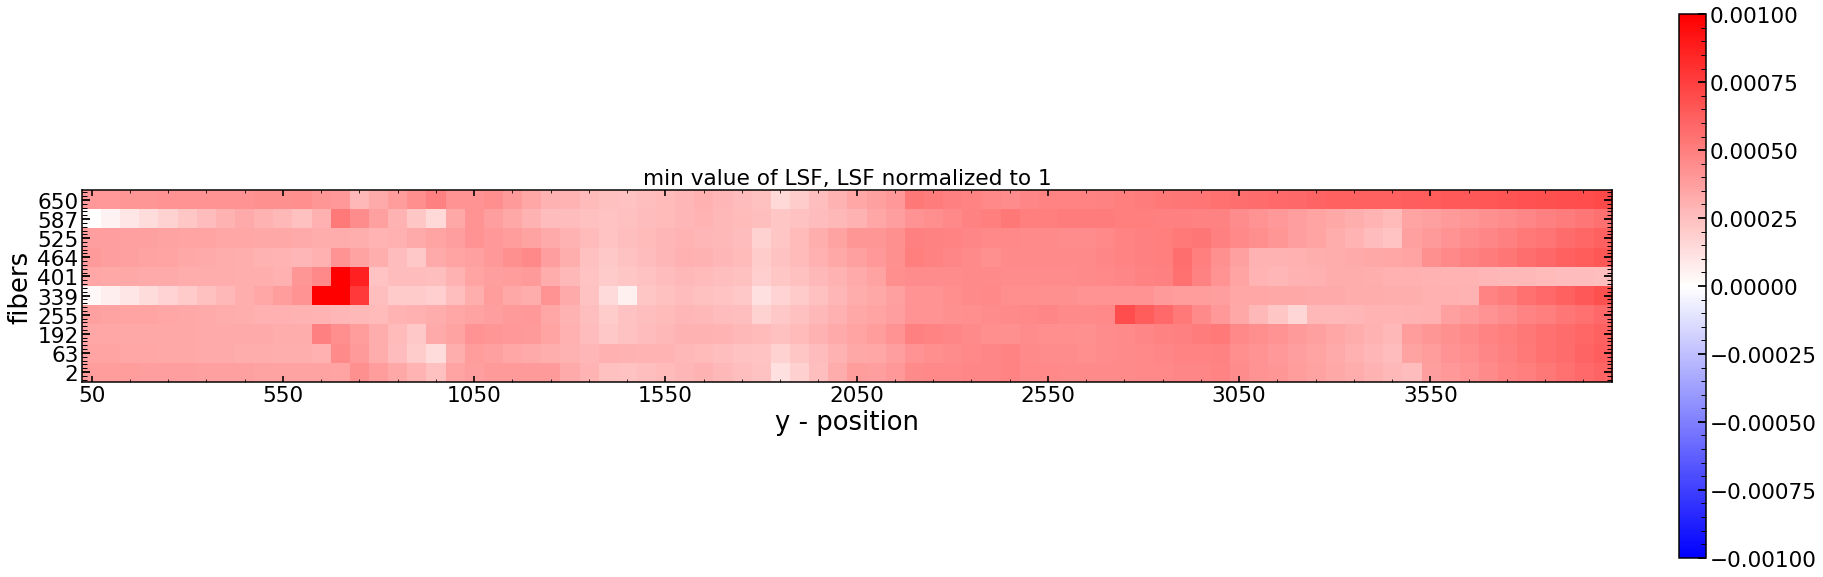

In [818]:
fig, ax = plt.subplots(figsize=(30,10))


cs = ax.imshow(min_x_y_values[:,2].reshape(10,80),vmax=0.001,vmin=-0.001,cmap='bwr')

ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.unique(finalHgAr_Feb2020_dataset['fiber'].values))

ax.set_xticklabels( np.arange(50-500,4550,500))

ax.set_ylabel('fibers')
ax.set_xlabel('y - position')
ax.set_title('min value of LSF, LSF normalized to 1')

cbar = fig.colorbar(cs,fraction=0.046, pad=0.04,)

In [744]:
 np.arange(50,4550,500)

array([  50,  550, 1050, 1550, 2050, 2550, 3050, 3550, 4050])

In [334]:
min_x_y_values[:,0].reshape(10,80)[4]

array([1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.,
       1610., 1610., 1610., 1610., 1610., 1610., 1610., 1610.])

In [333]:
min_x_y_values[:,1].reshape(10,80)[4][60]

3050.0

In [124]:
test_PIPE2D333=provide_PSF_2D(x,y,PSF_version="Apr1520_v1")
test_PIPE2D333.shape

(189, 189)

In [131]:
test_PIPE2D333=provide_PSF_2D(850,2360,PSF_version="Apr1520_v1")[0]
test_PIPE2D333.shape

(189, 189)

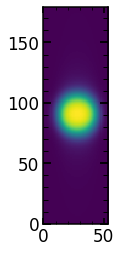

In [132]:
test_for_LSF=test_PIPE2D333[np.int(np.floor(9*21/2))-oversampling*10:np.int(np.floor(9*21/2))+oversampling*10,np.int(np.floor(9*21/2))-oversampling*3:np.int(np.floor(9*21/2))+oversampling*3]
plt.imshow(test_for_LSF)

# PIPE2D-556 (visualize DCB)

In [116]:
blue_fibers=[]
for i in [32, 111, 223, 289, 418, 518, 620]:
    vi=list(detector_map_fits[1].data).index(i)
    y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==vi]['knot']
    x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==vi]['value']
    blue_fibers.append([x_pixel_339,y_pixel_339])
    
green_fibers=[]
for i in [63, 192, 255, 401, 464, 525, 587]:
    vi=list(detector_map_fits[1].data).index(i)
    y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==vi]['knot']
    x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==vi]['value']
    green_fibers.append([x_pixel_339,y_pixel_339[0:len(x_pixel_339)]])
    
orange_fibers=[]
for i in [12, 60, 110, 161, 210, 259, 341]:
    vi=list(detector_map_fits[1].data).index(i)
    y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==vi]['knot']
    x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==vi]['value']
    orange_fibers.append([x_pixel_339,y_pixel_339])
    
yellow_fibers=[]
for i in [347, 400, 449, 466, 545, 593, 641]:
    vi=list(detector_map_fits[1].data).index(i)
    y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==vi]['knot']
    x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==vi]['value']
    yellow_fibers.append([x_pixel_339,y_pixel_339])
    
red_fibers=[]
for i in [2, 3, 308, 339, 340, 342, 649,650]:
    vi=list(detector_map_fits[1].data).index(i)
    y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==vi]['knot']
    x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==vi]['value']
    red_fibers.append([x_pixel_339,y_pixel_339[0:len(x_pixel_339)]])

In [119]:
np.median(blue_fibers[i][0])

2637.4778

Text(0.5,1,'Avaliable dummy cable fibers')

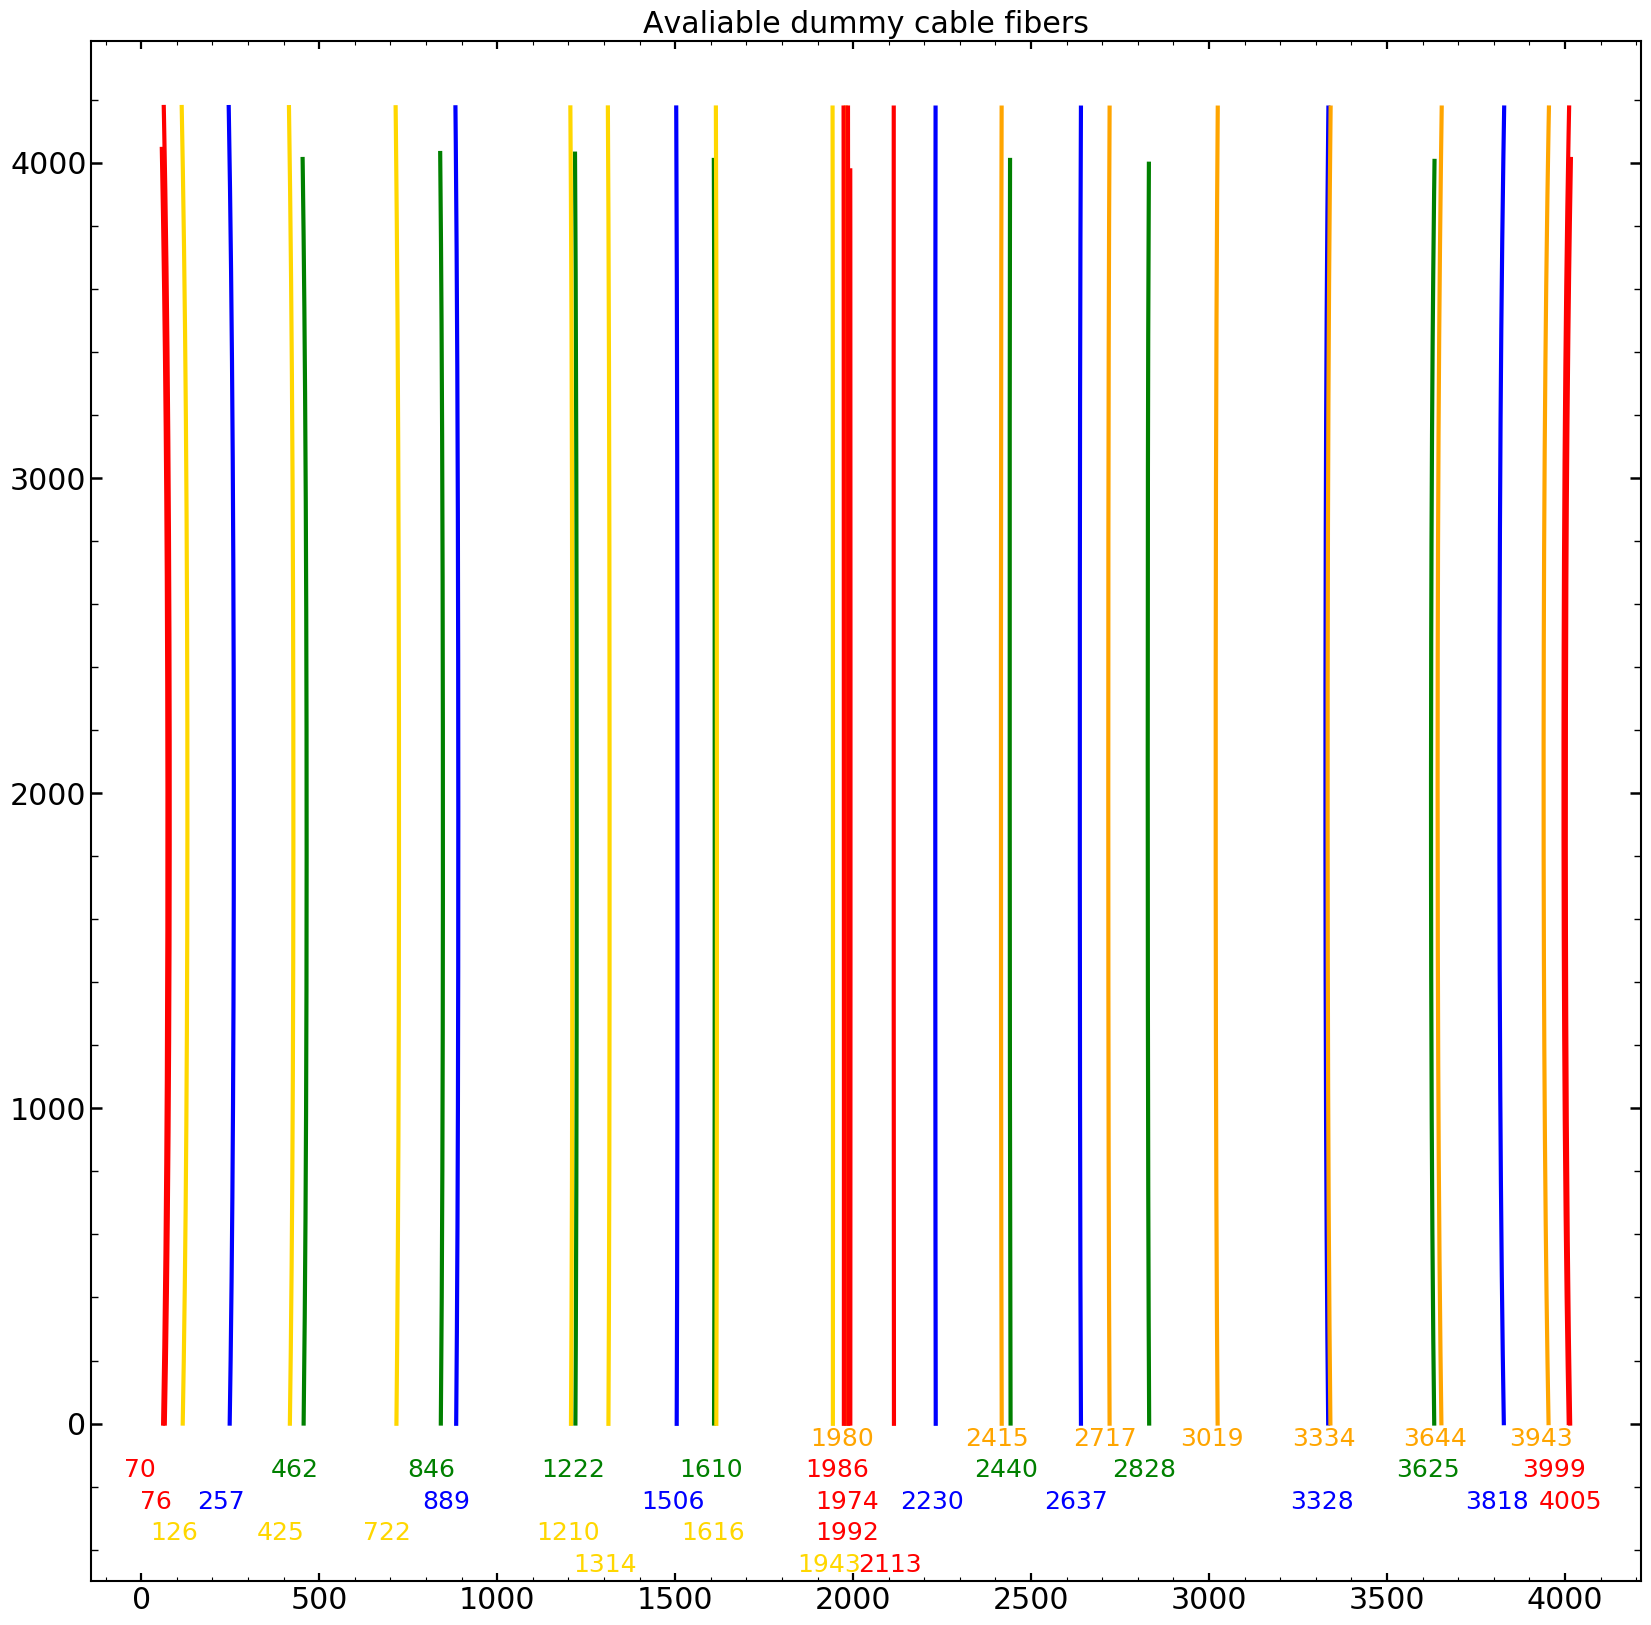

In [118]:
plt.figure(figsize=(20,20))
for i in range(len(blue_fibers)):
    plt.plot(blue_fibers[i][0],blue_fibers[i][1],color='blue',lw='3')
    plt.text(x=np.median(blue_fibers[i][0])-100,y=-270,s=np.int(np.median(blue_fibers[i][0])),color='blue')   
    
for i in range(len(green_fibers)):
    plt.plot(green_fibers[i][0],green_fibers[i][1],color='green',lw='3')
    plt.text(x=np.median(green_fibers[i][0])-100,y=-170,s=np.int(np.median(green_fibers[i][0])),color='green')   
    
for i in range(len(orange_fibers)):
    plt.plot(orange_fibers[i][0],orange_fibers[i][1],color='orange',lw='3')
    plt.text(x=np.median(orange_fibers[i][0])-100,y=-70,s=np.int(np.median(orange_fibers[i][0])),color='orange')
    
for i in [1,3,4,5,6]:
    plt.plot(yellow_fibers[i][0],yellow_fibers[i][1],color='gold',lw='3')
    plt.text(x=np.median(yellow_fibers[i][0])-100,y=-370,s=np.int(np.median(yellow_fibers[i][0])),color='gold',rotation='0')

for i in [0,2]:
    plt.plot(yellow_fibers[i][0],yellow_fibers[i][1],color='gold',lw='3')
    plt.text(x=np.median(yellow_fibers[i][0])-100,y=-470,s=np.int(np.median(yellow_fibers[i][0])),color='gold',rotation='0')

for i in [1,4,7]:
    plt.plot(red_fibers[i][0],red_fibers[i][1],color='red',lw='3')
    plt.text(x=np.median(red_fibers[i][0])-120,y=-170,s=np.int(np.median(red_fibers[i][0])),color='red',rotation='0')
 
for i in [0,5,6]:
    plt.plot(red_fibers[i][0],red_fibers[i][1],color='red',lw='3')
    plt.text(x=np.median(red_fibers[i][0])-80,y=-270,s=np.int(np.median(red_fibers[i][0])),color='red',rotation='0')
    
for i in [3]:
    plt.plot(red_fibers[i][0],red_fibers[i][1],color='red',lw='3')
    plt.text(x=np.median(red_fibers[i][0])-100,y=-370,s=np.int(np.median(red_fibers[i][0])),color='red',rotation='0')

for i in [2]:
    plt.plot(red_fibers[i][0],red_fibers[i][1],color='red',lw='3')
    plt.text(x=np.median(red_fibers[i][0])-100,y=-470,s=np.int(np.median(red_fibers[i][0])),color='red',rotation='0')
    
plt.ylim(-500)
plt.title('Avaliable dummy cable fibers')

In [122]:
for i in range(len(red_fibers)):
    plt.plot(red_fibers[i][0],red_fibers[i][1],color='red',lw='3')

In [132]:
detector_map_fits[4].data[detector_map_fits[4].data['index']==700]

FITS_rec([],
         dtype=(numpy.record, [('index', '>i8'), ('knot', '>f4'), ('value', '>f4')]))

In [144]:
list(detector_map_fits[1].data).index(2)

0

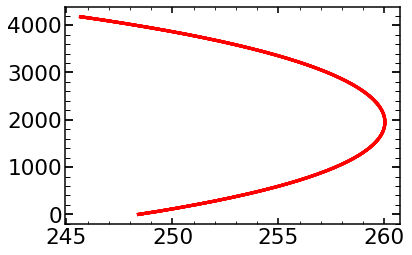

In [148]:
for i in range(len(red_fibers)):
    plt.plot(red_fibers[i][0],red_fibers[i][1],color='red',lw='3')

In [229]:
    print('green fiber from the plot above')
    vi=list(detector_map_fits[1].data).index(464)
    y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==vi]['knot']
    x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==vi]['value']
    print(y_pixel_339.shape)
    print(x_pixel_339.shape)
    print('blue fiber from the plot above')
    vi=list(detector_map_fits[1].data).index(223)
    y_pixel_339=detector_map_fits[4].data[detector_map_fits[4].data['index']==vi]['knot']
    x_pixel_339=detector_map_fits[3].data[detector_map_fits[3].data['index']==vi]['value']
    print(y_pixel_339.shape)
    print(x_pixel_339.shape)

green fiber from the plot above
(4176,)
(4030,)
blue fiber from the plot above
(4176,)
(4176,)


In [105]:
    DATA_DIRECTORY='/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-450 (PSF_across_detector)/'
    
    PSF_version='Sep11_v2'

    positions_of_simulation=np.load(DATA_DIRECTORY+'positions_of_simulation_00_from_'+PSF_version+'.npy',allow_pickle=True)
    PSF_version='Sep12_v2'
    positions_of_simulation_Sep12=np.load(DATA_DIRECTORY+'positions_of_simulation_00_from_'+PSF_version+'.npy',allow_pickle=True)

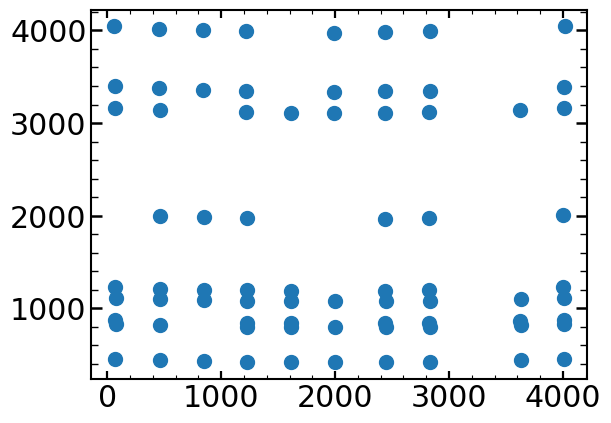

In [113]:
plt.scatter(positions_of_simulation[:,1],positions_of_simulation[:,2],s=100)
#plt.scatter(positions_of_simulation_Sep12[:,1],positions_of_simulation_Sep12[:,2])

# PIPE2D-529 (exposure times for Subaru)

In [191]:
finalHgAr_Feb2020_dataset

fiber    xc    yc wavelength close  lamp xc_effective second_offset  \
0       2    69   808   690.9346     0  HgAr           69        -19.25   
1       2    69   875   696.7261     1  HgAr           69             0   
2       2    70   992   706.8989     0  HgAr           70         16.93   
3       2    71  1229  727.47876     1  HgAr           71             0   
4       2    72  1358   738.6248     0  HgAr           72        -13.14   
..    ...   ...   ...        ...   ...   ...          ...           ...   
115   650  4002  2379   826.6699   0.5  HgAr         4071         18.83   
116   650  4003  2681   852.4029   0.5  HgAr         4072        -14.26   
117   650  4008  3393   912.5693     1  HgAr         4077             0   
118   650  4009  3515   922.7301     0  HgAr         4078         22.44   
119   650  4016  4044   966.0642     1  HgAr         4085             0   

    second_ratio second2_offset second2_ratio  
0         0.0034          -40.7         0.006  
1              0              0             0  
2          0.268          28.33         0.088  
3              0              0             0  
4          0.011              0             0  
..           ...            ...           ...  
115       0.0043              0             0  
116        0.015              0             0  
117            0              0             0  
118        0.022         -13.14         0.011  
119            0              0             0  

[120 rows x 11 columns]